<a id='top'></a>

# Powder Mountain Aquifer Test Data

## Table of Contents
-[Data Sources](#Data-Sources)<br>
-[Climate Data](#Climate-Data)<br>
-[Upper Lefty's Spring](#Upper-Lefty's-Spring)<br>
&nbsp;&nbsp;&nbsp;&nbsp;-[Importing and Converting Upper Lefty's Spring Data](#Importing-and-Converting-Upper-Lefty's-Spring-Data)<br>
&nbsp;&nbsp;&nbsp;&nbsp;-[Comparing the Data](#Comparing-the-Data)<br>
-[Lower Lefty's Spring](#Lower-Lefty's-Spring)<br>
&nbsp;&nbsp;&nbsp;&nbsp;-[Importing and Converting Lower Lefty's Spring Data](#Importing-and-Converting-Lower-Lefty's-Spring-Data)<br>
-[Hidden Lake Spring](#Hidden-Lake-Spring)<br>
&nbsp;&nbsp;&nbsp;&nbsp;-[Importing and Converting Hidden Lake Spring Data](#Importing-and-Converting-Hidden-Lake-Spring-Data)<br>
-[North Boundary Weir](#North-Boundary-Weir)<br>
&nbsp;&nbsp;&nbsp;&nbsp;-[Importing and Converting North Boundary Weir Data](#Importing-and-Converting-North-Boundary-Weir-Data)<br>
-[Hidden Lake Well](#Hidden-Lake-Well)<br>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.stats as sp
import statsmodels.api as sm
from pandas.stats.api import ols
from datetime import datetime
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
plt.rc('svg', fonttype = 'svgfont')

In [2]:
import wellapplication as wa

In [3]:
wa.__version__

'0.2.3'

In [4]:
import wellapplication.transport as wt

In [5]:
print 'Pandas version ' + pd.__version__

Pandas version 0.17.1


In [6]:
def rollmeandiff(df1,p1,df2,p2,win):
    '''
    returns the rolling mean difference of two columns from two different dataframes
    df1 = dataframe 1
    p1 = column in df1
    df2 = dataframe 2
    p2 =column in df2
    win = window in days
    '''
    win = win*60*24
    df1 = df1.resample('1Min', how='mean')
    df1 = df1.interpolate(method='time')
    df2 = df2.resample('1Min', how='mean')
    df2 = df2.interpolate(method='time')
    df1['rm'+p1] = pd.rolling_mean(df1[p1], window=win, center=True)
    df2['rm'+p2] = pd.rolling_mean(df2[p2], window=win, center=True)
    df3 = pd.merge(df1,df2,left_index=True, right_index=True, how='outer')
    df3 = df3[np.isfinite(df3['rm'+p1])]
    df4 = df3[np.isfinite(df3['rm'+p2])]
    df5 = df4['rm'+p1] - df4['rm'+p2]
    diff = round(df5.mean(),3)
    del (df3,df4,df5)
    return diff

In [7]:
def nodups(df,dfbig):
    some_list = list(df.columns.values)
    for i in range(len(some_list)):
        if some_list[i] in list(dfbig.columns.values):
            df = df.drop(some_list[i], axis=1)
        elif "_Q_" in some_list[i] or "t_C" in some_list[i] or "date" in some_list[i] or "dt" in some_list[i] or "_BP_" in some_list[i] or "_elev_" in some_list[i] or "SF_AD" in some_list[i] or "PPT_in" in some_list[i]:
            pass
        else:
            try:
                df = df.drop(some_list[i], axis=1)
            except (NameError,ValueError):
                pass
    return df


## Data Sources

[To top of page](#top)

In [8]:
rootlocal = 'E:/PROJECTS/POWMOW/'
#rootlocal = '/media/p/Transcend/PROJECTS/POWMOW/'

This section allows for rapid adjustment of the locations of the source files as they are updated/changed.

In [9]:
USU_Data = rootlocal + 'E5382-MonitoringData/Information Received from UGS/USU_data.xlsx'
SNOTEL_Data = rootlocal + 'E5382-MonitoringData/Information Received from UGS/582_ALL_WATERYEAR=2014.csv'
SNOTEL_Data1 = rootlocal + 'E5382-MonitoringData/Information Received from UGS/582_ALL_WATERYEAR=2015.csv'
SNODAS_Data = rootlocal + 'SNODAS/SWE.csv'

Paths to Leftys Spring weir data. <br>
[Loughlin data import](#leftys); [Loughlin BP import](#leftysbp); [Files data import](#leftysfiles); [Manual Readings](#leftysman)

In [10]:
Upper_Leftys_Loughlin = rootlocal + 'E5382-MonitoringData/lefty spring wls_150103085317_N3263.CSV'
Upper_Leftys_Barometer_Loughlin = rootlocal + 'E5382-MonitoringData/lefty spring baromer_150103084642_P5348.csv'
Upper_Leftys_John_Files = rootlocal + 'E5382-MonitoringData/Information Received from Protestants/LEFTYSSPRINGVENTD 2015-01-01 11.16.01.wsl.csv'
Upper_Leftys_Manual = rootlocal + 'E5382-MonitoringData/Information Received from UGS/Manual_Readings_Compilation.xlsx'
Upper_Leftys_Loughlin_old = rootlocal + 'E5382-MonitoringData/Information Received from Protestants/ExplWell2Long term.xlsx'

Paths to Lower Leftys weir data.<br>
[Loughlin data import](#lower); [Loughlin BP import](#leftysbp1); [Files data import](#fileslower); [Manual Readings](#lowerman)

In [11]:
Lower_Leftys_Loughlin = rootlocal + 'E5382-MonitoringData/below lefty spring_150103090632_S4811.CSV'
Lower_Leftys_John_Files = rootlocal + 'E5382-MonitoringData/Information Received from Protestants/LOWER LEFTYS SPRING NOV26 2015-01-01 10.47.45.wsl.csv'
Lower_Leftys_Manual = rootlocal + 'E5382-MonitoringData/Information Received from UGS/Manual_Readings_Compilation.xlsx'
Lower_Leftys_John_Files2 = rootlocal + 'E5382-MonitoringData/Information Received from Protestants/LOWERLEFTYS2015_Append_2015-04-03_15-05-57-229.csv'
Lower_Leftys_John_Files3 = rootlocal + 'E5382-MonitoringData/Information Received from Protestants/LOWERLEFTYS2015_Append_2015-10-04_.csv'

Paths to Hidden Lake weir data.<br>
[Loughlin data import](#hidden); [Loughlin BP import](#hiddenbp); [Files data import](#hiddenfiles); [Manual Readings](#hiddenman)

In [12]:
Hidden_Lake_Loughlin = rootlocal + 'E5382-MonitoringData/hidden lake weir_150103083626_S4264.CSV'
Hidden_Lake_Barometer_Loughlin = rootlocal + 'E5382-MonitoringData/northside barometer_150103090335_G5805.CSV'
Hidden_Lake_John_Files = rootlocal + 'E5382-MonitoringData/Information Received from Protestants/Wellsville 2015-01-01 13.59.01.wsl.csv'
Hidden_Lake_Manual = rootlocal + 'E5382-MonitoringData/Information Received from UGS/Manual_Readings_Compilation.xlsx'

Paths to North Boundary weir data.<br>
[Loughlin data import](#nb); [Loughlin BP import](#nbbp); [UGS data import](#nbugs); [Manual Readings](#northman)

In [13]:
North_Boundary_Loughlin = rootlocal + 'E5382-MonitoringData/north boundary weir_150103091930_S4248.CSV'
North_Boundary_UGS = rootlocal + 'E5382-MonitoringData/Information Received from UGS/WELLSVILE NORTH BOUNDARY_12_19_2014.csv'
North_Boundary_Manual = rootlocal + 'E5382-MonitoringData/Information Received from UGS/Manual_Readings_Compilation.xlsx'

Paths to Hidden Lake Well.<br>
[Loughlin data import](#hlw); [Loughlin BP import](#leftysbp2); [Manual Readings](#hlwman)

In [14]:
Hidden_Lake_Well = rootlocal + 'E5382-MonitoringData/HLW-2015-01-02.xls'
Hidden_Lake_Well_Manual = rootlocal + 'E5382-MonitoringData/Information Received from UGS/Manual_Readings_Compilation.xlsx'

Paths to Exploration Well 2.<br>
[Loughlin data import](#exw); [Loughlin BP import](#exbp); [Manual Readings](#exman)

In [15]:
Exploration_Well_2 = rootlocal + 'E5382-MonitoringData/Long-Term Pumping Test_Append_2015-01-03_12-26-45-976.csv'
Exploration_Well_2_Manual = rootlocal + 'E5382-MonitoringData/Information Received from UGS/Manual_Readings_Compilation.xlsx'
oldwls2013 = rootlocal + "E5382-MonitoringData/Information Received from Protestants/ExplWell2Long term.xlsx"

Where to output data

In [16]:
OUT = rootlocal + 'all.csv'

## Climate Data

[To top of page](#top)

### SNOTEL

Import hourly SNOTEL data downloaded from the <a href='http://www.wcc.nrcs.usda.gov/nwcc/site?sitenum=582'> Little Bear SNOTEL station</a>. The path to the input file can be found in the [data sources](#Data-Sources) section. 

In [17]:
SNOTEL = pd.read_csv(SNOTEL_Data, parse_dates=[[1,2]], index_col=0, skiprows=2, engine='python',na_values=[-99.9])
SNOTEL1 = pd.read_csv(SNOTEL_Data1, parse_dates=[[1,2]], index_col=0, skiprows=2, engine='python',na_values=[-99.9])
SNOTEL = pd.concat([SNOTEL,SNOTEL1])
#SNOTEL = SNOTEL.resample('1Min', how='mean')
#SNOTEL = SNOTEL.interpolate(method='time')
#SNOTEL = SNOTEL.resample('15Min', how='mean')

In [18]:
SNOTEL.columns

Index([u'Site Id', u'WTEQ.I-1 (in) ', u'PREC.I-1 (in) ', u'TOBS.I-1 (degC) ',
       u'SNWD.I-1 (in) ', u'SMS.I-1:-2 (pct)  (silt)',
       u'SMS.I-1:-8 (pct)  (silt)', u'SMS.I-1:-20 (pct)  (silt)',
       u'STO.I-1:-2 (degC) ', u'STO.I-1:-8 (degC) ', u'STO.I-1:-20 (degC) ',
       u'SAL.I-1:-2 (gram) ', u'SAL.I-1:-8 (gram) ', u'SAL.I-1:-20 (gram) ',
       u'RDC.I-1:-2 (unit) ', u'RDC.I-1:-8 (unit) ', u'RDC.I-1:-20 (unit) ',
       u'BATT.I-1 (volt) ', u'Unnamed: 20'],
      dtype='object')

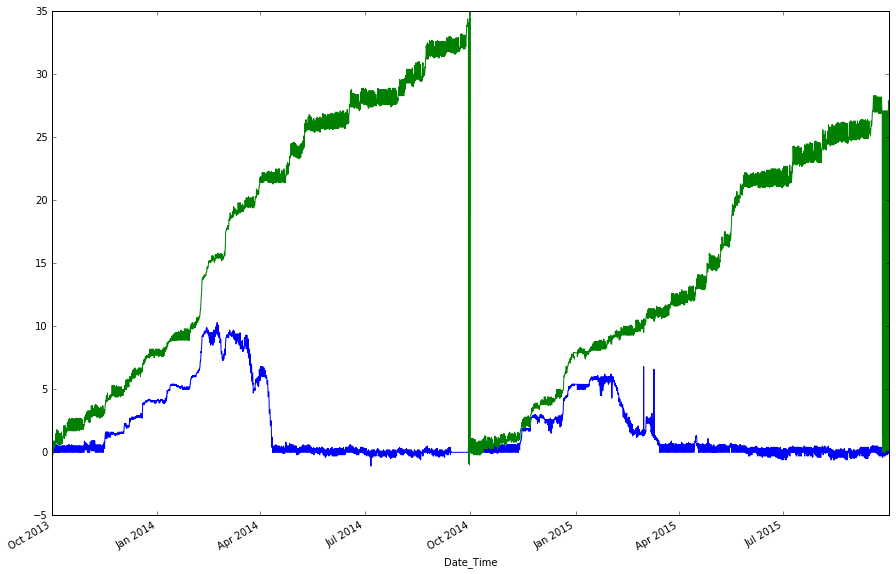

In [19]:
SNOTEL['WTEQ.I-1 (in) '].plot()
SNOTEL['PREC.I-1 (in) '].plot()

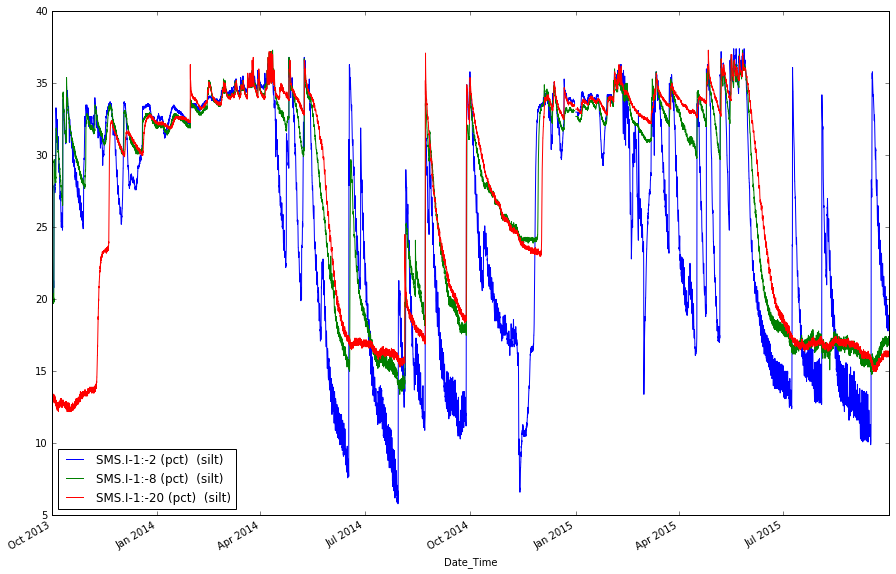

In [20]:
SNOTEL[[u'SMS.I-1:-2 (pct)  (silt)', u'SMS.I-1:-8 (pct)  (silt)', u'SMS.I-1:-20 (pct)  (silt)']].plot()

In [21]:
SNOTEL = SNOTEL.resample('1Min', how='mean')
SNOTEL = SNOTEL.interpolate(method='time', limit=90)
SNOTEL = SNOTEL.resample('15Min', how='mean')

### SNODAS

https://nsidc.org/data/g02158

In [22]:
SNODAS = pd.read_csv(SNODAS_Data, index_col=0, parse_dates=True)

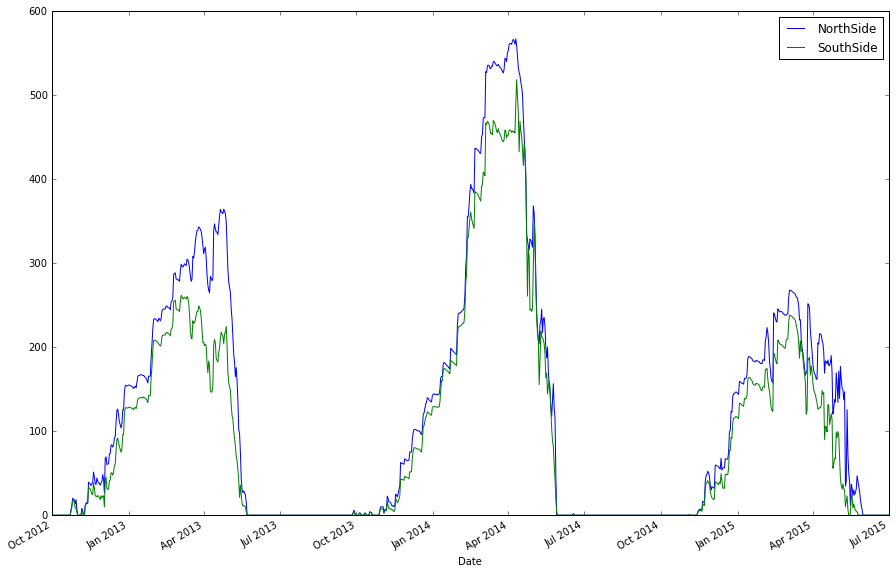

In [23]:
SNODAS[['NorthSide','SouthSide']].plot()
plt.savefig(rootlocal+'SNODAS.pdf')

In [24]:
SNODAS = SNODAS.resample('1Min', how='mean')
SNODAS = SNODAS.interpolate(method='time')
SNODAS = SNODAS.resample('15Min', how='mean')

### USU

Import hourly data downloaded from the Utah State University (USU) <a href=http://icewater.usu.edu/Data-Query>HydroServer</a>. These data include hourly barometric pressure, precipitation, and gage height measurements. The gage height measurements were recorded on the Little Bear River above and below the confluence of greater Davenport Creek. The path to the input file can be found in the [data sources](#Data-Sources) section.

In [25]:
USU_Avon_BP = pd.read_excel(USU_Data, 'Avon Barometric Pressure', index_col=0, na_values=['-9999',''],
                          parse_cols=[0,1], skiprows=0, names=['dt','USU_Avon_BP_mmHg'])

In [26]:
USU_SF_BP = pd.read_excel(USU_Data, 'South Fork Barometric Pressure', index_col=0, na_values=['-9999',''],
                          parse_cols=[0,1], skiprows=0, names=['dt','USU_SF_BP_mmHg'])

In [27]:
USU_SF_PPT = pd.read_excel(USU_Data, 'South Fork Precipitation', index_col=0, na_values=['-9999',''],
                          parse_cols=[0,1], skiprows=0, names=['dt','USU_SF_PPT_in'])

In [29]:
USU_SF_AD = pd.read_excel(USU_Data, 'South Fork h Above Davenport', index_col=0, na_values=['-9999',''],
                          parse_cols=[0,1], skiprows=0, names=['dt','USU_SF_AD_h_ft'])

In [30]:
USU_SF_BD = pd.read_excel(USU_Data, 'South Fork h Below Davenport', index_col=0, na_values=['-9999',''],
                          parse_cols=[0,1], skiprows=0, names=['dt','USU_SF_BD_h_ft'])

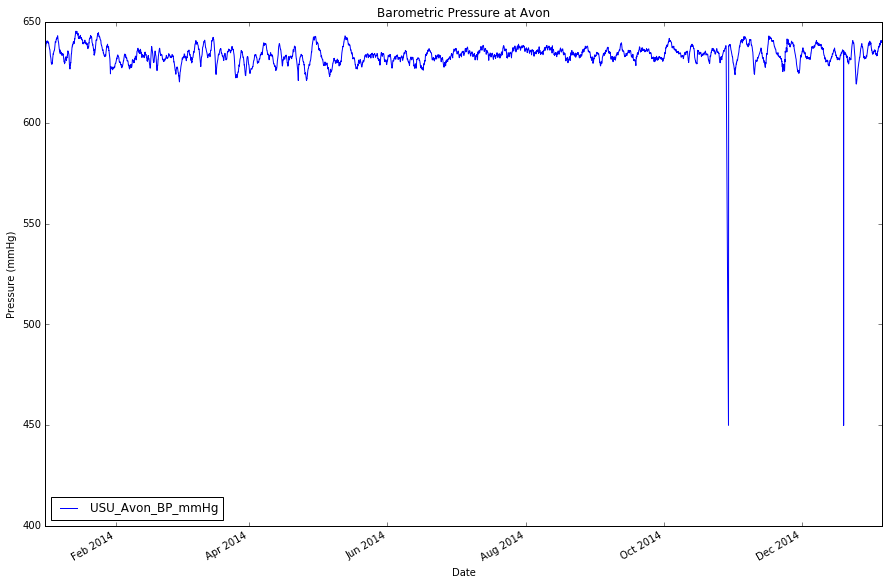

In [31]:
USU_Avon_BP.plot()
plt.title('Barometric Pressure at Avon')
plt.ylabel('Pressure (mmHg)')
plt.xlabel('Date')

In [32]:
USU_Avon_BP = wt.smoother(USU_Avon_BP,'USU_Avon_BP_mmHg',100,4)

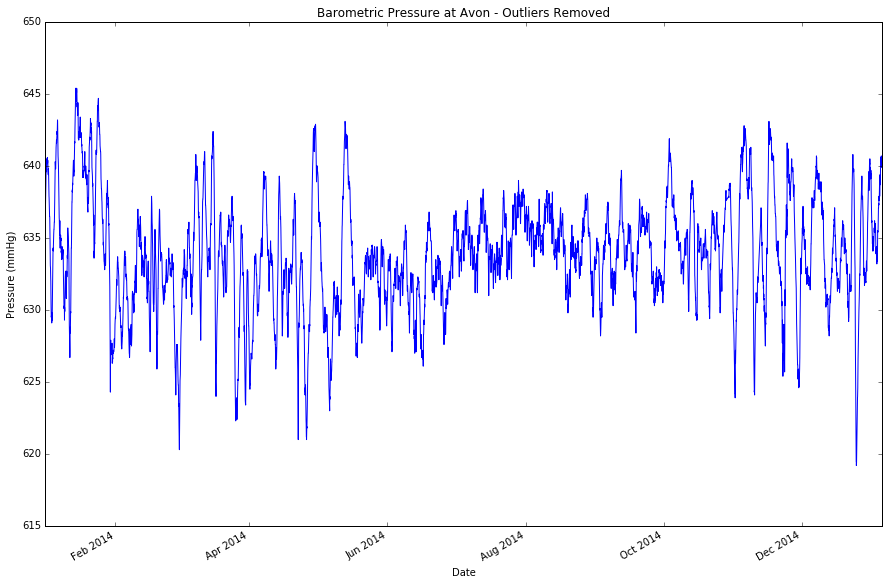

In [33]:
USU_Avon_BP['USU_Avon_BP_mmHg'].plot()
plt.title('Barometric Pressure at Avon - Outliers Removed')
plt.ylabel('Pressure (mmHg)')
plt.xlabel('Date')

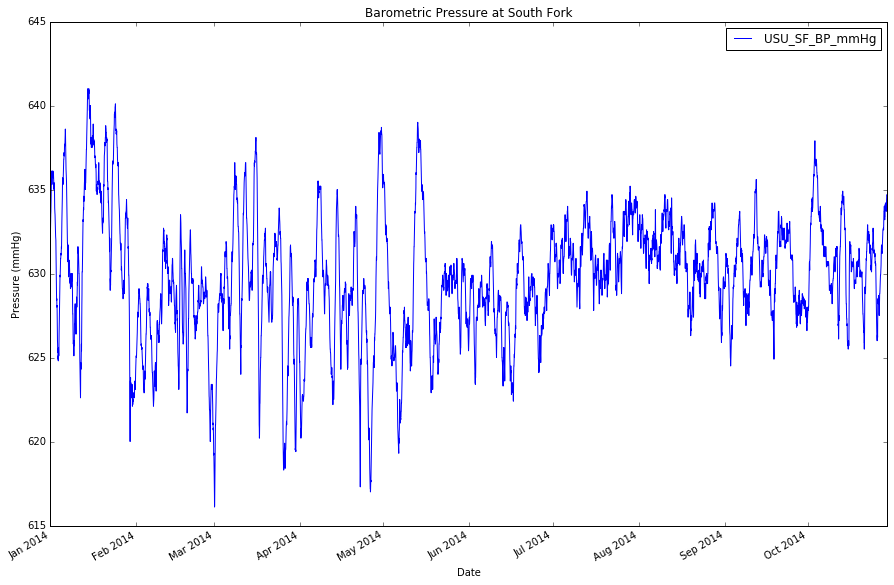

In [34]:
USU_SF_BP.plot()
plt.title('Barometric Pressure at South Fork')
plt.ylabel('Pressure (mmHg)')
plt.xlabel('Date')

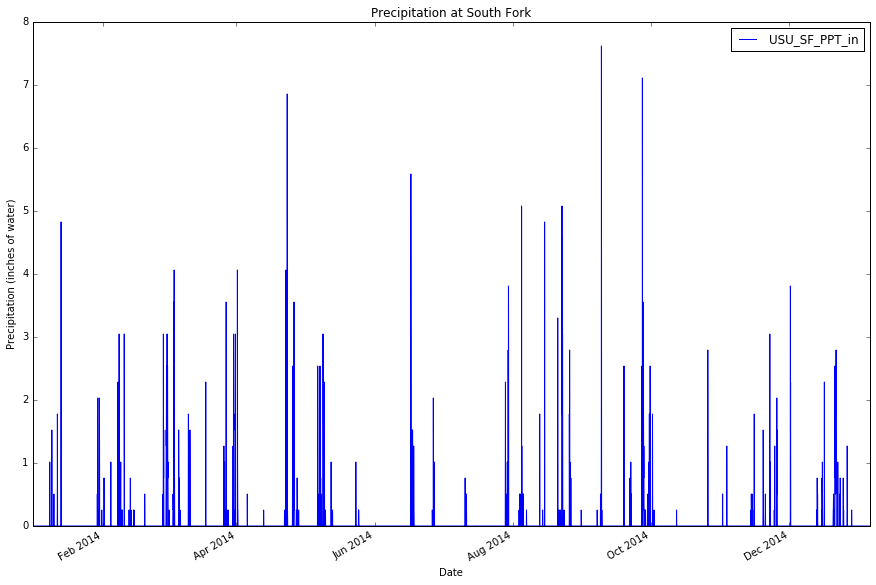

In [35]:
USU_SF_PPT.plot()
plt.title('Precipitation at South Fork')
plt.ylabel('Precipitation (inches of water)')
plt.xlabel('Date')

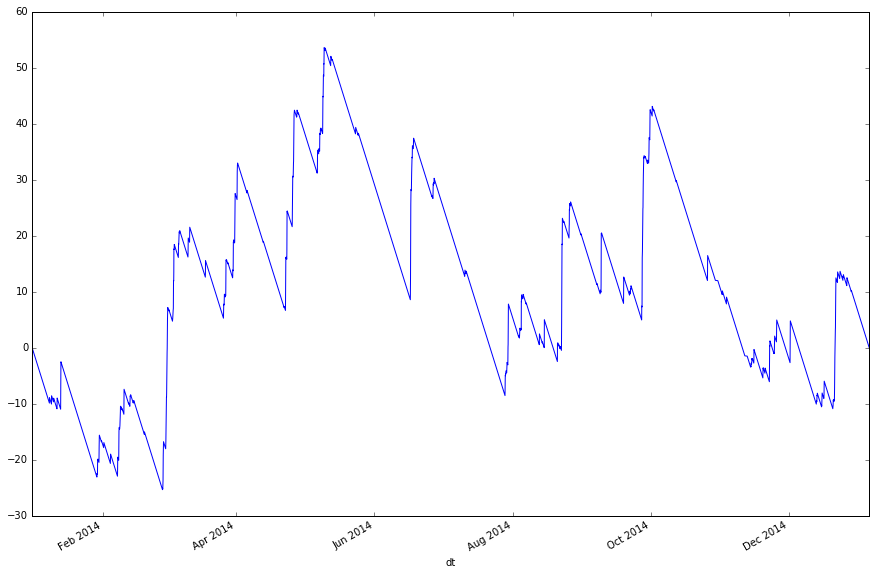

In [36]:
USU_SF_PPT['USU_PPT_CDM']=(USU_SF_PPT['USU_SF_PPT_in']-USU_SF_PPT['USU_SF_PPT_in'].mean()).cumsum()
USU_SF_PPT['USU_PPT_CDM'].plot()

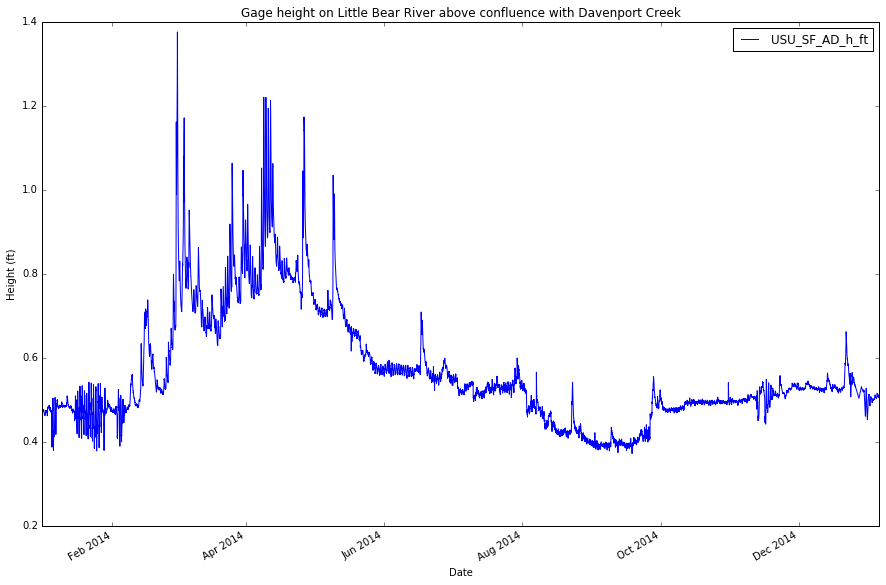

In [37]:
USU_SF_AD.plot()
plt.title('Gage height on Little Bear River above confluence with Davenport Creek')
plt.ylabel('Height (ft)')
plt.xlabel('Date')

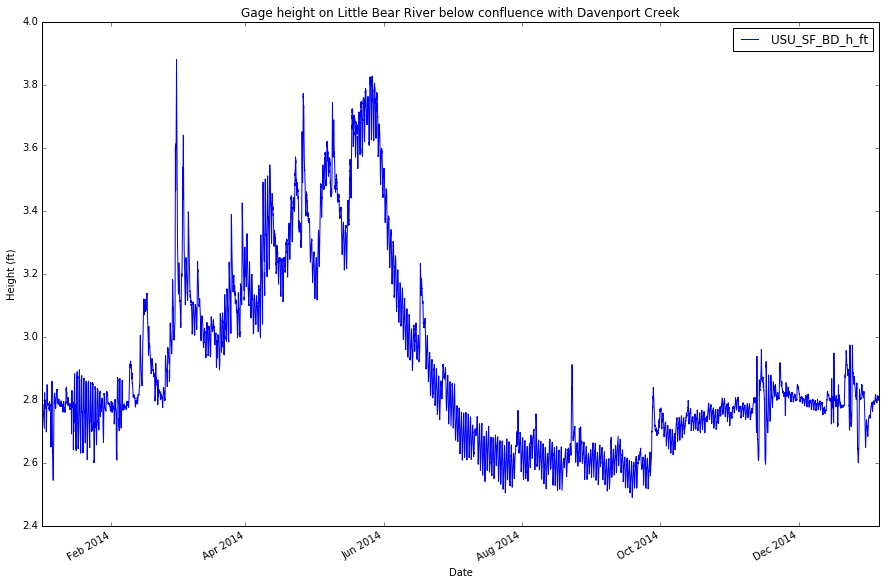

In [38]:
USU_SF_BD.plot()
plt.title('Gage height on Little Bear River below confluence with Davenport Creek')
plt.ylabel('Height (ft)')
plt.xlabel('Date')

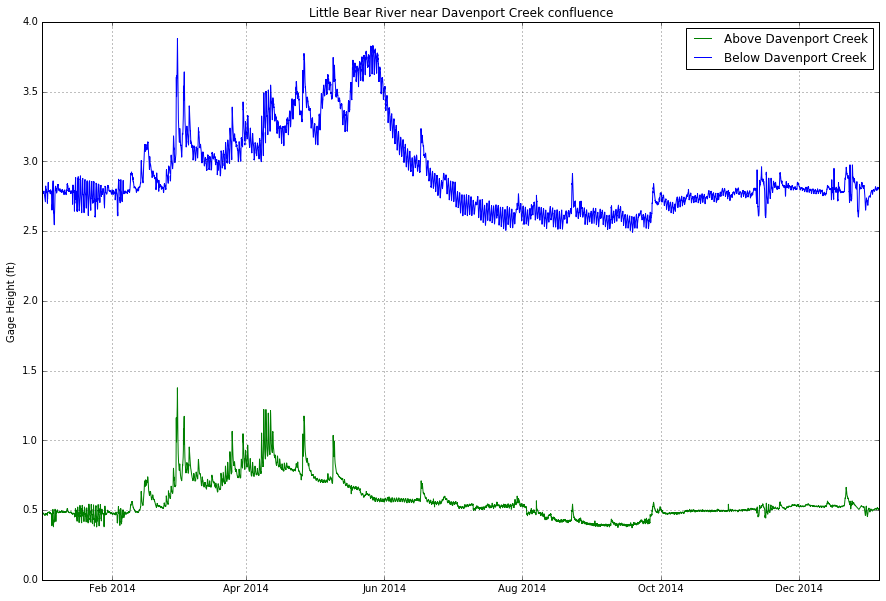

In [39]:
plt.figure()
x1 = USU_SF_AD.index.to_datetime()
y1 = USU_SF_AD['USU_SF_AD_h_ft']

x2 = USU_SF_BD.index.to_datetime()
y2 = USU_SF_BD['USU_SF_BD_h_ft']

plt.figure()
plt.title('Little Bear River near Davenport Creek confluence')
plt.plot(x1,y1,c='g', label='Above Davenport Creek')
plt.plot(x2,y2,c='b', label='Below Davenport Creek')
plt.ylabel('Gage Height (ft)') 
plt.legend(loc=0)
plt.grid()
plt.show()

In [40]:
# Combine imported worksheets into a single dataframe
USU = pd.merge(USU_Avon_BP, USU_SF_BP, left_index=True, right_index=True, how='outer')
USU = pd.merge(USU, USU_SF_PPT,  left_index=True, right_index=True, how='outer')
USU = pd.merge(USU, USU_SF_AD,  left_index=True, right_index=True, how='outer')
USU = pd.merge(USU, USU_SF_BD,  left_index=True, right_index=True, how='outer')

In [41]:
USU = USU.resample('1Min', how='mean')
USU = USU.interpolate(method='time', limit=90)
USU = USU.resample('15Min', how='mean')

In [42]:
del(USU_Avon_BP, USU_SF_PPT, USU_SF_AD, USU_SF_BD)

In [43]:
#USU = USU.drop(['dpUSU_Avon_BP_mmHg', 'maUSU_Avon_BP_mmHg', 'mstUSU_Avon_BP_mmHg'], axis=1)
list(USU.columns.values)

['USU_Avon_BP_mmHg',
 'USU_SF_BP_mmHg',
 'USU_SF_PPT_in',
 'USU_PPT_CDM',
 'USU_SF_AD_h_ft',
 'USU_SF_BD_h_ft']

In [44]:
USUSNOTEL = pd.merge(USU,SNOTEL, left_index=True, right_index=True, how='outer')
Climate = pd.merge(USUSNOTEL, SNODAS, left_index=True, right_index=True, how='outer')

In [45]:
#del (USU,SNOTEL)

## Upper Lefty's Spring

### Importing and Converting Upper Lefty's Spring Data

[To top of page](#top)

This weir was installed by the Powder Mountain Water and Sewer District. The weir has the longest record of monitoring for any of the non-developed sites in the study area. The weir is directly downstream of where the main Lefty's springhead emerges, so contribution from overland flow is negligible. This weir has notable seepage and underflow, and is not as "sharp-crested" as a calibrated steel weir, as it is constructed out of plywood and some type of advertisement board.

Import the transducer data collected by Loughlin Water at Upper Lefty's Spring weir. These data are nonvented and provide values of absolute head, so barometric pressure must be subtracted to determine the water head above the transducer. These data extend from 7/25/2014 12:15 to 12/16/2014 17:45.

The path to the input file can be found in the [data sources](#Data-Sources) section.<a id='leftys'></a>

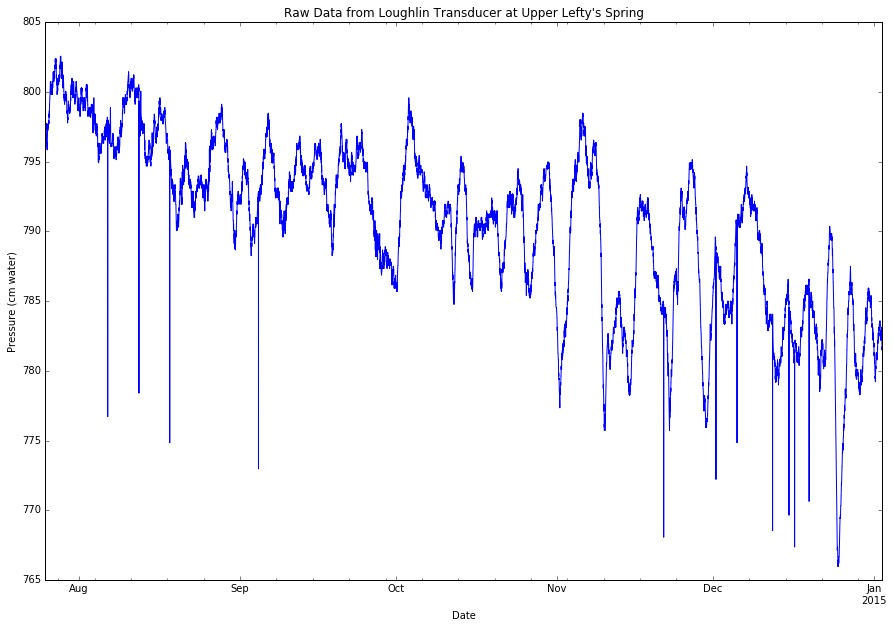

In [46]:
UL_LW = pd.read_csv(Upper_Leftys_Loughlin,
                    index_col=0, skiprows=52, skipfooter=1, parse_dates=True, 
                    names=['dt','UL_LW_p_cm','UL_LW_t_C'], engine='python')
UL_LW['UL_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Raw Data from Loughlin Transducer at Upper Lefty\'s Spring')

Remove obvious outliers created when the transducer was not in the water.

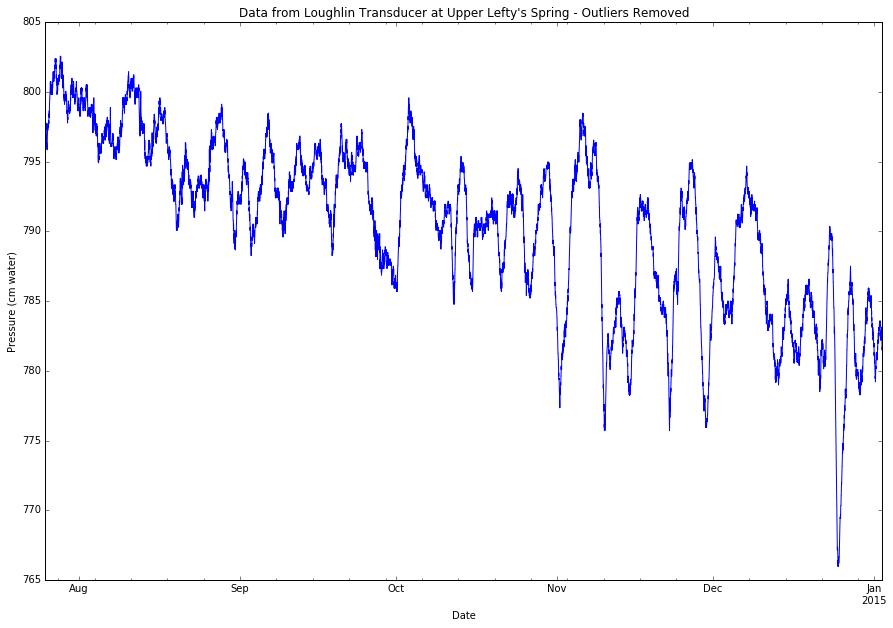

In [47]:
UL_LW = wt.smoother(UL_LW, 'UL_LW_p_cm', 50, 3)
UL_LW['UL_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Data from Loughlin Transducer at Upper Lefty\'s Spring - Outliers Removed')

Import the barometric pressure observations collected by Loughlin Water. The path to the input file can be found in the [data sources](#Data-Sources) section. <a id=leftysbp></a>

In [48]:
UL_BP_LW = pd.read_csv(Upper_Leftys_Barometer_Loughlin, 
                    index_col=0, skiprows=52, skipfooter=1, parse_dates=True, names=['dt','UL_BP_LW_p_cm','UL_BP_LW_t_C'], 
                    engine='python')

Plot the barometric pressure and the nonvented transducer data to make sure they match.

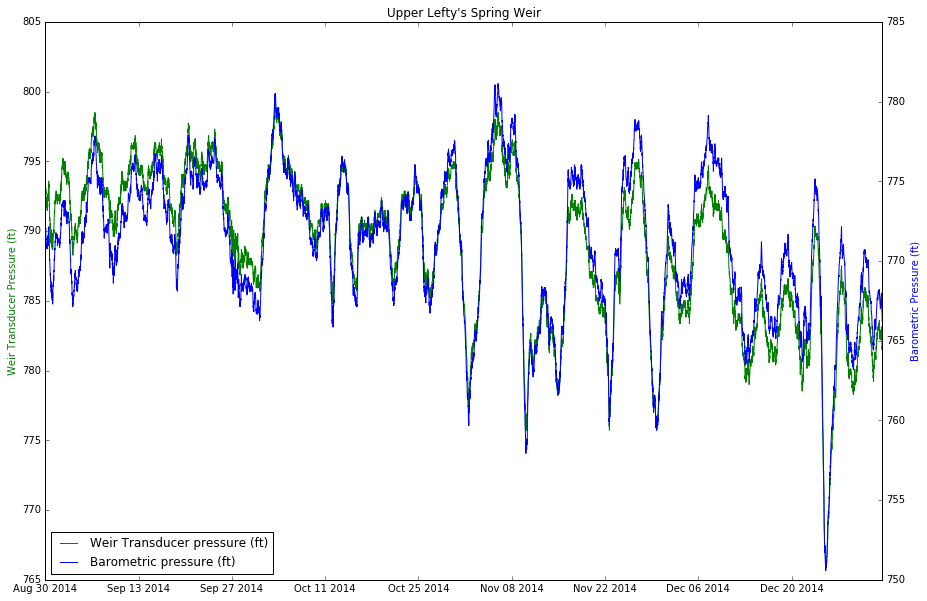

In [49]:
plt.figure()
x1 = UL_LW.index.to_datetime()
y1 = UL_LW['UL_LW_p_cm']

x2 = UL_BP_LW.index.to_datetime()
y2 = UL_BP_LW['UL_BP_LW_p_cm']

fig, ax1 = plt.subplots()
plt.title('Upper Lefty\'s Spring Weir')
ax2 = ax1.twinx()
ax1.plot(x1,y1,c='g',label='Weir Transducer pressure (ft)')
ax1.set_xlim(left='8/30/2014',right=x1[-1])
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='g') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x2,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

Import the vented transducer data collected by Miranda Menzies and provided by John Files. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=leftysfiles></a>

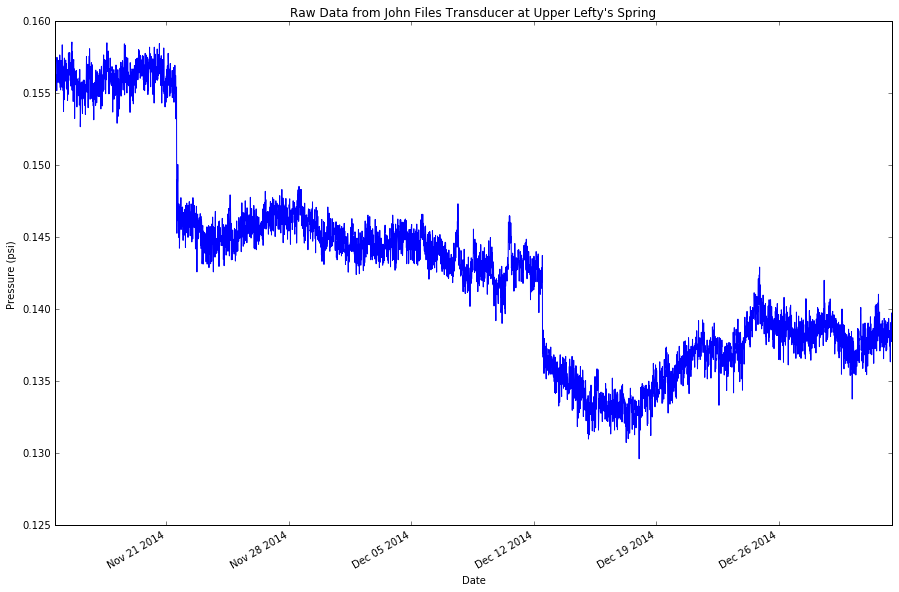

In [50]:
UL_JF = pd.read_csv(Upper_Leftys_John_Files, 
                     index_col=0, skiprows=91, skipfooter=1, usecols=[0,2,3], parse_dates=True, 
                     names=['dt','UL_JF_p_PSI','UL_JF_t_C'], engine='python')
#first 14 values are out of water
UL_JF = UL_JF[14:]
UL_JF['UL_JF_p_PSI'].plot()
plt.ylabel('Pressure (psi)')
plt.xlabel('Date')
plt.title('Raw Data from John Files Transducer at Upper Lefty\'s Spring')

In [51]:
UL_JF1 = wt.jumpfix(UL_JF,'UL_JF_p_PSI',0.005)

                     UL_JF_p_PSI  UL_JF_t_C  deltaUL_JF_p_PSI     cumul
dt                                                                     
2014-11-21 14:11:09     0.145681   6.295593         -0.009745 -0.009745
2014-12-12 11:56:09     0.137371   6.258392         -0.006363 -0.016108


c:\python27\arcgis10.3\lib\site-packages\wellapplication\transport.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  jump['cumul'] = jump.loc[:,'delta'+meas].cumsum()


The data have two tears in them, due to adjustments of the transducer locations over time. To accomodate, we search for these tears and use a for statement to remove them.

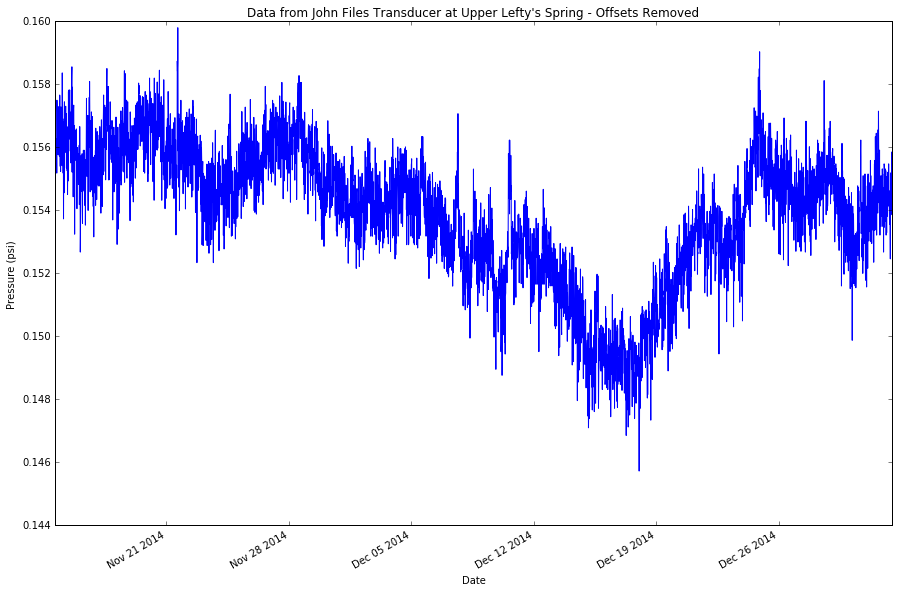

In [52]:
UL_JF1['UL_JF_p_PSI'].plot()
plt.ylabel('Pressure (psi)')
plt.xlabel('Date')
plt.title('Data from John Files Transducer at Upper Lefty\'s Spring - Offsets Removed')

These data were collected every 15 minutes, but at odd times that do not align with the Loughlin data, so they have to be resampled and interpolated so that times are consistent and proper comparisons can be made.

In [53]:
UL_JF = UL_JF.resample('1Min', how='mean')
UL_JF = UL_JF.interpolate(method='time', limit=90)
UL_JF = UL_JF.resample('15Min', how='mean')

Merge the datasets to ease calculation, comparison, and visualization.

In [54]:
Leftys = pd.merge(UL_LW, UL_JF, left_index=True, right_index=True, how='outer')
Leftys = pd.merge(Leftys, UL_BP_LW, left_index=True, right_index=True, how='outer')

#Leftys = Leftys[pd.datetime(2014,7,25,12,15):pd.datetime(2014,12,16,17,45)]

Delete old dataframes.

In [55]:
#del (UL_LW,UL_JF)

Import the manual measurements collected at the weir. Import the depth of water at the v. Add the average difference measured between the v-depth and the actual depth (h), which is 0.16 inches. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=leftysman></a>

In [56]:
UL_manual = pd.read_excel(Upper_Leftys_Manual, 'Leftys', index_col=0, skiprows=1,
                          parse_cols=[0,1,2,3], names=['date', 'UL_vdepth_in', 'UL_depth_in', 'UL_bucket_Q_gpm'])
UL_manual['UL_vdepth_ft'] = UL_manual['UL_vdepth_in']/12
UL_manual = UL_manual.sort_index()
UL_manual = UL_manual[UL_manual.index.to_datetime()>pd.datetime(2014,7,25)]

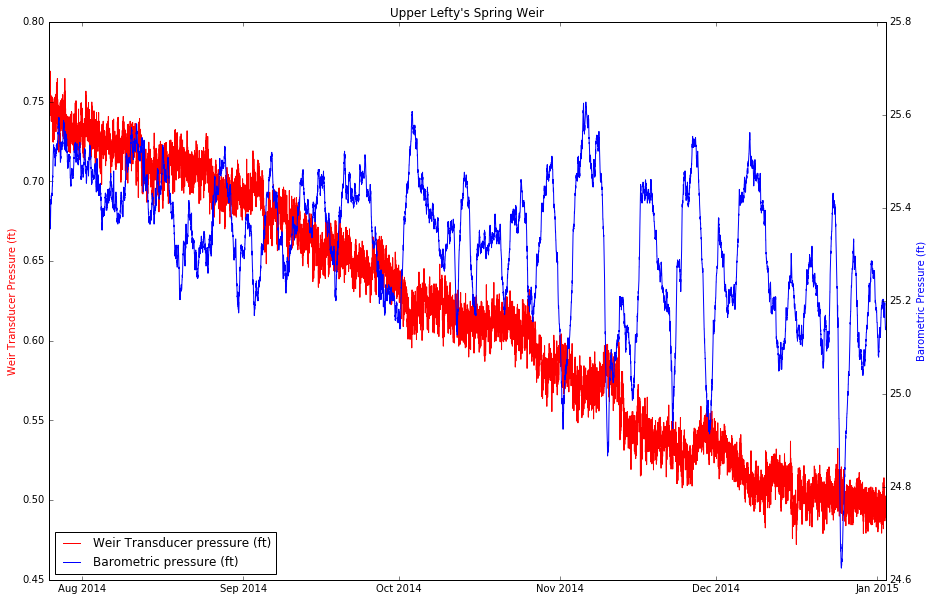

In [57]:
Leftys['UL_LW_p_ft'] =  (Leftys['UL_LW_p_cm'] - Leftys['UL_BP_LW_p_cm'])*0.0328084
Leftys['UL_BP_LW_p_ft'] = Leftys['UL_BP_LW_p_cm']*0.0328084

x = Leftys.index.to_datetime()
y1 = Leftys['UL_LW_p_ft']
y2 = Leftys['UL_BP_LW_p_ft']

fig, ax1 = plt.subplots()
plt.title('Upper Lefty\'s Spring Weir')
ax2 = ax1.twinx()
ax1.plot(x,y1,c='r',label='Weir Transducer pressure (ft)')
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='r') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

We perform a moving average difference between the manual measurements and the transducer measurements to determine the calibration offset.  This is the difference in height from the transducer measure point and the bottom of the weir orifice.

In [58]:
meanDiff = rollmeandiff(UL_manual,'UL_vdepth_ft',Leftys,'UL_LW_p_ft',5)
print meanDiff
Leftys['UL_LW_h_ft'] = Leftys['UL_LW_p_ft'] + meanDiff

-0.365


We repeat the average difference for the John Files data. First the units of PSI must be converted to feet of water.

In [59]:
Leftys['UL_JF_p_ft'] =  Leftys['UL_JF_p_PSI']*2.307
meanDiff = rollmeandiff(UL_manual,'UL_vdepth_ft',Leftys,'UL_JF_p_ft',5)
print meanDiff
Leftys['UL_JF_h_ft'] = Leftys['UL_JF_p_ft'] + meanDiff

-0.164


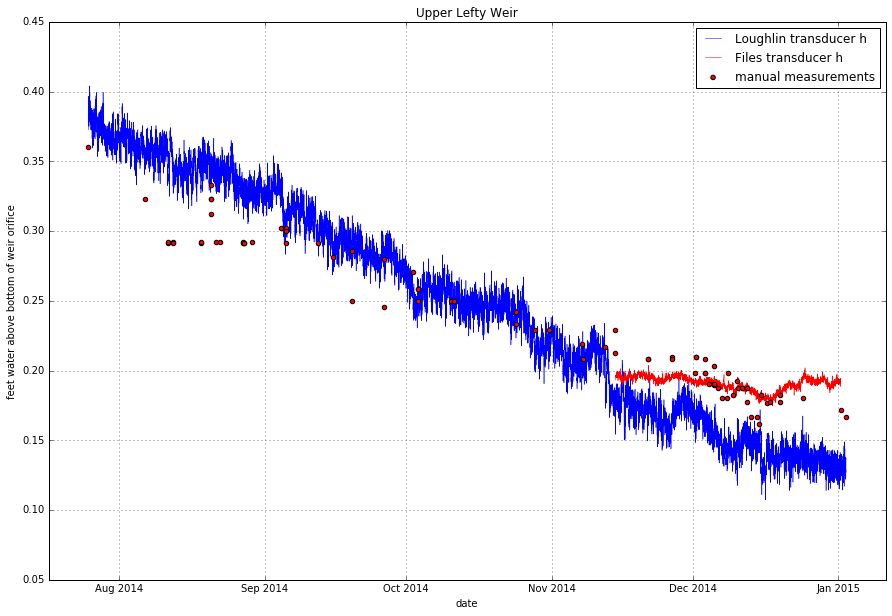

In [60]:
plt.figure()

x = Leftys.index.to_datetime()
y = Leftys['UL_LW_h_ft']

x1 = UL_manual.index.to_datetime()
y1 = UL_manual['UL_vdepth_ft']

y2 = Leftys['UL_JF_h_ft']

plt.plot(x, y, zorder=1, c='blue', linewidth=0.5, label='Loughlin transducer h')
plt.plot(x, y2, zorder=2, c='red', linewidth=0.5, label='Files transducer h')
plt.scatter(x1, y1, c='red', zorder=3, label='manual measurements')
plt.title('Upper Lefty Weir')
plt.ylabel('feet water above bottom of weir orifice')
plt.xlabel('date')
plt.grid()
plt.legend(scatterpoints=1)

Once the transducer data were aligned with manual readings, we converted the height of water above the bottom of the weir orifice to discharge in both gpm and cfs.

To do this, we used equations from: U.S. Bureau of Reclamation, 2001, Water Measurement Manual - A water resources technical publication: online, http://www.usbr.gov/pmts/hydraulics_lab/pubs/wmm/.

For 90$^\circ$ v-notch weirs, the equation to calculate discharge from h is:
$$
Q= 1122\cdot h^{\frac{5}{2}}
$$
<ul>
  <li>h = feet above bottom of weir orifice</li>
  <li>Q = discharge in gpm</li>
</ul>

In [61]:
Leftys['UL_LW_Q_gpm'] = 1122*Leftys['UL_LW_h_ft']**(2.5)
Leftys['UL_LW_Q_cfs'] = 0.00222800926*Leftys['UL_LW_Q_gpm']
Leftys['UL_JF_Q_gpm'] = 1122*Leftys['UL_JF_h_ft']**(2.5)
Leftys['UL_JF_Q_cfs'] = 0.00222800926*Leftys['UL_JF_Q_gpm']

Plot the resulting discharge values and the manual discharge measurements to see how they compare. 

0.546431022076
0.380427494236
0.563257237278


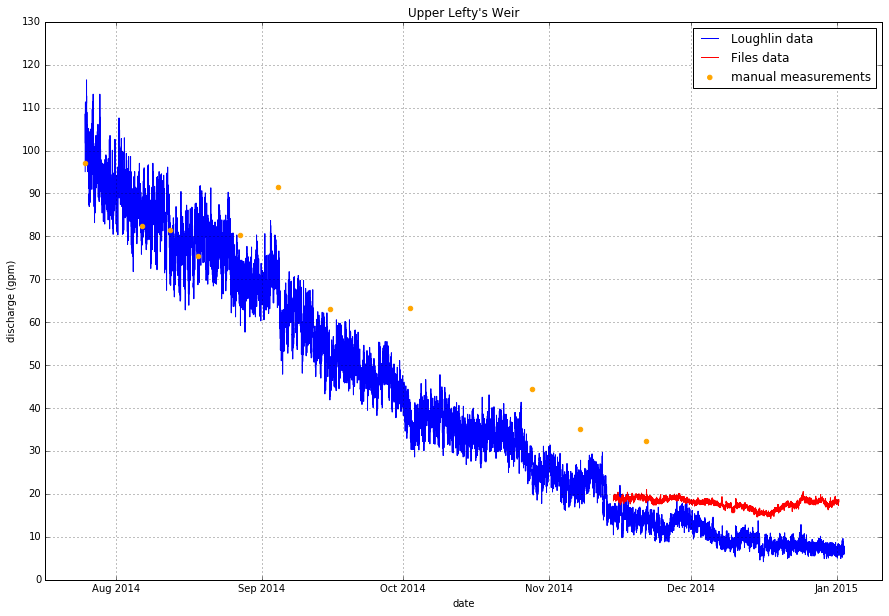

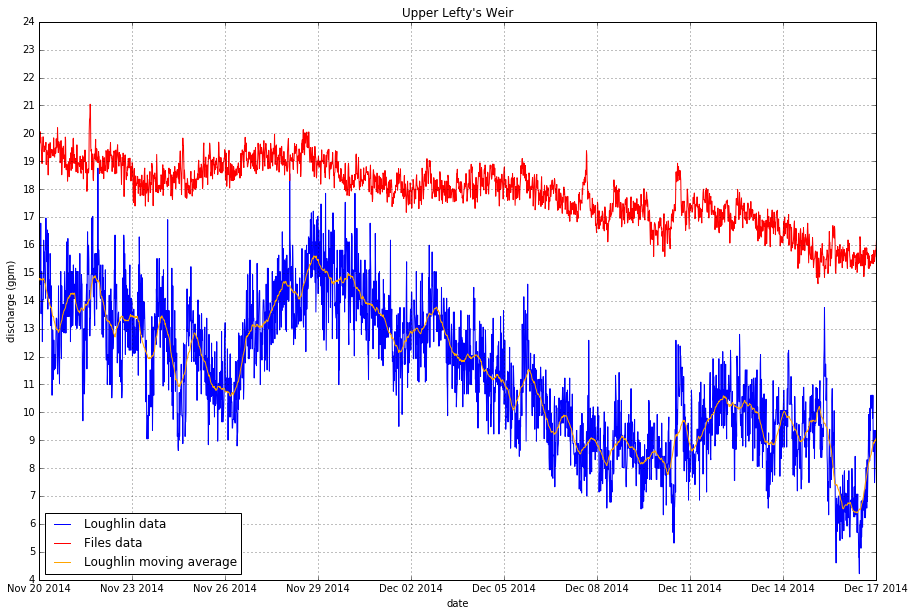

In [62]:
plt.figure()
x = Leftys.index.to_datetime()
y1 = Leftys['UL_LW_Q_gpm']
y2 = Leftys['UL_JF_Q_gpm']
x3 = UL_manual.index.to_datetime()
y3 = UL_manual['UL_bucket_Q_gpm']

print y1.corr(y2, method='pearson')
print y1.corr(y2, method='kendall')
print y1.corr(y2, method='spearman')

y4 = pd.rolling_mean(Leftys['UL_LW_Q_gpm'], window=48, center=True)

plt.plot(x,y1, color='blue', zorder=1, label='Loughlin data')
plt.plot(x,y2, color='red', zorder=2, label='Files data')
plt.scatter(x3,y3, color='orange', zorder=3, label='manual measurements' )
plt.title('Upper Lefty\'s Weir')
plt.ylabel('discharge (gpm)')
plt.xlabel('date')
plt.grid()
plt.yticks(np.arange(0, 140.0, 10))
plt.ylim(0.0, 130.0)
plt.legend( scatterpoints=1)

plt.figure()
plt.plot(x,y1, color='blue', zorder=1, label='Loughlin data')
plt.plot(x,y2, color='red', zorder=2, label='Files data')
plt.plot(x,y4, color='orange', zorder=3, label='Loughlin moving average')
plt.title('Upper Lefty\'s Weir')
plt.ylabel('discharge (gpm)')
plt.xlabel('date')
plt.grid()
plt.yticks(np.arange(0, 40.0, 1))
plt.ylim(4.0, 24.0)
plt.xlim('11/20/2014','12/17/2014')
plt.legend(loc=3, scatterpoints=1)

In [63]:
UL_LW_old = pd.read_excel(Upper_Leftys_Loughlin_old,'Lefty Flow',index_col=0, names=['date', 'UL_LW_Q_gpm', 'UL_LW_ppt_in'])

In [64]:
UL_LW_old = UL_LW_old[UL_LW_old.index < datetime(2014,4,1)]

In [65]:
Leftys = pd.concat([Leftys, UL_LW_old])
Leftys.sort_index(inplace=True)

In [66]:
#Leftys = Leftys.drop(['UL_LW_p_cm','dpUL_LW_p_cm', 'maUL_LW_p_cm', 'mstUL_LW_p_cm', 'UL_JF_p_PSI', 'UL_JF_dp_PSI', 'UL_BP_LW_p_cm',
 #                    'UL_LW_p_ft','UL_LW_h_ft', 'UL_JF_p_ft', 'UL_JF_h_ft'],axis=1)

In [67]:
Leftys = nodups(Leftys, Climate)

In [68]:
list(Leftys.columns.values)

['UL_BP_LW_p_cm',
 'UL_BP_LW_p_ft',
 'UL_BP_LW_t_C',
 'UL_JF_Q_cfs',
 'UL_JF_Q_gpm',
 'UL_JF_t_C',
 'UL_LW_Q_cfs',
 'UL_LW_Q_gpm',
 'UL_LW_t_C']

In [69]:
All = pd.merge(Climate, Leftys, right_index=True, left_index=True, how='outer')

In [70]:
list(All.columns.values)

['USU_Avon_BP_mmHg',
 'USU_SF_BP_mmHg',
 'USU_SF_PPT_in',
 'USU_PPT_CDM',
 'USU_SF_AD_h_ft',
 'USU_SF_BD_h_ft',
 'Site Id',
 'WTEQ.I-1 (in) ',
 'PREC.I-1 (in) ',
 'TOBS.I-1 (degC) ',
 'SNWD.I-1 (in) ',
 'SMS.I-1:-2 (pct)  (silt)',
 'SMS.I-1:-8 (pct)  (silt)',
 'SMS.I-1:-20 (pct)  (silt)',
 'STO.I-1:-2 (degC) ',
 'STO.I-1:-8 (degC) ',
 'STO.I-1:-20 (degC) ',
 'SAL.I-1:-2 (gram) ',
 'SAL.I-1:-8 (gram) ',
 'SAL.I-1:-20 (gram) ',
 'RDC.I-1:-2 (unit) ',
 'RDC.I-1:-8 (unit) ',
 'RDC.I-1:-20 (unit) ',
 'BATT.I-1 (volt) ',
 'Unnamed: 20',
 'SForkWolfCreek',
 'OtherQuartzite',
 'NorthForkofWolfCreek',
 'LeftysCreek',
 'JamesPeakFork',
 'HiddenLakeFork',
 'CobabeCreek',
 'NorthSide',
 'SouthSide',
 'UL_BP_LW_p_cm',
 'UL_BP_LW_p_ft',
 'UL_BP_LW_t_C',
 'UL_JF_Q_cfs',
 'UL_JF_Q_gpm',
 'UL_JF_t_C',
 'UL_LW_Q_cfs',
 'UL_LW_Q_gpm',
 'UL_LW_t_C']

### Comparing the Data

[To top of page](#top)

The two datasets are definately different in tems of the amount of small-scale variability.  The Loughlin data show greater variability, perhaps due to an incomplete removal of barometric pressure effects.

                            OLS Regression Results                            
Dep. Variable:            UL_JF_Q_gpm   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     1954.
Date:                Tue, 09 Feb 2016   Prob (F-statistic):               0.00
Time:                        09:20:21   Log-Likelihood:                -6255.0
No. Observations:                4593   AIC:                         1.251e+04
Df Residuals:                    4591   BIC:                         1.253e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          15.7962      0.050    315.306      

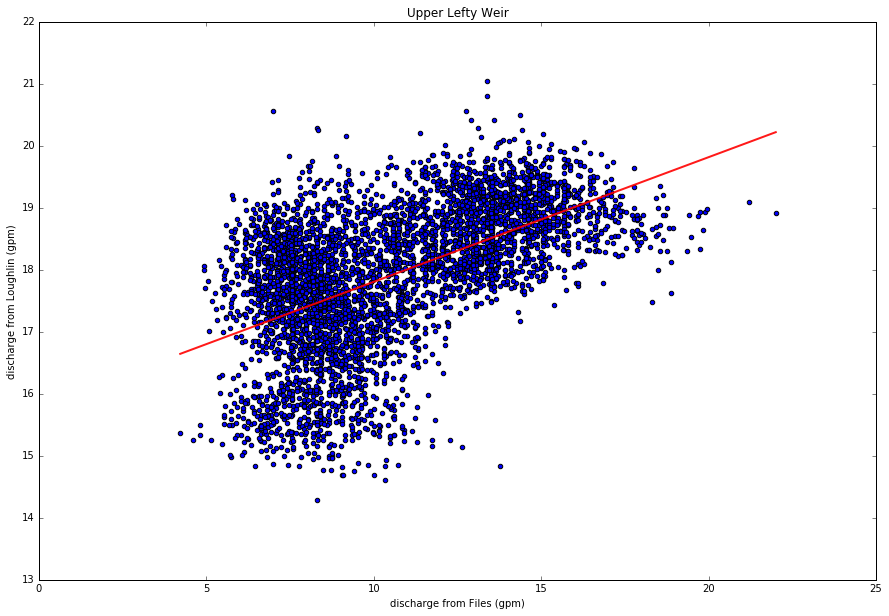

In [71]:
LeftyShortJF = Leftys[np.isfinite(Leftys)]
LeftyShortJF =LeftyShortJF[np.isfinite(LeftyShortJF['UL_LW_Q_gpm'])]
LeftyShortJF =LeftyShortJF[np.isfinite(LeftyShortJF['UL_JF_Q_gpm'])]

x0 = LeftyShortJF['UL_LW_Q_gpm']
x = sm.add_constant(x0)
y = LeftyShortJF['UL_JF_Q_gpm']

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Upper Lefty Weir')
plt.ylabel('discharge from Loughlin (gpm)')
plt.xlabel('discharge from Files (gpm)')

2014-07-25 12:30:00
2015-01-02 14:45:00
                            OLS Regression Results                            
Dep. Variable:            UL_LW_Q_gpm   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                 3.218e+05
Date:                Tue, 09 Feb 2016   Prob (F-statistic):               0.00
Time:                        09:20:22   Log-Likelihood:                -42217.
No. Observations:               13546   AIC:                         8.444e+04
Df Residuals:                   13544   BIC:                         8.445e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       

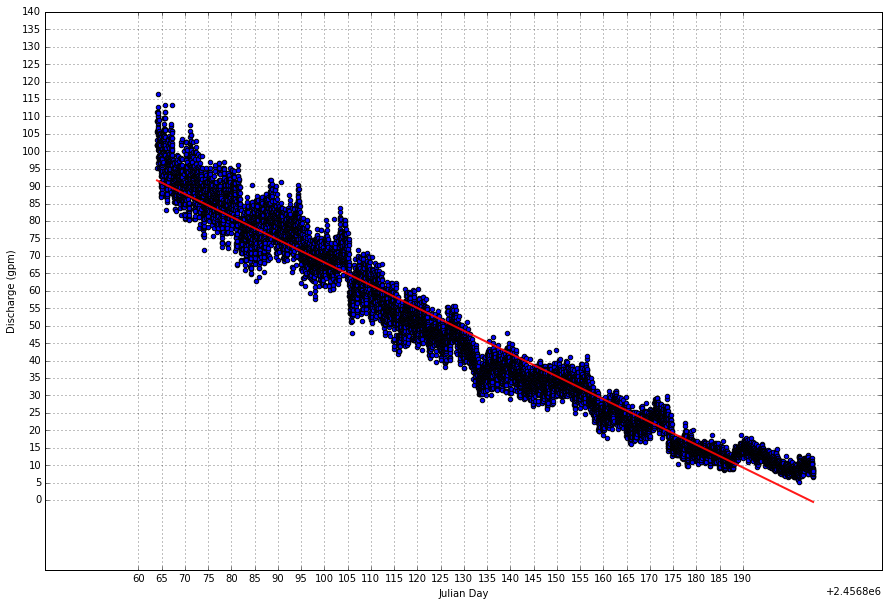

In [72]:
LeftyShortJF = Leftys[(np.isfinite(Leftys['UL_LW_Q_gpm']))&(Leftys.index.to_datetime()>pd.datetime(2014,1,20))]

print(min(LeftyShortJF.index))
print(max(LeftyShortJF.index))

x0 = LeftyShortJF.index.to_julian_date()[:-20*24*4]
x = sm.add_constant(x0)
y = LeftyShortJF['UL_LW_Q_gpm'][:-20*24*4]

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')
plt.xlabel('Julian Day')
plt.ylabel('Discharge (gpm)')
#plt.xlim(2456860,2456990)
plt.xticks(np.arange(2456860,2456995, 5))
plt.yticks(np.arange(0,145, 5))
plt.grid()

The long-term seasonal trend in the transducer data show a decrease of discharge of 0.72 gallons per minute per day. The decline in discharge is not perfectly linear, and tapers off as time progresses.

2673
2673
                            OLS Regression Results                            
Dep. Variable:            UL_JF_Q_gpm   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     3536.
Date:                Tue, 09 Feb 2016   Prob (F-statistic):               0.00
Time:                        09:20:23   Log-Likelihood:                -2169.8
No. Observations:                2673   AIC:                             4344.
Df Residuals:                    2671   BIC:                             4355.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       1.917e+05   3222.816     59.47

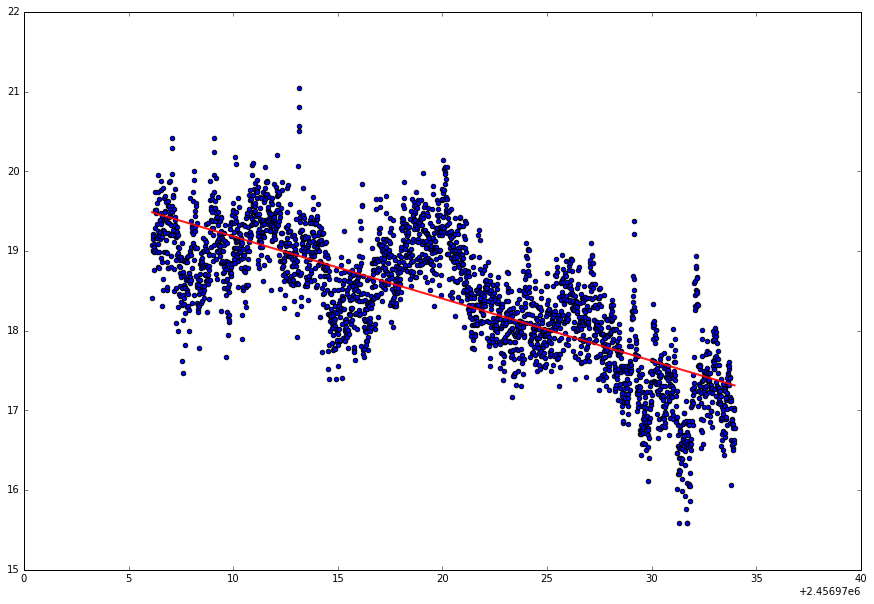

In [73]:
LeftyShortJF = Leftys[np.isfinite(Leftys['UL_JF_Q_gpm'])]

x0 = LeftyShortJF.index.to_julian_date()[:-20*24*4]
x = sm.add_constant(x0)
y = LeftyShortJF['UL_JF_Q_gpm'][:-20*24*4]

print len(x0)
print len(y)

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

In [74]:
#del (Climate,Leftys,LeftyShortJF)

## Lower Lefty's Spring

### Importing and Converting Lower Lefty's Spring Data

[To top of page](#top)

Import the transducer data collected by Loughlin Water at Upper Lefty's Spring weir. These data are nonvented and provide values of absolute head, so barometric pressure must be subtracted to determine the water head above the transducer. These data extend from 12/3/2014 15:30 to 12/19/2014 11:45. The path to the input file can be found in the [data sources](#Data-Sources) section. <a id=lower></a>

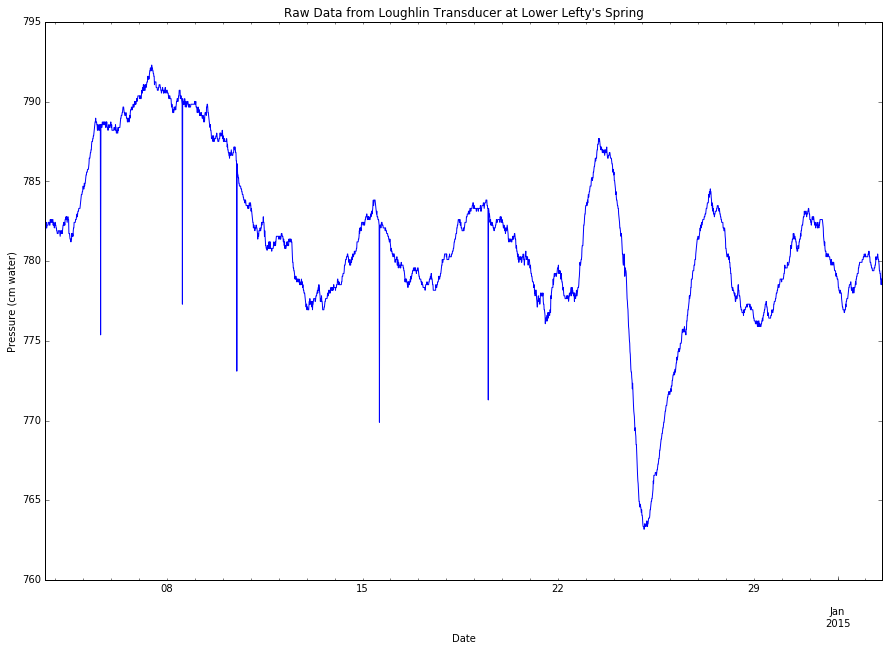

In [75]:
LL_LW = pd.read_csv(Lower_Leftys_Loughlin,
                    index_col=0, skiprows=54, skipfooter=1, parse_dates=True, 
                    names=['dt','LL_LW_p_cm','LL_LW_t_C'], engine='python')
LL_LW['LL_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Raw Data from Loughlin Transducer at Lower Lefty\'s Spring')

Remove obvious outliers created when the transducer was not in the water.

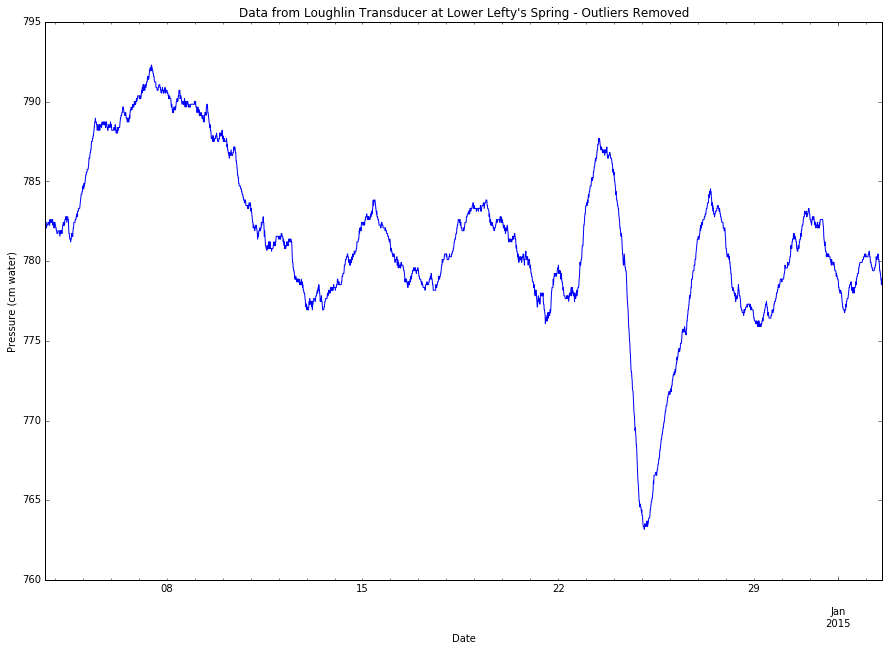

In [76]:
LL_LW = wt.smoother(LL_LW, 'LL_LW_p_cm', 50, 3)
LL_LW['LL_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Data from Loughlin Transducer at Lower Lefty\'s Spring - Outliers Removed')

Import the Upper Leftys barometric pressure data to remove barometric influence from the weir transducer data. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=leftysbp1></a>

In [77]:
UL_BP_LW = pd.read_csv(Upper_Leftys_Barometer_Loughlin, 
                    index_col=0, skiprows=52, skipfooter=1, parse_dates=True, names=['dt','UL_BP_LW_p_cm','UL_BP_LW_t_C'], 
                    engine='python')

Plot the barometric pressure and the nonvented transducer data to make sure they match.

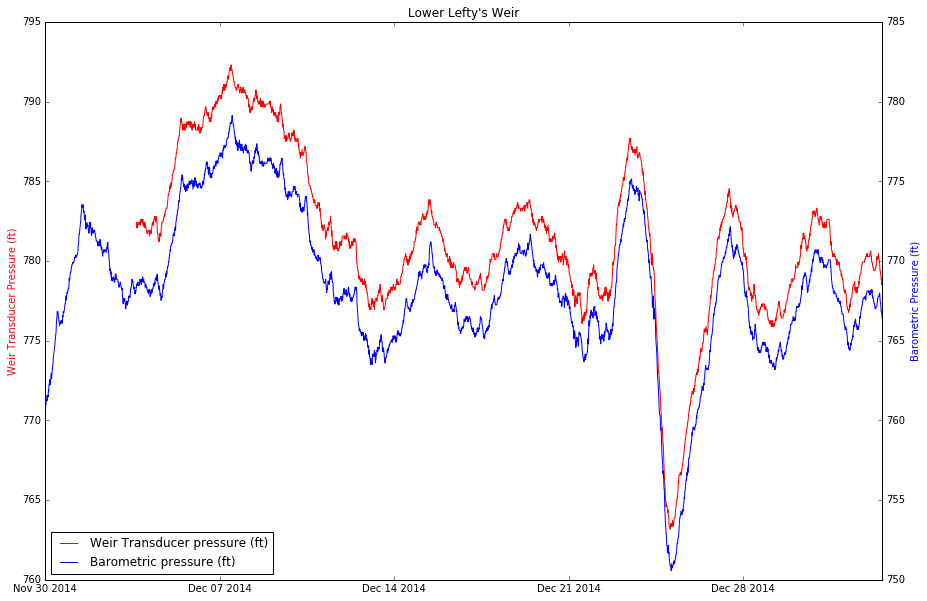

In [78]:
plt.figure()
x1 = LL_LW.index.to_datetime()
y1 = LL_LW['LL_LW_p_cm']

x2 = UL_BP_LW.index.to_datetime()
y2 = UL_BP_LW['UL_BP_LW_p_cm']

fig, ax1 = plt.subplots()
plt.title('Lower Lefty\'s Weir')
ax2 = ax1.twinx()
ax1.plot(x1,y1,c='r',label='Weir Transducer pressure (ft)')
ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='r') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x2,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

In [79]:
LowLeftys = pd.merge(LL_LW, UL_BP_LW, left_index=True, right_index=True, how='outer')
LowLeftys['LL_LW_p_ft'] =(LowLeftys['LL_LW_p_cm'] - LowLeftys['UL_BP_LW_p_cm'])*0.0328084
LowLeftys['UL_BP_LW_p_ft'] = LowLeftys['UL_BP_LW_p_cm']*0.0328084

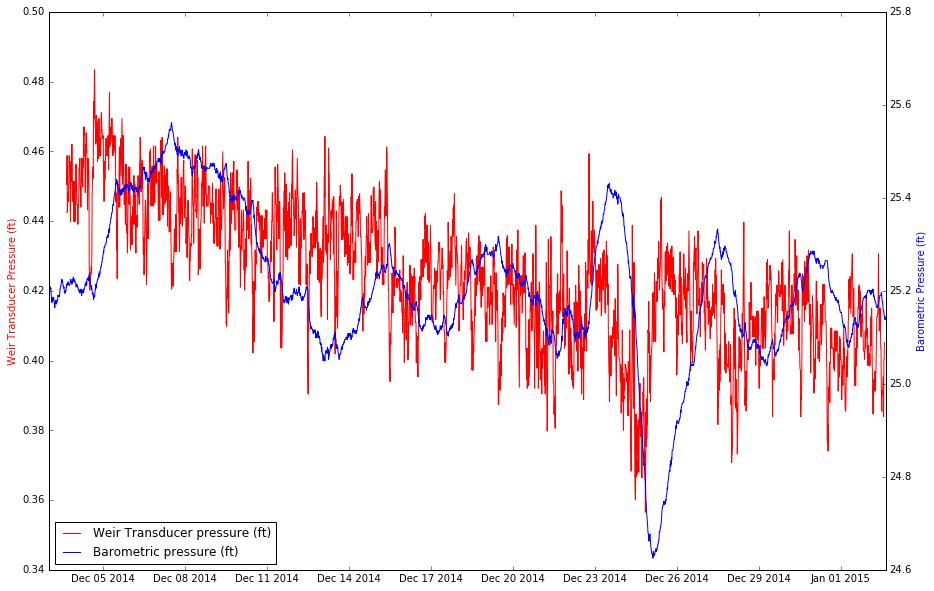

In [80]:
x = LowLeftys.index.to_datetime()
y1 = LowLeftys['LL_LW_p_ft']
y2 = LowLeftys['UL_BP_LW_p_ft']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x,y1,c='r',label='Weir Transducer pressure (ft)')
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='r') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_xlim('12/3/2014',LowLeftys.index.to_datetime()[-1])
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

Import data from John Files. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=fileslower></a>

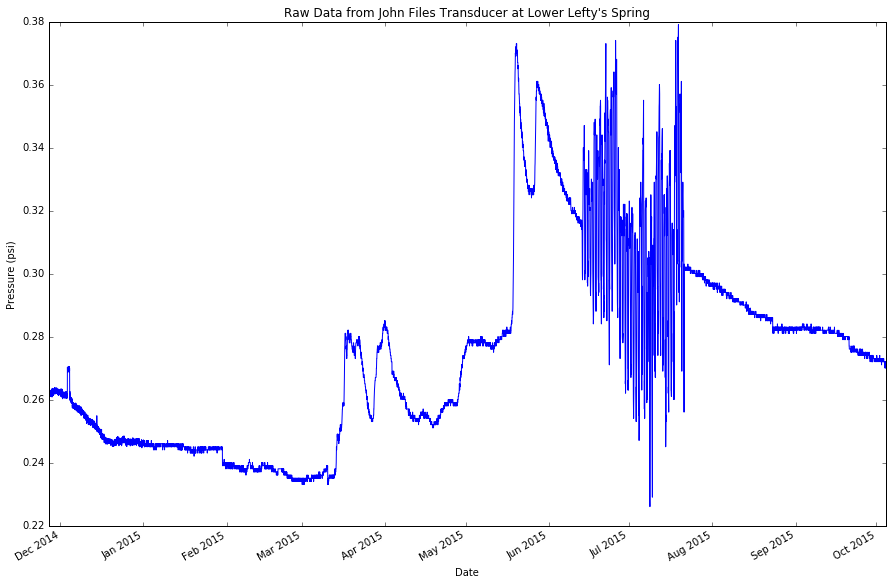

In [81]:
LL_JF = pd.read_csv(Lower_Leftys_John_Files, 
                     index_col=0, skiprows=91, skipfooter=1, usecols=[0,2,3], parse_dates=True, 
                     names=['dt','LL_JF_p_PSI','LL_JF_t_C'], engine='python')
LL_JF2 = pd.read_csv(Lower_Leftys_John_Files2,
                     index_col=0, skiprows=74, skipfooter=1, usecols=[0,2,3], parse_dates=True, 
                     names=['dt','LL_JF_p_PSI','LL_JF_t_C'], engine='python')
LL_JF3 = pd.read_csv(Lower_Leftys_John_Files3,
                     index_col=0, skiprows=79, skipfooter=1, usecols=[0,2,3], parse_dates=True, 
                     names=['dt','LL_JF_p_PSI','LL_JF_t_C'], engine='python')



LL_JF = pd.concat([LL_JF,LL_JF2,LL_JF3])
LL_JF.drop_duplicates(inplace=True)
LL_JF.sort_index(inplace=True)
plt.figure()
LL_JF['LL_JF_p_PSI'].plot()
#LL_JF2['LL_JF_p_PSI'].plot()
plt.ylabel('Pressure (psi)')
plt.xlabel('Date')
plt.title('Raw Data from John Files Transducer at Lower Lefty\'s Spring')

In [82]:
LL_JF1 = LL_JF[(LL_JF.index < datetime(2015,6,10))]
LL_JF1 = wt.jumpfix(LL_JF1,'LL_JF_p_PSI',0.005)
LL_JF2 = LL_JF[(LL_JF.index > datetime(2015,7,25))]
LL_JF2 = wt.jumpfix(LL_JF2,'LL_JF_p_PSI',0.003)
LL_JF = pd.concat([LL_JF1,LL_JF2])

c:\python27\arcgis10.3\lib\site-packages\wellapplication\transport.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['delta'+meas] = df.loc[:,meas].diff()
c:\python27\arcgis10.3\lib\site-packages\wellapplication\transport.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['newVal'] = df.loc[:,meas]
c:\python27\arcgis10.3\lib\site-packages\pandas\core\indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

                     LL_JF_p_PSI  LL_JF_t_C  deltaLL_JF_p_PSI     cumul
dt                                                                     
2014-12-03 15:50:18     0.269009   4.902679          0.007766  0.007766
2014-12-04 11:50:18     0.261264   5.033936         -0.008671 -0.000905
2015-01-30 10:52:10     0.239000   5.009000         -0.005000 -0.005905
2015-03-10 15:52:10     0.234000   5.780000         -0.005000 -0.010905
2015-05-18 21:52:00     0.311000   5.028000          0.006000 -0.004905
2015-05-18 22:52:00     0.317000   5.066000          0.006000  0.001095
2015-05-18 23:52:00     0.323000   5.078000          0.006000  0.007095
2015-05-19 00:52:00     0.330000   5.094000          0.007000  0.014095
2015-05-19 01:52:00     0.335000   5.103000          0.005000  0.019095
2015-05-19 03:52:00     0.346000   5.108000          0.007000  0.026095
                     LL_JF_p_PSI  LL_JF_t_C  deltaLL_JF_p_PSI  cumul
dt                                                                 

c:\python27\arcgis10.3\lib\site-packages\wellapplication\transport.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[meas]=df['newVal']


In [83]:
LL_JF = LL_JF[(LL_JF.index < datetime(2015,6,10))|(LL_JF.index > datetime(2015,7,25))]
LL_JF = wt.jumpfix(LL_JF,'LL_JF_p_PSI',0.005)

                     LL_JF_p_PSI  LL_JF_t_C  deltaLL_JF_p_PSI  newVal  \
dt                                                                      
2015-07-25 00:52:00        0.301      5.107          0.007095   0.301   

                        cumul  
dt                             
2015-07-25 00:52:00  0.007095  


In [84]:
LL_JF.loc[datetime(2015,7,25):,'LL_JF_p_PSI'] = LL_JF['LL_JF_p_PSI'].apply(lambda x: x-0.019,1)

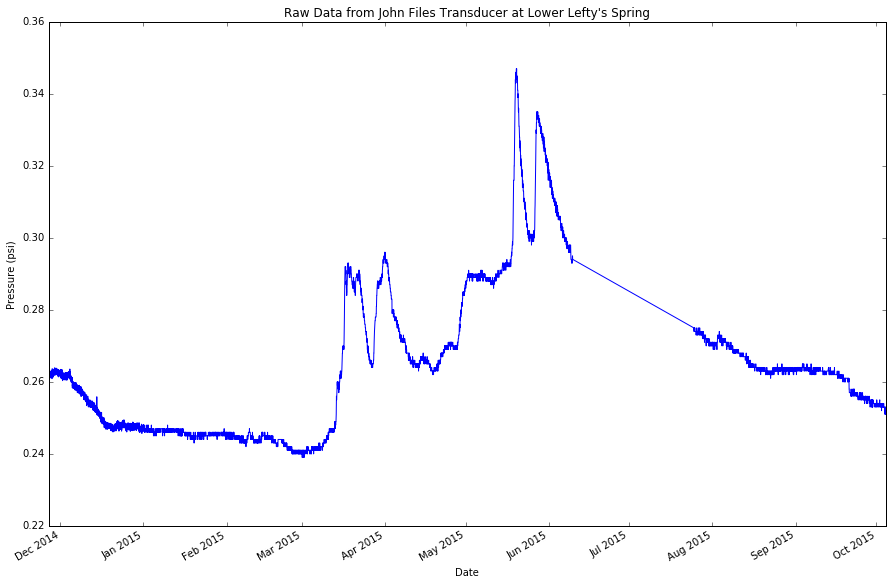

In [85]:
plt.figure()
LL_JF['LL_JF_p_PSI'].plot()
plt.ylabel('Pressure (psi)')
plt.xlabel('Date')
plt.title('Raw Data from John Files Transducer at Lower Lefty\'s Spring')

Remove outliers from John Files data.

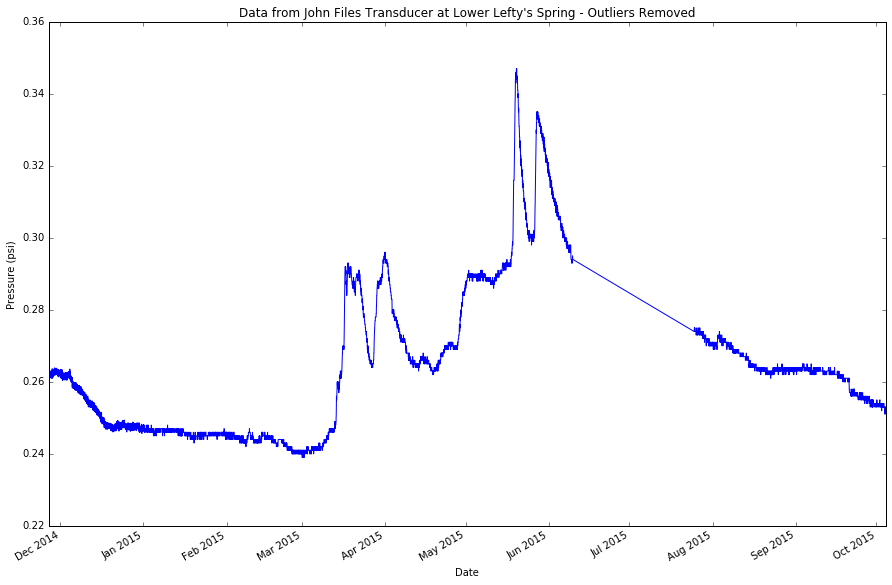

In [86]:
LL_JF = wt.smoother(LL_JF, 'LL_JF_p_PSI', 200, 3)
LL_JF['LL_JF_p_PSI'].plot()
plt.ylabel('Pressure (psi)')
plt.xlabel('Date')
plt.title('Data from John Files Transducer at Lower Lefty\'s Spring - Outliers Removed')

Resample and interpolate John Files data to match interval and timing of Loughlin data.

In [87]:
LL_JF = LL_JF.resample('1Min', how='mean')
LL_JF = LL_JF.interpolate(method='time', limit=480)
LL_JF = LL_JF.resample('15Min', how='mean', base=0)

In [88]:
LowLeftys = pd.merge(LowLeftys, LL_JF, left_index=True, right_index=True, how='outer')

Import the manually readings for Lower Lefty's weir. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=lowerman></a>

In [89]:
LL_manual = pd.read_excel(Lower_Leftys_Manual, 'LowerLeftys', index_col=0, 
                          parse_cols=[0,1], skiprows=0, 
                          names=['date','LL_vdepth_in'], skip_footer=0)
LL_manual['LL_vdepth_ft'] = LL_manual['LL_vdepth_in']/12
LL_manual = LL_manual.sort_index()
LL_manual = LL_manual[ LL_manual.index.to_datetime()>pd.datetime(2014,7,25)]
print LL_manual

                     LL_vdepth_in  LL_vdepth_ft
date                                           
2014-11-21 13:57:00        4.0000      0.333333
2014-11-26 15:30:00        4.0000      0.333333
2014-12-01 13:48:00        3.7500      0.312500
2014-12-01 14:26:00        4.0000      0.333333
2014-12-03 12:48:00        3.7500      0.312500
2014-12-03 12:48:00        3.8400      0.320000
2014-12-03 15:20:00        3.8750      0.322917
2014-12-04 12:00:00        4.0000      0.333333
2014-12-05 12:25:00        4.0000      0.333333
2014-12-05 12:40:00        3.8750      0.322917
2014-12-06 11:10:00        3.6000      0.300000
2014-12-07 08:00:00        3.4800      0.290000
2014-12-08 08:20:00        3.6000      0.300000
2014-12-08 13:07:00        3.8125      0.317708
2014-12-09 11:54:00        3.7500      0.312500
2014-12-10 11:55:00        3.8125      0.317708
2014-12-10 12:53:00        3.6240      0.302000
2014-12-11 11:07:00        3.6240      0.302000
2014-12-12 11:02:00        3.8125      0

In [90]:
LowLeftys.columns

Index([u'LL_LW_p_cm', u'LL_LW_t_C', u'UL_BP_LW_p_cm', u'UL_BP_LW_t_C',
       u'LL_LW_p_ft', u'UL_BP_LW_p_ft', u'LL_JF_p_PSI', u'LL_JF_t_C',
       u'deltaLL_JF_p_PSI', u'newVal'],
      dtype='object')

In [91]:
LowLeftys['LL_JF_p_ft'] = LowLeftys['LL_JF_p_PSI']*2.307
meanDiff = rollmeandiff(LL_manual,'LL_vdepth_ft',LowLeftys,'LL_JF_p_ft',5)
print meanDiff
LowLeftys['LL_JF_h_ft'] = LowLeftys['LL_JF_p_ft'] + meanDiff

-0.277


In [92]:
meanDiff = rollmeandiff(LL_manual,'LL_vdepth_ft',LowLeftys,'LL_LW_p_ft',5)
print meanDiff
LowLeftys['LL_LW_h_ft'] = LowLeftys['LL_LW_p_ft'] + meanDiff

-0.106


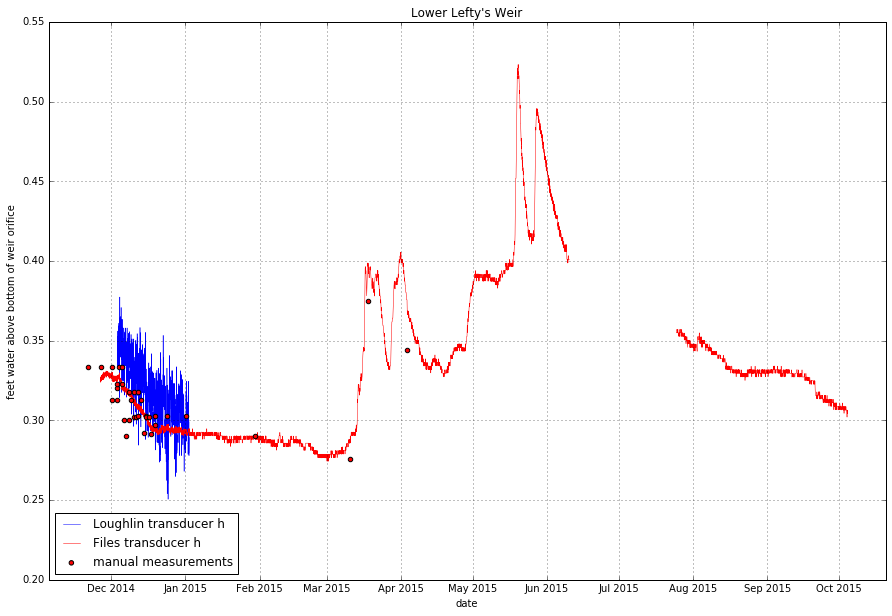

In [93]:
plt.figure()

x = LowLeftys.index.to_datetime()
y = LowLeftys['LL_LW_h_ft']

x1 = LL_manual.index.to_datetime()
y1 = LL_manual['LL_vdepth_ft']

y2 = LowLeftys['LL_JF_h_ft']

plt.plot(x, y, zorder=1, c='blue', linewidth=0.5, label='Loughlin transducer h')
plt.plot(x, y2, zorder=2, c='red', linewidth=0.5, label='Files transducer h')
plt.scatter(x1, y1, c='red', zorder=3, label='manual measurements')
plt.title('Lower Lefty\'s Weir')
plt.ylabel('feet water above bottom of weir orifice')
plt.xlabel('date')
plt.grid()
#plt.yticks(np.arange(0, 1.0, 0.05))
#plt.ylim(0.3, 1.0)
plt.legend(loc=3, scatterpoints=1)


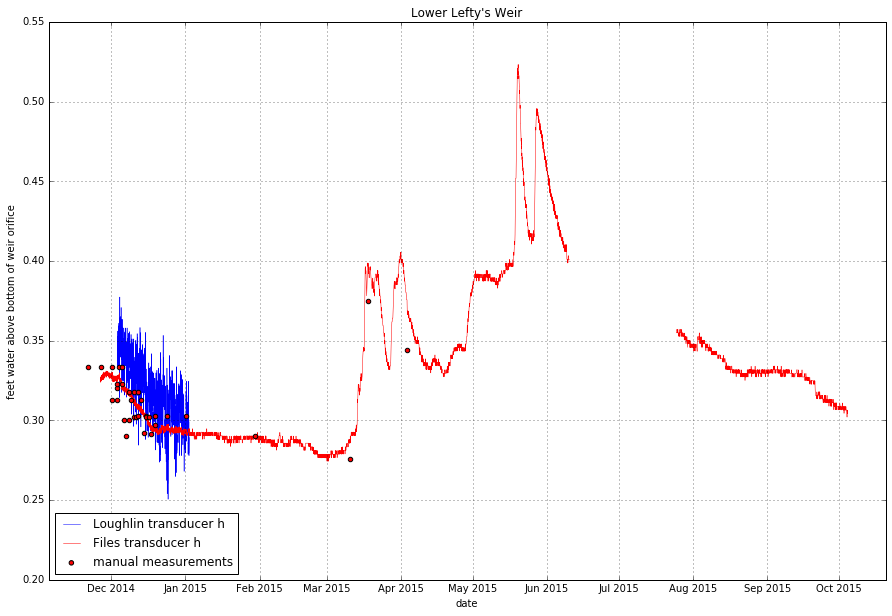

In [94]:
plt.figure()

x = LowLeftys.index.to_datetime()
y = LowLeftys['LL_LW_h_ft']

x1 = LL_manual.index.to_datetime()
y1 = LL_manual['LL_vdepth_ft']

y2 = LowLeftys['LL_JF_h_ft']

#x3 = 

plt.plot(x, y, zorder=1, c='blue', linewidth=0.5, label='Loughlin transducer h')
plt.plot(x, y2, zorder=2, c='red', linewidth=0.5, label='Files transducer h')
plt.scatter(x1, y1, c='red', zorder=3, label='manual measurements')
plt.title('Lower Lefty\'s Weir')
plt.ylabel('feet water above bottom of weir orifice')
plt.xlabel('date')
plt.grid()
#plt.yticks(np.arange(0, 1.0, 0.05))
#plt.ylim(0.3, 1.0)
plt.legend(loc=3, scatterpoints=1)


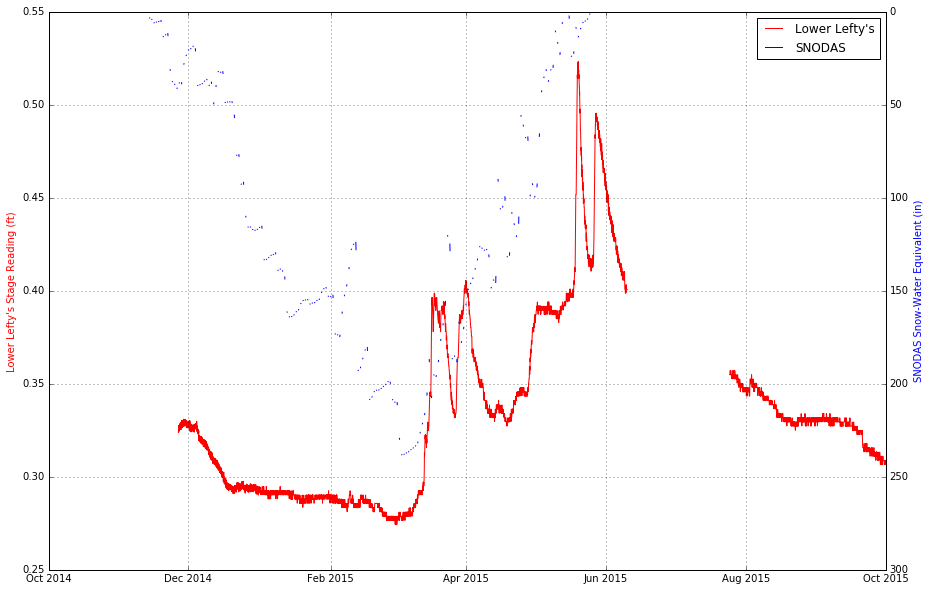

In [95]:
x1 = SNODAS.index.to_datetime()
y1 = SNODAS[u'SouthSide']

x = LowLeftys.index.to_datetime()
y2 = LowLeftys['LL_JF_h_ft']

fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = ax.plot(x,y2,color='red',label='Lower Lefty\'s')

ax2 = ax.twinx()
lns2 = ax2.plot(x1,y1,color='blue',label='SNODAS')
ax2.set_ylim(300,0)
plt.xlim('10/1/2014','10/1/2015')
xtic = ['10/1/2014','11/1/2014','12/1/2014','1/1/2015','2/1/2015','3/1/2015','4/1/2015','5/1/2015', 
          '6/1/2015','7/1/2015','8/1/2015','9/1/2015','10/1/2015']
xlabs = ['10/1/2014','11/1/2014','12/1/2014','1/1/2015','2/1/2015','3/1/2015','4/1/2015','5/1/2015', 
          '6/1/2015','7/1/2015','8/1/2015','9/1/2015','10/1/2015']
#plt.xticks(xtic, xlabs, rotation=45)
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.set_ylabel('Lower Lefty\'s Stage Reading (ft)', color='red')
ax2.set_ylabel('SNODAS Snow-Water Equivalent (in)', color='blue')
ax.grid()

plt.savefig(rootlocal+'LowerLeftysLongterm.pdf')



Once the transducer data were aligned with manual readings, we converted the height of water above the bottom of the weir orifice to discharge in both gpm and cfs.

To do this, we used equations from: U.S. Bureau of Reclamation, 2001, Water Measurement Manual - A water resources technical publication: online, http://www.usbr.gov/pmts/hydraulics_lab/pubs/wmm/.

For 90$^\circ$ v-notch weirs, the equation to calculate discharge from h is:
$$
Q= 1122\cdot h^{\frac{5}{2}}
$$
<ul>
  <li>h = feet above bottom of weir orifice</li>
  <li>Q = discharge in gpm</li>
</ul>

In [96]:
LowLeftys['LL_LW_Q_gpm'] = 1122*LowLeftys['LL_LW_h_ft']**2.5
LowLeftys['LL_JF_Q_gpm'] = 1122*LowLeftys['LL_JF_h_ft']**2.5
LowLeftys['LL_JF_Q_cfs'] = 0.00222800926*LowLeftys['LL_JF_Q_gpm']
LowLeftys['LL_LW_Q_cfs'] = 0.00222800926*LowLeftys['LL_LW_Q_gpm']

In [97]:
LowLeftys.describe()

LL_LW_p_cm    LL_LW_t_C  UL_BP_LW_p_cm  UL_BP_LW_t_C   LL_LW_p_ft  \
count  2875.000000  2875.000000   15469.000000  15469.000000  2875.000000   
mean    781.381658     5.021077     771.930240      6.910033     0.423847   
std       5.200128     0.138778       4.591432      8.970277     0.019850   
min     763.183000     4.080000     750.575000    -19.060000     0.356529   
25%     778.525000     4.960000     768.800000     -0.700000     0.409695   
50%     781.208000     5.003000     772.625000      7.100000     0.423228   
75%     783.483000     5.057000     775.400000     12.723000     0.438255   
max     792.292000     7.893000     781.125000     35.880000     0.483366   

       UL_BP_LW_p_ft   LL_JF_p_PSI     LL_JF_t_C  deltaLL_JF_p_PSI  \
count   15469.000000  25638.000000  25638.000000      25638.000000   
mean       25.325796      0.264932      5.058129          0.000005   
std         0.150638      0.020838      0.286575          0.000595   
min        24.625165      0.238998      4.157676         -0.003751   
25%        25.223098      0.246874      4.857546         -0.000264   
50%        25.348590      0.262780      5.053500          0.000000   
75%        25.439633      0.271905      5.189692          0.000250   
max        25.627461      0.346843      6.293840          0.006623   

             newVal    LL_JF_p_ft    LL_JF_h_ft   LL_LW_h_ft  LL_LW_Q_gpm  \
count  25638.000000  25638.000000  25638.000000  2875.000000  2875.000000   
mean       0.270014      0.611197      0.334197     0.317847    64.372393   
std        0.022161      0.048072      0.048072     0.019850     9.979885   
min        0.238998      0.551369      0.274369     0.250529    35.248234   
25%        0.246874      0.569538      0.292538     0.303695    57.027821   
50%        0.271655      0.606233      0.329233     0.317228    63.594985   
75%        0.286905      0.627285      0.350285     0.332255    71.395426   
max        0.346843      0.800166      0.523166     0.377366    98.152243   

        LL_JF_Q_gpm   LL_JF_Q_cfs  LL_LW_Q_cfs  
count  25638.000000  25638.000000  2875.000000  
mean      75.330650      0.167837     0.143422  
std       30.002307      0.066845     0.022235  
min       44.241625      0.098571     0.078533  
25%       51.933645      0.115709     0.127059  
50%       69.783504      0.155478     0.141690  
75%       81.479095      0.181536     0.159070  
max      222.122337      0.494891     0.218684

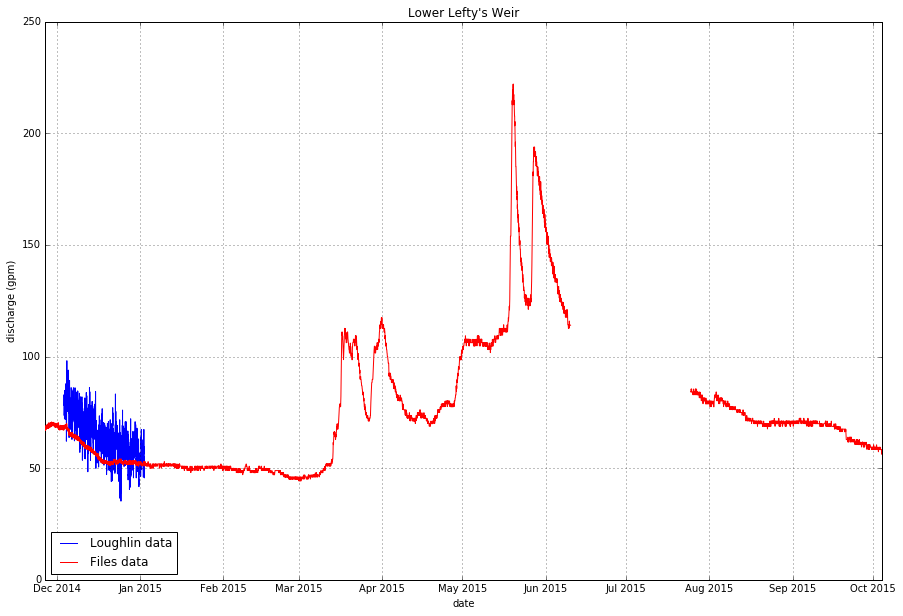

In [98]:
plt.figure()
x = LowLeftys.index.to_datetime()
y1 = LowLeftys['LL_LW_Q_gpm']
y2 = LowLeftys['LL_JF_Q_gpm']

plt.figure()

plt.plot(x,y1, color='blue', zorder=2, label='Loughlin data')
plt.plot(x,y2, color='red', zorder=3, label='Files data')


plt.title('Lower Lefty\'s Weir')
plt.ylabel('discharge (gpm)')
plt.xlabel('date')
plt.grid()

plt.legend(loc=3, scatterpoints=1)

                            OLS Regression Results                            
Dep. Variable:            LL_JF_Q_gpm   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                 3.419e+04
Date:                Tue, 09 Feb 2016   Prob (F-statistic):               0.00
Time:                        09:21:08   Log-Likelihood:                -13958.
No. Observations:                6187   AIC:                         2.792e+04
Df Residuals:                    6185   BIC:                         2.793e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       7.174e+05   3879.053    184.930      0.0

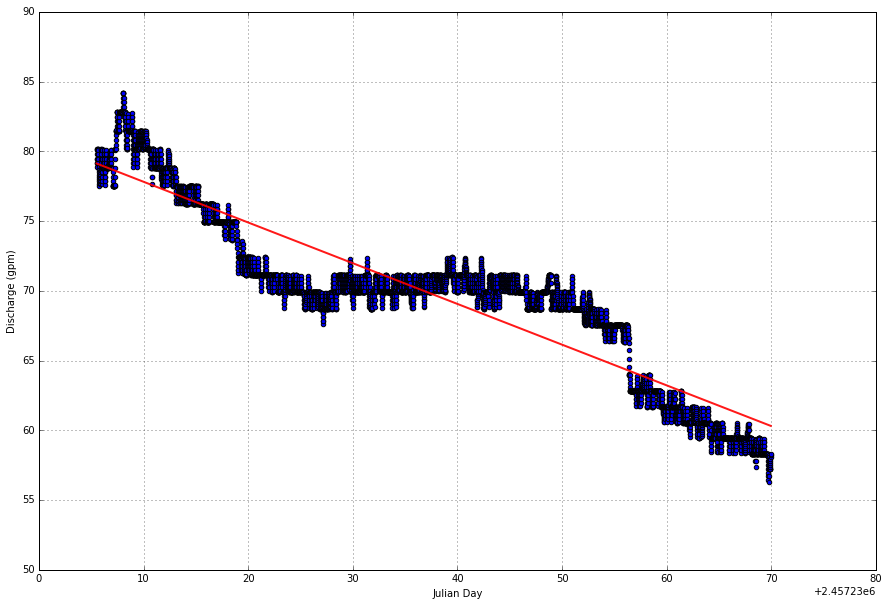

In [99]:
LowLeft = LowLeftys[(LowLeftys.index.to_datetime()>pd.datetime(2015,8,1))]
x0 = LowLeft.index.to_julian_date()
x = sm.add_constant(x0)
y = LowLeft['LL_JF_Q_gpm']

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')
plt.xlabel('Julian Day')
plt.ylabel('Discharge (gpm)')
#plt.xlim(2456860,2456990)
#plt.xticks(np.arange(2456860,2456995, 5))
#plt.yticks(np.arange(0,145, 5))
plt.grid()

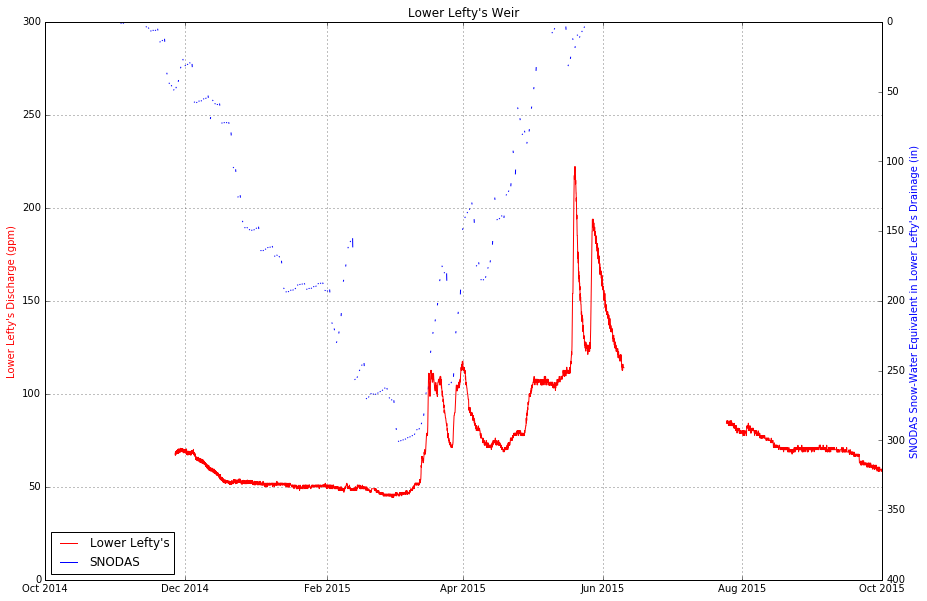

In [100]:
plt.figure()
x = LowLeftys.index.to_datetime()
y = LowLeftys['LL_JF_Q_gpm']

x1 = SNODAS.index.to_datetime()
y1 = SNODAS[u'LeftysCreek']


fig = plt.figure()
plt.title('Lower Lefty\'s Weir')
ax = fig.add_subplot(111)
lns1 = ax.plot(x,y, zorder=10, color='red',label='Lower Lefty\'s')

ax2 = ax.twinx()
lns2 = ax2.plot(x1,y1, zorder=2, color='blue',label='SNODAS')
plt.xlim('10/1/2014','10/1/2015')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=3)
ax.set_ylim(0,300)
ax.set_ylabel('Lower Lefty\'s Discharge (gpm)',color='red')
ax2.set_ylabel('SNODAS Snow-Water Equivalent in Lower Lefty\'s Drainage (in)',color='blue')
ax2.set_ylim(400,0)
plt.xlabel('date')
ax.set_zorder(ax2.get_zorder()+1) # put ax in front of ax2 
ax.patch.set_visible(False) # hide the 'canvas' 
ax.grid()
plt.savefig(rootlocal+"LowerLeftysLongterm.pdf")

80
80
                            OLS Regression Results                            
Dep. Variable:           UL_man_Q_gpm   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     924.3
Date:                Tue, 09 Feb 2016   Prob (F-statistic):           5.30e-45
Time:                        09:21:10   Log-Likelihood:                -241.80
No. Observations:                  80   AIC:                             487.6
Df Residuals:                      78   BIC:                             492.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       8.749e+05   2.88e+04     30.404   

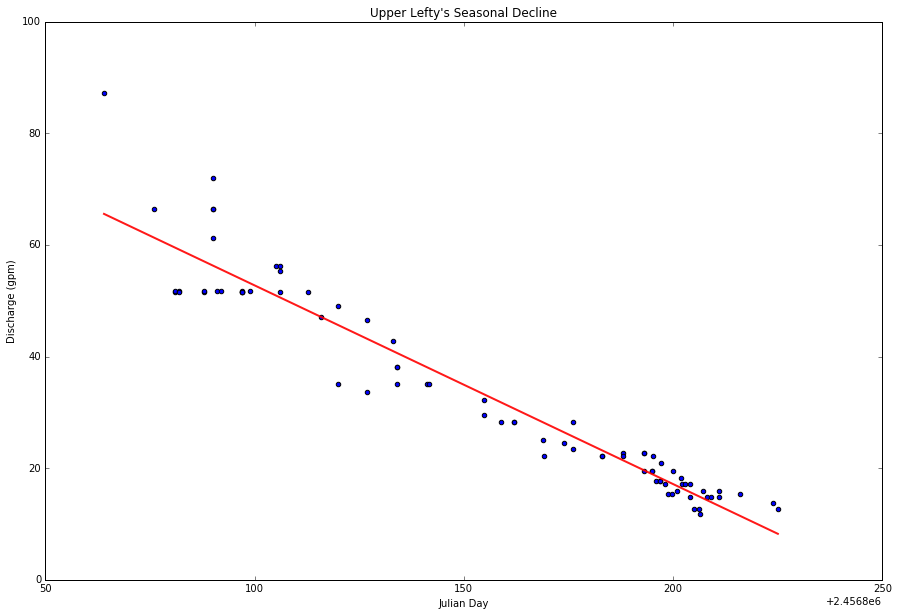

In [101]:
UL_manual['UL_man_Q_gpm'] = 1122*UL_manual['UL_vdepth_ft']**2.5
UL_man_V = UL_manual.dropna(subset=['UL_man_Q_gpm'])

plt.figure()
x0 = UL_man_V.index.to_julian_date()
y = UL_man_V['UL_man_Q_gpm']

x = sm.add_constant(x0)
print len(x0)
print len(y)

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Upper Lefty\'s Seasonal Decline')
plt.ylabel('Discharge (gpm)')
plt.xlabel('Julian Day')

2014-07-25 12:30:00
2014-11-21 11:55:00
       UL_vdepth_in  UL_depth_in  UL_bucket_Q_gpm  UL_vdepth_ft  UL_man_Q_gpm
count     11.000000    11.000000        11.000000     11.000000     11.000000
mean       3.335909     3.576136        67.869248      0.277992     47.928115
std        0.563302     0.640324        22.214423      0.046942     19.328506
min        2.500000     2.525000        32.397408      0.208333     22.227456
25%        3.000000     3.087500        53.803097      0.250000     35.518977
50%        3.500000     3.837500        75.452716      0.291667     51.547767
75%        3.562500     4.025000        81.964945      0.296875     53.911012
max        4.320000     4.400000        97.014925      0.360000     87.246720
11
11
                            OLS Regression Results                            
Dep. Variable:        UL_bucket_Q_gpm   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.887
Method:        

c:\python27\arcgis10.3\lib\site-packages\scipy\stats\stats.py:1285: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


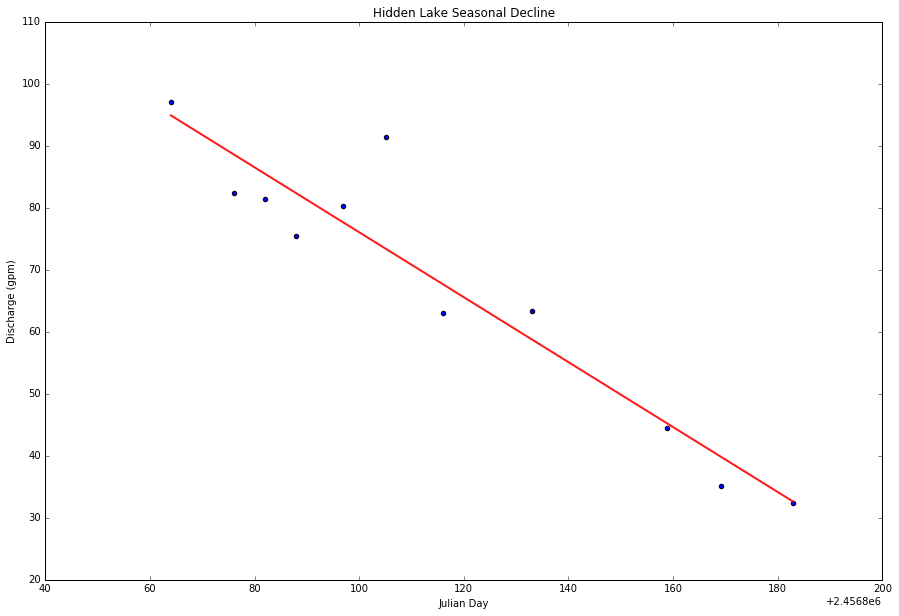

In [102]:
plt.figure()
UL_man = UL_manual.dropna(subset=['UL_bucket_Q_gpm'])
x0 = UL_man.index.to_julian_date()
y = UL_man['UL_bucket_Q_gpm']

print min(UL_man.index)
print max(UL_man.index)
print UL_man.describe()

x = sm.add_constant(x0)
print len(x0)
print len(y)

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Hidden Lake Seasonal Decline')
plt.ylabel('Discharge (gpm)')
plt.xlabel('Julian Day')

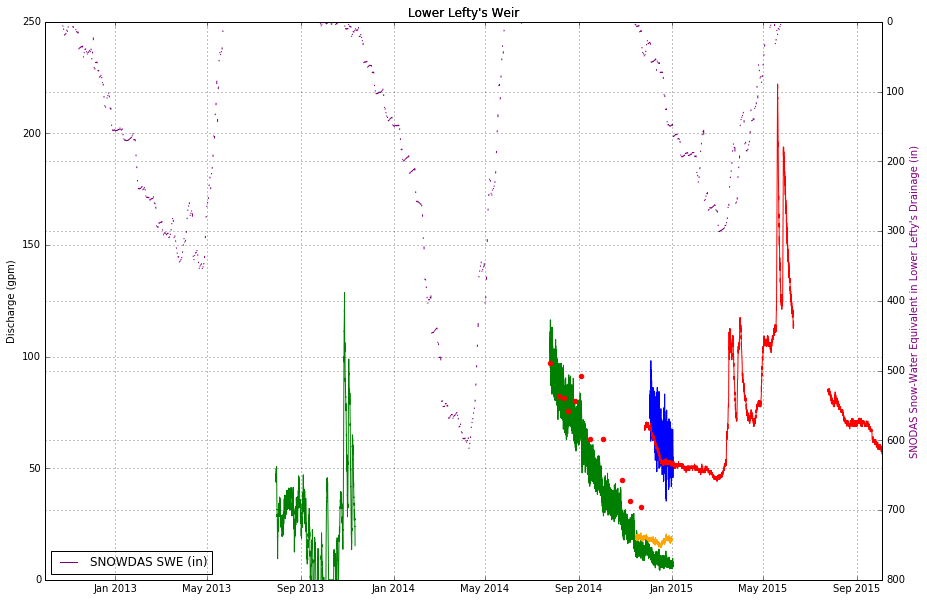

In [103]:
plt.figure()
x = LowLeftys.index.to_datetime()
y1 = LowLeftys['LL_LW_Q_gpm']
y2 = LowLeftys['LL_JF_Q_gpm']

x5 = UL_manual.index.to_datetime()
y5 = UL_manual['UL_bucket_Q_gpm']

x6 = SNODAS.index.to_datetime()
y6 = SNODAS[u'LeftysCreek']

x2 = Leftys.index.to_datetime()
y3 = Leftys['UL_LW_Q_gpm']
y4 = Leftys['UL_JF_Q_gpm']
#y3 = pd.rolling_mean(LowLeftys['LL_LW_Q_gpm'], window=86, center=True)
#y4 = pd.rolling_mean(LowLeftys['LL_JF_Q_gpm'], window=48, center=True)

fig = plt.figure()
plt.title('Lower Lefty\'s Weir')
ax = fig.add_subplot(111)

#lns1 = ax.plot(x,y, zorder=10, color='red',label='Lower Lefty\'s')

ax.scatter(x5,y5, color='red',zorder=5, label='manual discharge measurements')
ax.plot(x,y1, color='blue', zorder=2, label='Loughlin LL data')
ax.plot(x,y2, color='red', zorder=3, label='Files LL data')
ax.plot(x2,y3, color='green', linewidth=1, zorder=3, label='Loughlin UL data')
ax.plot(x2,y4, color='orange',  linewidth=1, zorder=4, label='Files UL data')
ax.set_ylim(0,250)
ax2 = ax.twinx()
ax2.plot(x6,y6, color = 'purple', label = 'SNOWDAS SWE (in)')
ax2.set_ylabel('SNODAS Snow-Water Equivalent in Lower Lefty\'s Drainage (in)',color='purple')
ax.set_ylabel('Discharge (gpm)')
ax2.set_ylim(800,0)
plt.xlabel('date')
ax.set_zorder(ax2.get_zorder()+1) # put ax in front of ax2 
ax.patch.set_visible(False) # hide the 'canvas' 
ax.grid()
plt.title('Lower Lefty\'s Weir')
#plt.ylabel('discharge (gpm)')
plt.xlabel('date')
plt.grid()

plt.legend(loc=3, scatterpoints=1)

In [104]:
LowLeftysDrop = ['LL_LW_p_cm', 'dpLL_LW_p_cm', 'maLL_LW_p_cm', 'mstLL_LW_p_cm', 'UL_BP_LW_p_cm', 'LL_LW_p_ft', 
                            'LL_JF_p_PSI', 'LL_JF_dp_PSI', 'dpLL_JF_p_PSI', 'maLL_JF_p_PSI', 'mstLL_JF_p_PSI', 
                            'LL_JF_p_ft', 'LL_JF_h_ft', 'LL_LW_h_ft', 'UL_BP_LW_t_C', 'UL_BP_LW_p_ft']


In [105]:
LowLeftys = nodups(LowLeftys,All)

In [106]:
list(LowLeftys.columns.values)

['LL_LW_t_C',
 'LL_JF_t_C',
 'LL_LW_Q_gpm',
 'LL_JF_Q_gpm',
 'LL_JF_Q_cfs',
 'LL_LW_Q_cfs']

Merge existing datasets.

In [107]:
All = pd.merge(All, LowLeftys, left_index=True, right_index=True, how='outer')

In [108]:
list(All.columns.values)

['USU_Avon_BP_mmHg',
 'USU_SF_BP_mmHg',
 'USU_SF_PPT_in',
 'USU_PPT_CDM',
 'USU_SF_AD_h_ft',
 'USU_SF_BD_h_ft',
 'Site Id',
 'WTEQ.I-1 (in) ',
 'PREC.I-1 (in) ',
 'TOBS.I-1 (degC) ',
 'SNWD.I-1 (in) ',
 'SMS.I-1:-2 (pct)  (silt)',
 'SMS.I-1:-8 (pct)  (silt)',
 'SMS.I-1:-20 (pct)  (silt)',
 'STO.I-1:-2 (degC) ',
 'STO.I-1:-8 (degC) ',
 'STO.I-1:-20 (degC) ',
 'SAL.I-1:-2 (gram) ',
 'SAL.I-1:-8 (gram) ',
 'SAL.I-1:-20 (gram) ',
 'RDC.I-1:-2 (unit) ',
 'RDC.I-1:-8 (unit) ',
 'RDC.I-1:-20 (unit) ',
 'BATT.I-1 (volt) ',
 'Unnamed: 20',
 'SForkWolfCreek',
 'OtherQuartzite',
 'NorthForkofWolfCreek',
 'LeftysCreek',
 'JamesPeakFork',
 'HiddenLakeFork',
 'CobabeCreek',
 'NorthSide',
 'SouthSide',
 'UL_BP_LW_p_cm',
 'UL_BP_LW_p_ft',
 'UL_BP_LW_t_C',
 'UL_JF_Q_cfs',
 'UL_JF_Q_gpm',
 'UL_JF_t_C',
 'UL_LW_Q_cfs',
 'UL_LW_Q_gpm',
 'UL_LW_t_C',
 'LL_LW_t_C',
 'LL_JF_t_C',
 'LL_LW_Q_gpm',
 'LL_JF_Q_gpm',
 'LL_JF_Q_cfs',
 'LL_LW_Q_cfs']

## Hidden Lake Spring

### Importing and Converting Hidden Lake Spring Data

[To top of page](#top)

Import the Hidden Lake weir data. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=hidden></a>

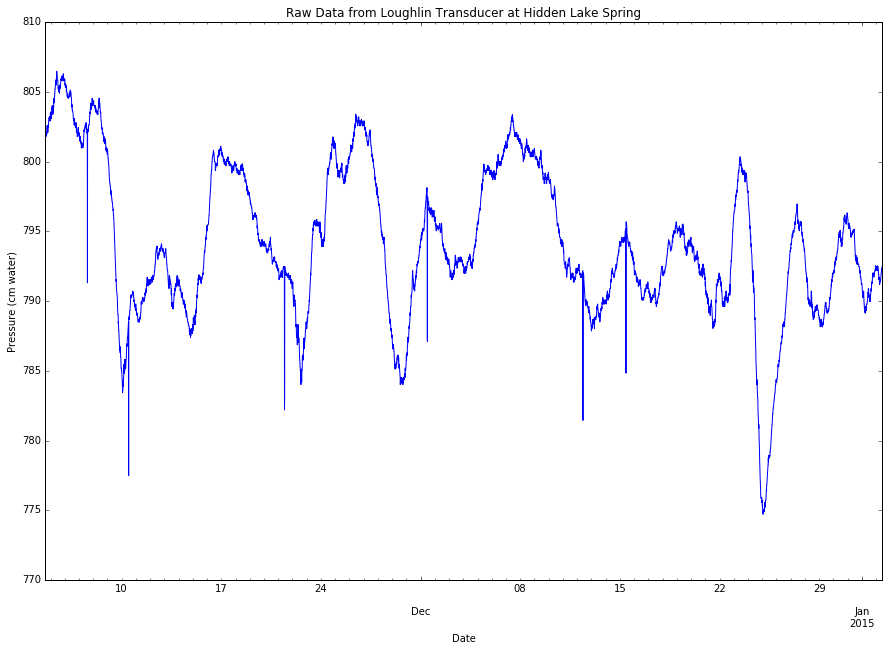

In [109]:
HL_LW = pd.read_csv(Hidden_Lake_Loughlin, 
                    index_col=0, skiprows=53, skipfooter=1, parse_dates=True, 
                    usecols=[0,1,2], names=['dt','HL_LW_p_cm','HL_LW_t_C'], engine='python')

HL_LW['HL_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Raw Data from Loughlin Transducer at Hidden Lake Spring')

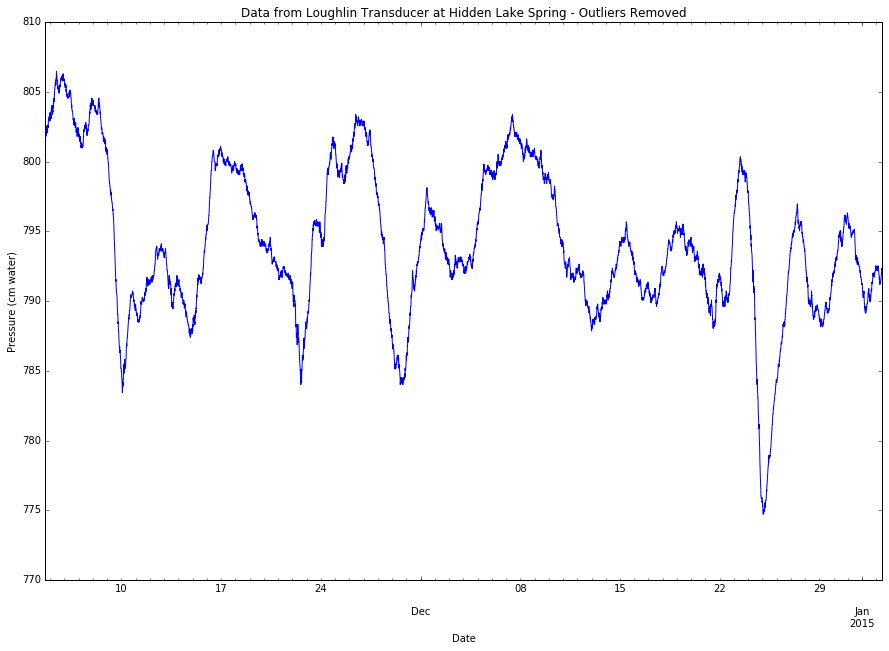

In [110]:
HL_LW = wt.smoother(HL_LW, 'HL_LW_p_cm', 50, 3)
HL_LW = wt.smoother(HL_LW, 'HL_LW_p_cm', 50, 3) # passed twice
HL_LW['HL_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Data from Loughlin Transducer at Hidden Lake Spring - Outliers Removed')

Import the Hidden Lake barometric pressure data. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=hiddenbp></a>

In [111]:
HL_BP_LW = pd.read_csv(Hidden_Lake_Barometer_Loughlin, 
                    index_col=0, skiprows=52, skipfooter=1, parse_dates=True, names=['dt','HL_BP_LW_p_cm','HL_BP_LW_t_C'], 
                    engine='python')

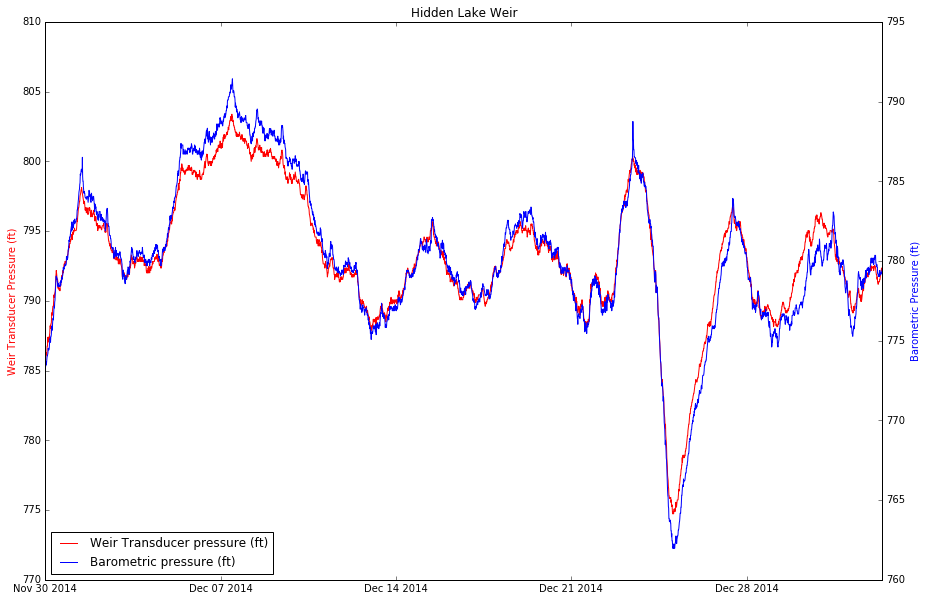

In [112]:
plt.figure()
x1 = HL_LW.index.to_datetime()
y1 = HL_LW['HL_LW_p_cm']

x2 = HL_BP_LW.index.to_datetime()
y2 = HL_BP_LW['HL_BP_LW_p_cm']

fig, ax1 = plt.subplots()
plt.title('Hidden Lake Weir')
ax2 = ax1.twinx()
ax1.plot(x1,y1,c='r',label='Weir Transducer pressure (ft)')
ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='r') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x2,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

In [113]:
HidLake = pd.merge(HL_LW, HL_BP_LW, left_index=True, right_index=True, how='outer')

HidLake['HL_LW_p_ft'] =(HidLake['HL_LW_p_cm'] - HidLake['HL_BP_LW_p_cm'])*0.0328084
HidLake['HL_BP_LW_p_ft'] = HidLake['HL_BP_LW_p_cm']*0.0328084

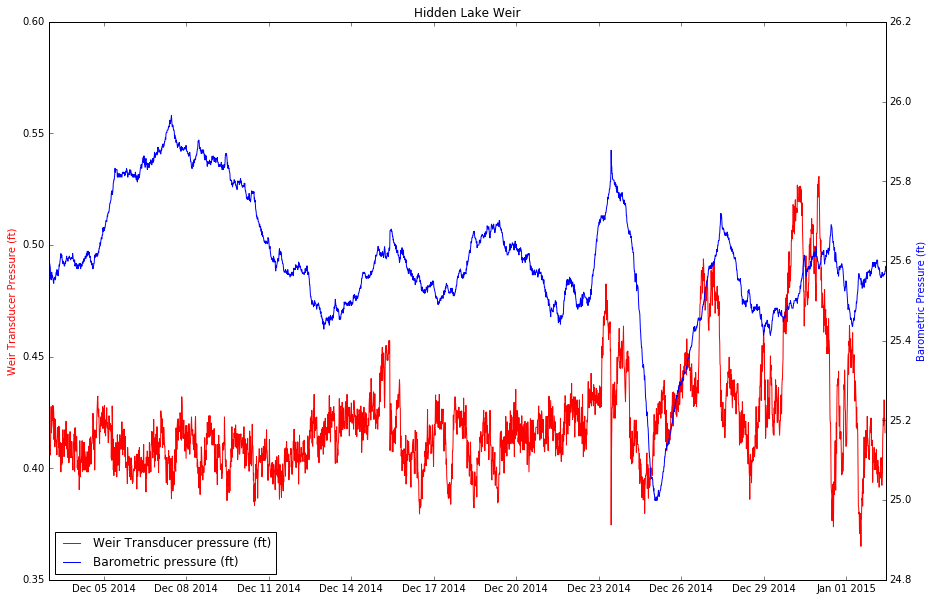

In [114]:
x = HidLake.index.to_datetime()
y1 = HidLake['HL_LW_p_ft']
y2 = HidLake['HL_BP_LW_p_ft']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Hidden Lake Weir')
ax1.plot(x,y1,c='r',label='Weir Transducer pressure (ft)')
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='r') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_xlim('12/3/2014',HidLake.index.to_datetime()[-1])
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

Import the Hidden Lake wier data from John Files. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=hiddenfiles></a>

In [115]:
HL_JF = pd.read_csv(Hidden_Lake_John_Files, 
                     index_col=0, skiprows=89, skipfooter=1, usecols=[0,2,3], parse_dates=True, 
                     names=['dt','HL_JF_p_PSI','HL_JF_t_C'], engine='python')

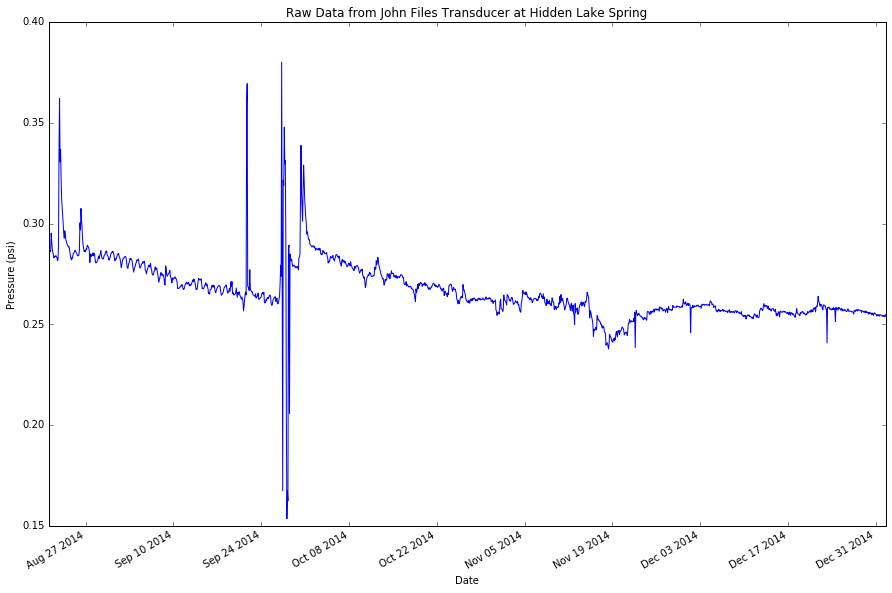

In [116]:
HL_JF['HL_JF_p_PSI'].plot()
plt.ylabel('Pressure (psi)')
plt.xlabel('Date')
plt.title('Raw Data from John Files Transducer at Hidden Lake Spring')

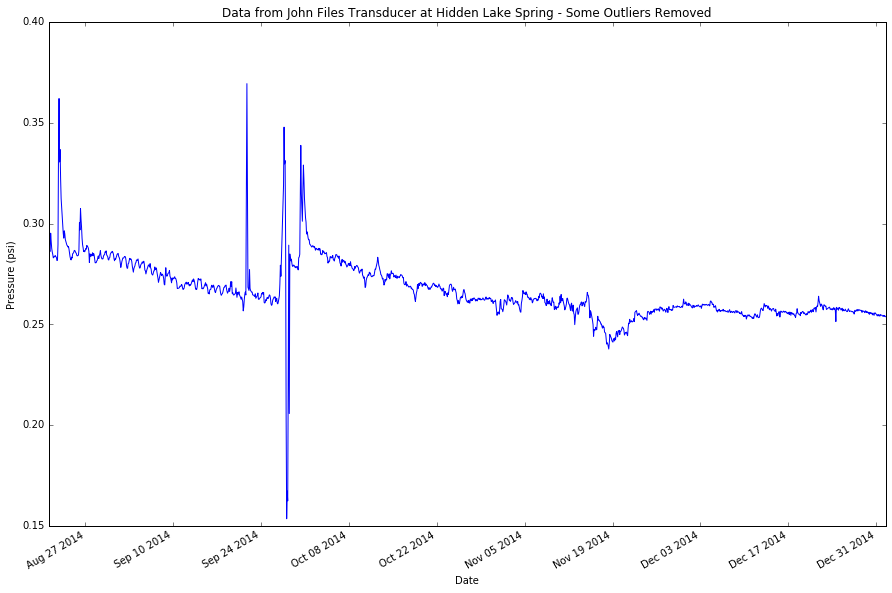

In [117]:
HL_JF = wt.smoother(HL_JF, 'HL_JF_p_PSI', 100, 3)
HL_JF['HL_JF_p_PSI'].plot()
plt.ylabel('Pressure (psi)')
plt.xlabel('Date')
plt.title('Data from John Files Transducer at Hidden Lake Spring - Some Outliers Removed')

In [118]:
HL_JF = HL_JF.resample('1Min', how='mean')
HL_JF = HL_JF.interpolate(method='time', limit=480)
HL_JF = HL_JF.resample('15Min', how='mean', base=0)

In [119]:
HidLake = pd.merge(HidLake, HL_JF, left_index=True, right_index=True, how='outer')

Import the manual data. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=hiddenman></a>

In [120]:
HL_manual = pd.read_excel(Hidden_Lake_Manual, 'HiddenLakeWeir', index_col=0, 
                          parse_cols=[0,1,2], skiprows=0, na_values=['NA',''],
                          names=['date','HL_vdepth_in','HL_depth_in'], skip_footer=0, parse_dates=True)
HL_manual['HL_offset_ft'] = (HL_manual['HL_depth_in']/12-HL_manual['HL_vdepth_in']/12).mean()
HL_manual['HL_depth_ft'] = HL_manual['HL_vdepth_in']/12+HL_manual['HL_offset_ft']
HL_manual = HL_manual.sort_index()
HL_manual = HL_manual[ HL_manual.index.to_datetime()>pd.datetime(2014,7,25)]
print HL_manual

                     HL_vdepth_in  HL_depth_in  HL_offset_ft  HL_depth_ft
date                                                                     
2014-08-18 11:00:00        2.5000          NaN      0.167969     0.376302
2014-08-20 09:20:00        2.7500          NaN      0.167969     0.397135
2014-08-20 11:00:00        2.7500          NaN      0.167969     0.397135
2014-08-22 11:00:00        2.5000          NaN      0.167969     0.376302
2014-08-27 11:00:00        2.6250          NaN      0.167969     0.386719
2014-08-29 09:36:00        2.9000          NaN      0.167969     0.409635
2014-08-29 09:36:00        2.7500          NaN      0.167969     0.397135
2014-09-04 11:00:00        2.8125          NaN      0.167969     0.402344
2014-09-05 10:23:00        2.7500          NaN      0.167969     0.397135
2014-09-12 11:55:00        2.6250          NaN      0.167969     0.386719
2014-09-15 11:00:00        2.3750       4.4375      0.167969     0.365885
2014-09-19 08:15:00        2.5000     

In [121]:
meanDiff = rollmeandiff(HL_manual,'HL_depth_ft',HidLake,'HL_LW_p_ft',5)
print meanDiff
HidLake['HL_LW_h_ft'] = HidLake['HL_LW_p_ft'] + meanDiff

-0.074


In [122]:
HidLake['HL_JF_p_ft'] = HidLake['HL_JF_p_PSI']*2.307
meanDiff = rollmeandiff(HL_manual,'HL_depth_ft',HidLake,'HL_JF_p_ft',5)
print meanDiff
HidLake['HL_JF_h_ft'] = HidLake['HL_JF_p_ft'] + meanDiff

-0.247


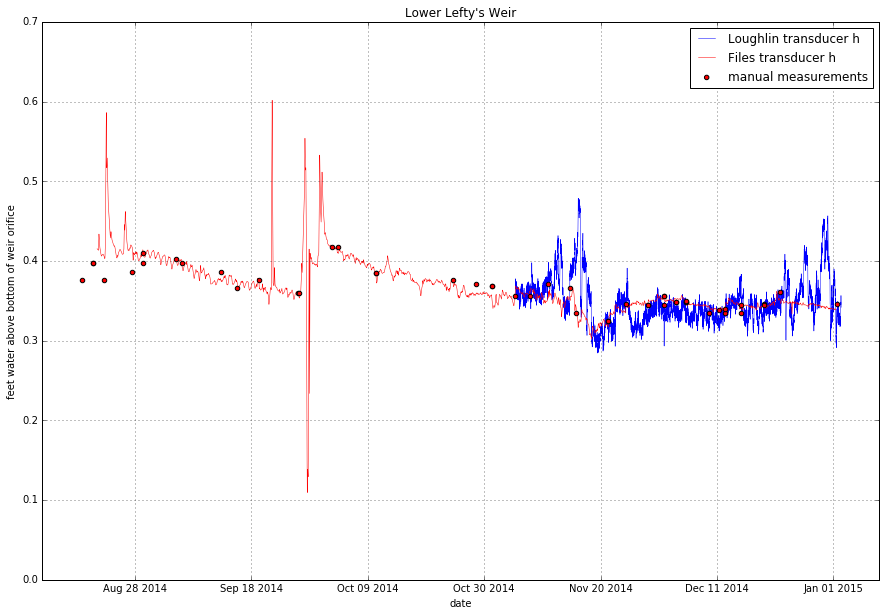

In [123]:
plt.figure()

x = HidLake.index.to_datetime()
y = HidLake['HL_LW_h_ft']

x1 = HL_manual.index.to_datetime()
y1 = HL_manual['HL_depth_ft']

y2 = HidLake['HL_JF_h_ft']

plt.plot(x, y, zorder=1, c='blue', linewidth=0.5, label='Loughlin transducer h')
plt.plot(x, y2, zorder=2, c='red', linewidth=0.5, label='Files transducer h')
plt.scatter(x1, y1, c='red', zorder=3, label='manual measurements')
plt.title('Lower Lefty\'s Weir')
plt.ylabel('feet water above bottom of weir orifice')
plt.xlabel('date')
plt.grid()
plt.legend(scatterpoints=1)


Once the transducer data were aligned with manual readings, we converted the height of water above the bottom of the weir orifice to discharge in both gpm and cfs.

To do this, we used equations from: U.S. Bureau of Reclamation, 2001, Water Measurement Manual - A water resources technical publication: online, http://www.usbr.gov/pmts/hydraulics_lab/pubs/wmm/.

For 90$^\circ$ v-notch weirs, the equation to calculate discharge from h is:
$$
Q= 1122\cdot h^{\frac{5}{2}}
$$
<ul>
  <li>h = feet above bottom of weir orifice</li>
  <li>Q = discharge in gpm</li>
</ul>

In [124]:
HidLake['HL_LW_Q_gpm'] = 1122*HidLake['HL_LW_h_ft']**2.5
HidLake['HL_JF_Q_gpm'] = 1122*HidLake['HL_JF_h_ft']**2.5
HidLake['HL_JF_Q_cfs'] = 0.00222800926*HidLake['HL_JF_Q_gpm']
HidLake['HL_LW_Q_cfs'] = 0.00222800926*HidLake['HL_LW_Q_gpm']

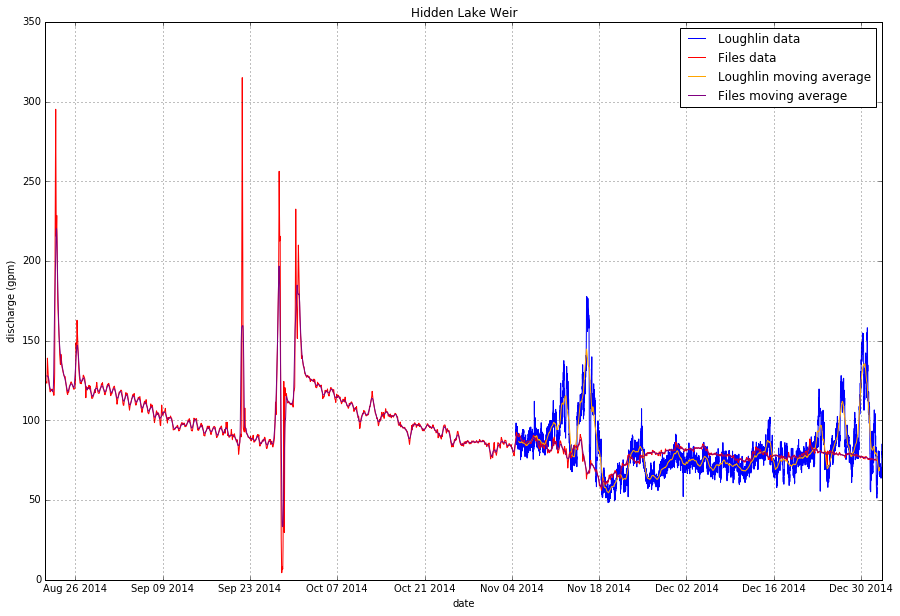

In [125]:
plt.figure()
x = HidLake.index.to_datetime()
y1 = HidLake['HL_LW_Q_gpm']
y2 = HidLake['HL_JF_Q_gpm']

y3 = pd.rolling_mean(HidLake['HL_LW_Q_gpm'], window=86, center=True)
y4 = pd.rolling_mean(HidLake['HL_JF_Q_gpm'], window=48, center=True)

plt.figure()
plt.plot(x,y1, color='blue', zorder=1, label='Loughlin data')
plt.plot(x,y2, color='red', zorder=2, label='Files data')
plt.plot(x,y3, color='orange', zorder=3, label='Loughlin moving average')
plt.plot(x,y4, color='purple', zorder=4, label='Files moving average')
plt.title('Hidden Lake Weir')
plt.ylabel('discharge (gpm)')
plt.xlabel('date')
plt.grid()

plt.legend()

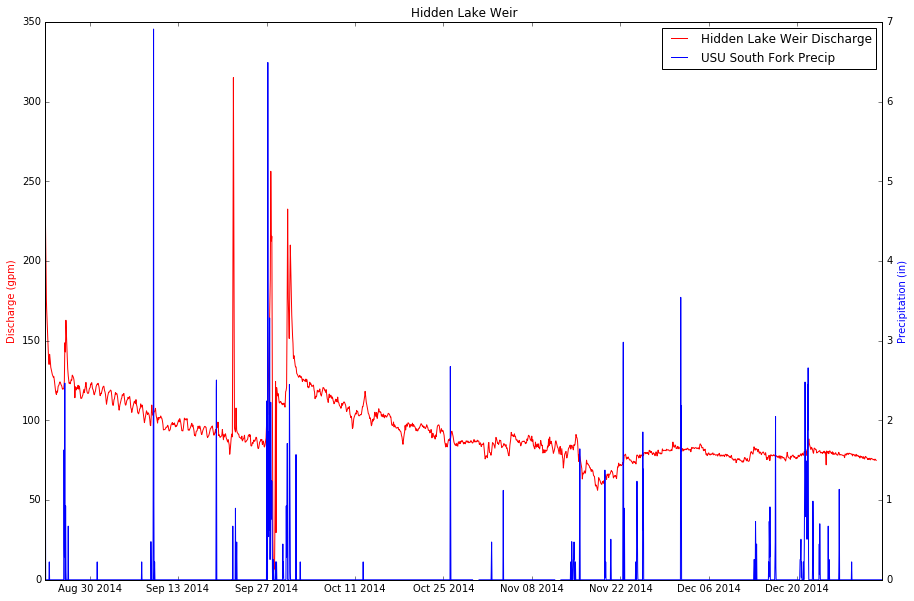

In [126]:

x1 = HidLake.index.to_datetime()
x2 = All.index.to_datetime()

y1 = HidLake['HL_JF_Q_gpm']
y2 = All['USU_SF_PPT_in']


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Hidden Lake Weir')
ax1.plot(x1,y1,c='r',label='Hidden Lake Weir Discharge')
ax1.set_ylabel('Discharge (gpm)', color='r') 
ax2.set_ylabel('Precipitation (in)', color='b') 
ax2.plot(x2,y2,c='b',label='USU South Fork Precip')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_xlim('8/23/2014',HidLake.index.to_datetime()[-1])
ax1.legend(h1+h2, l1+l2, loc=0)

plt.show()
plt.savefig(rootlocal+"HiddenLakeWeir.pdf")

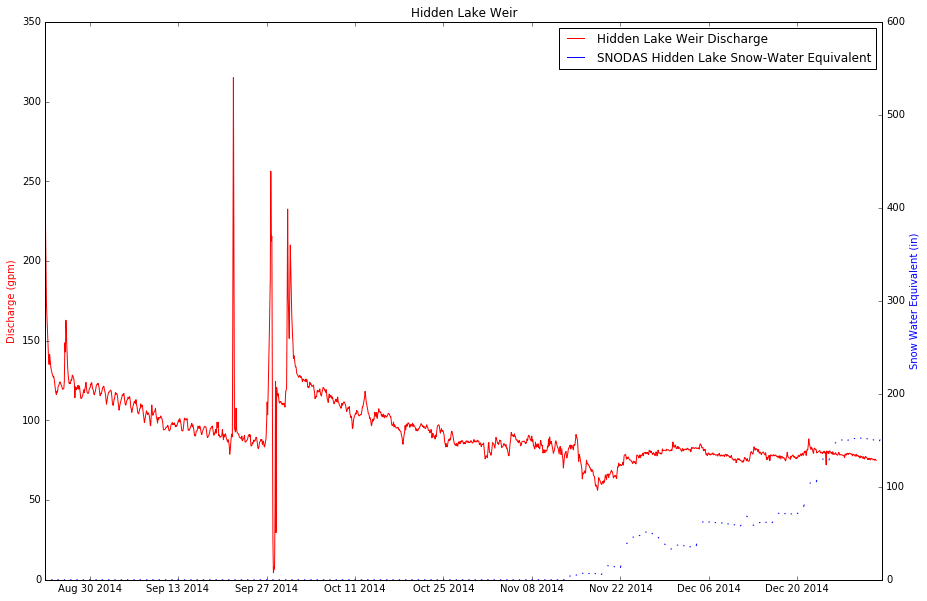

In [127]:

x1 = HidLake.index.to_datetime()
x2 = SNODAS.index.to_datetime()

y1 = HidLake['HL_JF_Q_gpm']
y2 = SNODAS['HiddenLakeFork']


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Hidden Lake Weir')
ax1.plot(x1,y1,c='r',label='Hidden Lake Weir Discharge')
ax1.set_ylabel('Discharge (gpm)', color='r') 
ax2.set_ylabel('Snow Water Equivalent (in)', color='b') 
ax2.plot(x2,y2,c='b',label='SNODAS Hidden Lake Snow-Water Equivalent')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_xlim('8/23/2014',HidLake.index.to_datetime()[-1])
ax1.legend(h1+h2, l1+l2, loc=0)

plt.show()
plt.savefig(rootlocal+"HiddenLakeWeir2.pdf")

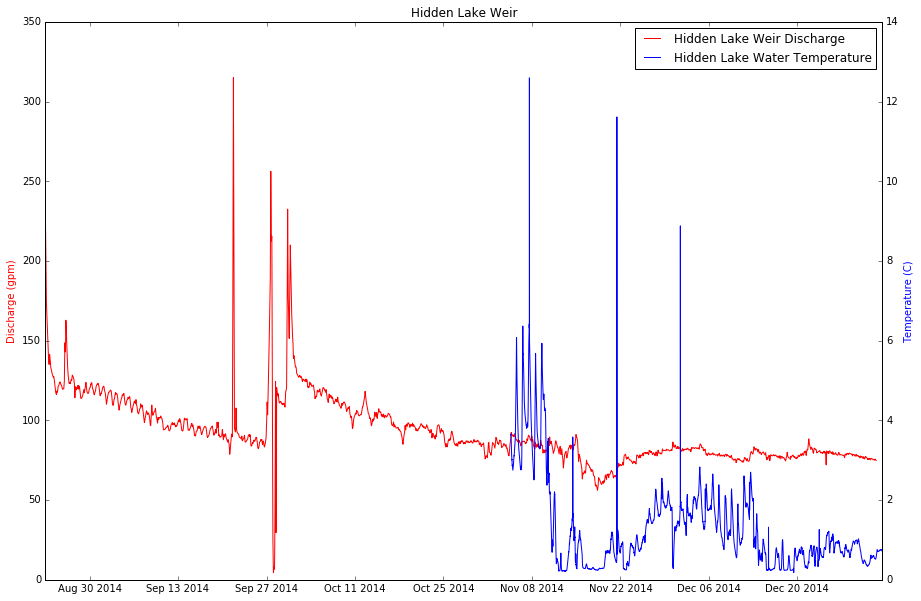

In [128]:
x1 = HidLake.index.to_datetime()
x2 = HidLake.index.to_datetime()

y1 = HidLake['HL_JF_Q_gpm']
y2 = HidLake['HL_LW_t_C']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Hidden Lake Weir')
ax1.plot(x1,y1,c='r',label='Hidden Lake Weir Discharge')
ax1.set_ylabel('Discharge (gpm)', color='r') 
ax2.set_ylabel('Temperature (C)', color='b') 
ax2.plot(x2,y2,c='b',label='Hidden Lake Water Temperature')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_xlim('8/23/2014',HidLake.index.to_datetime()[-1])
ax1.legend(h1+h2, l1+l2, loc=0)

plt.show()

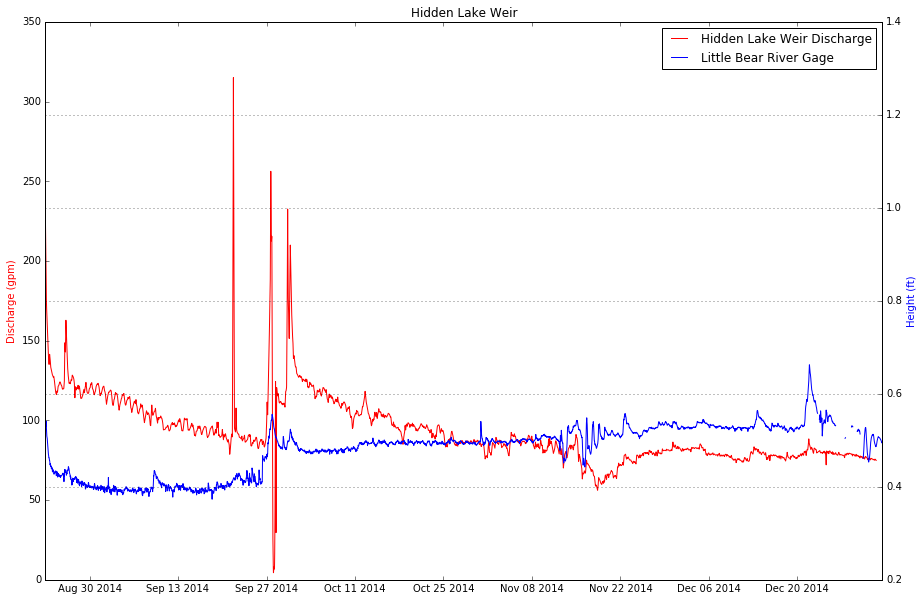

In [129]:
x1 = HidLake.index.to_datetime()
x2 = All.index.to_datetime()

y1 = HidLake['HL_JF_Q_gpm']
y2 = All['USU_SF_AD_h_ft']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Hidden Lake Weir')
ax1.plot(x1,y1,c='r',label='Hidden Lake Weir Discharge')
ax1.set_ylabel('Discharge (gpm)', color='r') 
ax2.set_ylabel('Height (ft)', color='b') 
ax2.plot(x2,y2,c='b',label='Little Bear River Gage')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_xlim('8/23/2014',HidLake.index.to_datetime()[-1])
ax1.legend(h1+h2, l1+l2, loc=0)
plt.grid(which='major', axis='both')
plt.show()

2207
2207
                            OLS Regression Results                            
Dep. Variable:            HL_JF_Q_gpm   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                 1.822e+04
Date:                Tue, 09 Feb 2016   Prob (F-statistic):               0.00
Time:                        09:21:42   Log-Likelihood:                -5779.6
No. Observations:                2207   AIC:                         1.156e+04
Df Residuals:                    2205   BIC:                         1.157e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       3.533e+06   2.62e+04    134.99

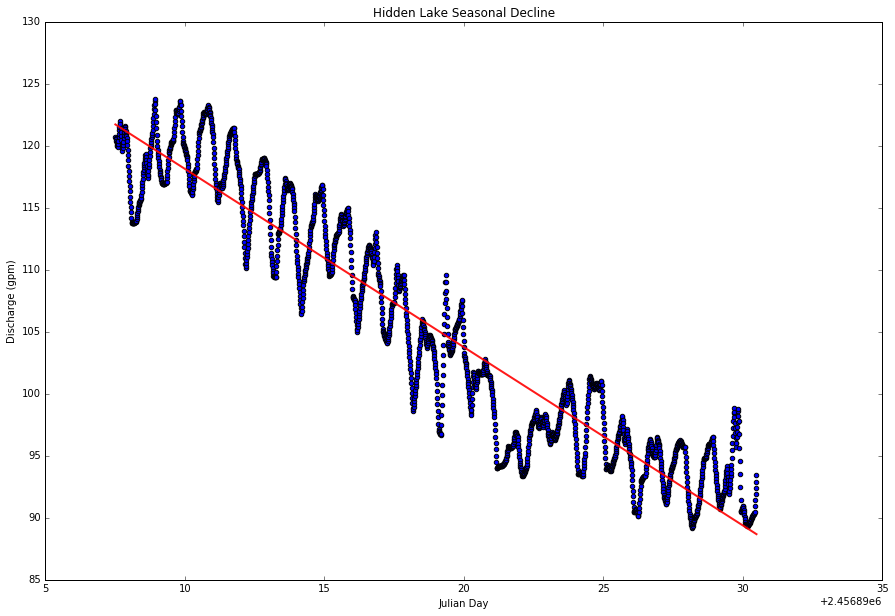

In [130]:
aHidLake = HidLake[(HidLake.index.to_datetime() < pd.datetime(2014,9,20))&(HidLake.index.to_datetime() > pd.datetime(2014,8,28))]
x0 = aHidLake.index.to_julian_date()
y = aHidLake['HL_JF_Q_gpm']
x = sm.add_constant(x0)
print len(x0)
print len(y)

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Hidden Lake Seasonal Decline')
plt.ylabel('Discharge (gpm)')
plt.xlabel('Julian Day')

3743
3743
                            OLS Regression Results                            
Dep. Variable:            HL_JF_Q_gpm   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                 1.582e+04
Date:                Tue, 09 Feb 2016   Prob (F-statistic):               0.00
Time:                        09:21:43   Log-Likelihood:                -10951.
No. Observations:                3743   AIC:                         2.191e+04
Df Residuals:                    3741   BIC:                         2.192e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       2.026e+06   1.61e+04    125.79

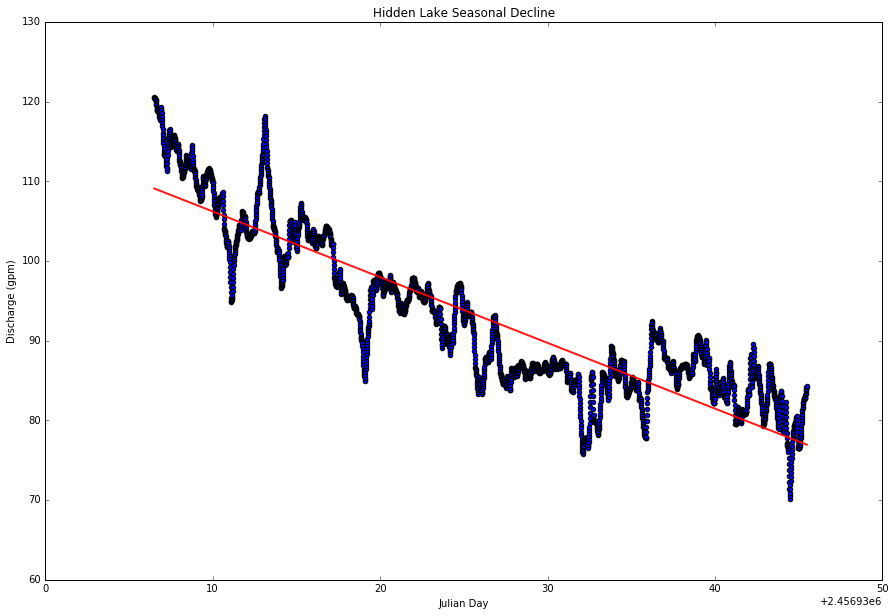

In [131]:
bHidLake = HidLake[(HidLake.index.to_datetime() < pd.datetime(2014,11,14))&(HidLake.index.to_datetime() > pd.datetime(2014,10,6))]
x0 = bHidLake.index.to_julian_date()
y = bHidLake['HL_JF_Q_gpm']
x = sm.add_constant(x0)
print len(x0)
print len(y)

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Hidden Lake Seasonal Decline')
plt.ylabel('Discharge (gpm)')
plt.xlabel('Julian Day')

In [132]:
HidLake = nodups(HidLake,All)

In [133]:
list(HidLake.columns.values)

['HL_LW_t_C',
 'HL_BP_LW_p_cm',
 'HL_BP_LW_t_C',
 'HL_BP_LW_p_ft',
 'HL_JF_t_C',
 'HL_LW_Q_gpm',
 'HL_JF_Q_gpm',
 'HL_JF_Q_cfs',
 'HL_LW_Q_cfs']

In [134]:
All = pd.merge(All, HidLake, left_index=True, right_index=True, how='outer')

In [135]:
#del (HidLake,HL_JF,HL_LW)

In [136]:
list(All.columns.values)

['USU_Avon_BP_mmHg',
 'USU_SF_BP_mmHg',
 'USU_SF_PPT_in',
 'USU_PPT_CDM',
 'USU_SF_AD_h_ft',
 'USU_SF_BD_h_ft',
 'Site Id',
 'WTEQ.I-1 (in) ',
 'PREC.I-1 (in) ',
 'TOBS.I-1 (degC) ',
 'SNWD.I-1 (in) ',
 'SMS.I-1:-2 (pct)  (silt)',
 'SMS.I-1:-8 (pct)  (silt)',
 'SMS.I-1:-20 (pct)  (silt)',
 'STO.I-1:-2 (degC) ',
 'STO.I-1:-8 (degC) ',
 'STO.I-1:-20 (degC) ',
 'SAL.I-1:-2 (gram) ',
 'SAL.I-1:-8 (gram) ',
 'SAL.I-1:-20 (gram) ',
 'RDC.I-1:-2 (unit) ',
 'RDC.I-1:-8 (unit) ',
 'RDC.I-1:-20 (unit) ',
 'BATT.I-1 (volt) ',
 'Unnamed: 20',
 'SForkWolfCreek',
 'OtherQuartzite',
 'NorthForkofWolfCreek',
 'LeftysCreek',
 'JamesPeakFork',
 'HiddenLakeFork',
 'CobabeCreek',
 'NorthSide',
 'SouthSide',
 'UL_BP_LW_p_cm',
 'UL_BP_LW_p_ft',
 'UL_BP_LW_t_C',
 'UL_JF_Q_cfs',
 'UL_JF_Q_gpm',
 'UL_JF_t_C',
 'UL_LW_Q_cfs',
 'UL_LW_Q_gpm',
 'UL_LW_t_C',
 'LL_LW_t_C',
 'LL_JF_t_C',
 'LL_LW_Q_gpm',
 'LL_JF_Q_gpm',
 'LL_JF_Q_cfs',
 'LL_LW_Q_cfs',
 'HL_LW_t_C',
 'HL_BP_LW_p_cm',
 'HL_BP_LW_t_C',
 'HL_BP_LW_p_ft',

## North Boundary Weir

### Importing and Converting North Boundary Weir Data

[To top of page](#top)

Import North Boundary weir data from Loughlin. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=nb></a>

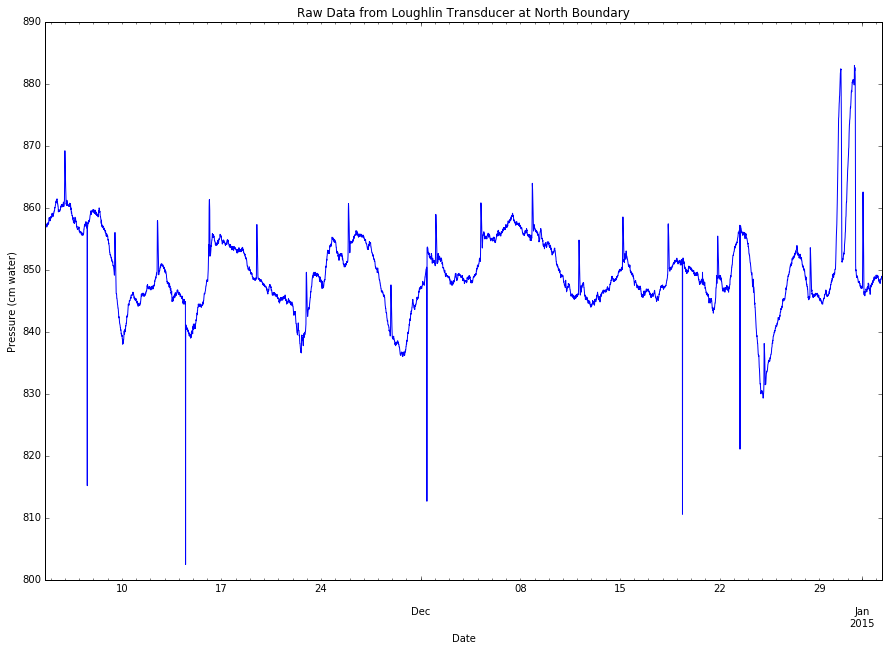

In [137]:
NB_LW = pd.read_csv(North_Boundary_Loughlin,
                    index_col=0, skiprows=52, skipfooter=1, parse_dates=True, 
                    names=['dt','NB_LW_p_cm','NB_LW_t_C'], engine='python',na_values='' )

NB_LW['NB_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Raw Data from Loughlin Transducer at North Boundary')

In [138]:
NB_LW['NB_LW_dp_cm'] = NB_LW['NB_LW_p_cm'].diff()
NB_LW_Jump = NB_LW[abs(NB_LW['NB_LW_dp_cm'])>10][2:]
NB_LW_Jump['diff'] = abs(NB_LW['NB_LW_dp_cm'][2:]).diff()
mdiff = (abs(NB_LW_Jump['diff'][1])+abs(NB_LW_Jump['diff'][3]))/2
print mdiff
print NB_LW_Jump

3.471
                     NB_LW_p_cm  NB_LW_t_C  NB_LW_dp_cm    diff
dt                                                             
2014-11-14 11:30:00     802.500     13.420      -42.408  42.350
2014-11-14 11:45:00     841.175      3.847       38.675  -3.733
2014-12-01 10:30:00     812.708      9.127      -37.625  37.508
2014-12-01 10:45:00     853.542      4.163       40.834   3.209
2014-12-19 09:30:00     810.608      1.933      -40.950  40.600
2014-12-19 09:45:00     851.733      2.697       41.125   0.175
2014-12-23 10:30:00     821.108     -0.237      -36.109  35.875
2014-12-23 10:45:00     856.283      0.383       35.175  -0.934
2014-12-30 14:00:00     852.025      0.317      -11.958   2.624
2014-12-31 13:15:00     855.700      0.290      -18.492  11.434


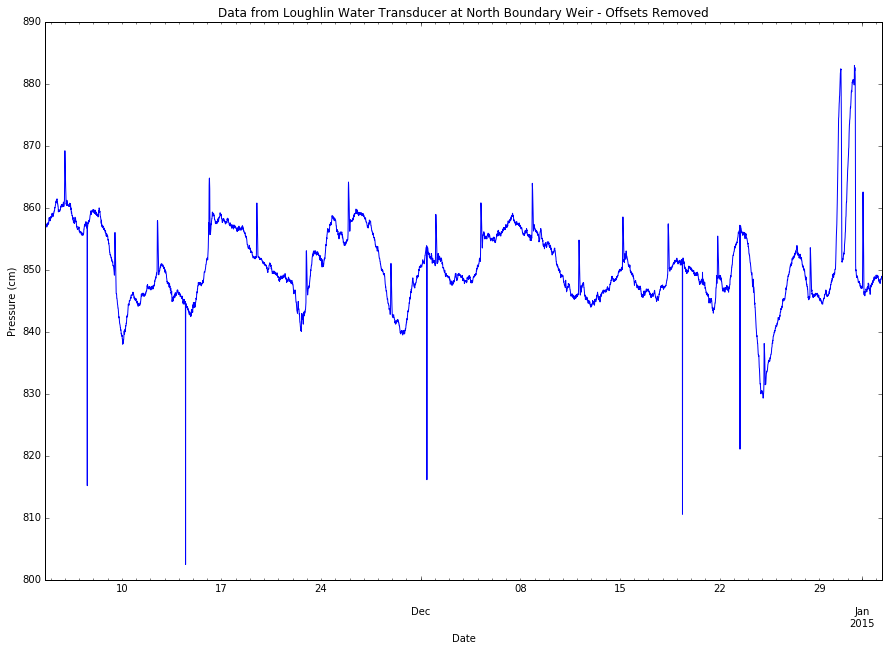

In [139]:
for i in NB_LW.index:
    if i >= NB_LW_Jump.index[1] and i <= NB_LW_Jump.index[2]:
        NB_LW['NB_LW_p_cm'][i]=NB_LW['NB_LW_p_cm'][i]+mdiff
    else:
        NB_LW['NB_LW_p_cm'][i] = NB_LW['NB_LW_p_cm'][i]

NB_LW['NB_LW_p_cm'].plot()
plt.ylabel('Pressure (cm)')
plt.xlabel('Date')
plt.title('Data from Loughlin Water Transducer at North Boundary Weir - Offsets Removed')

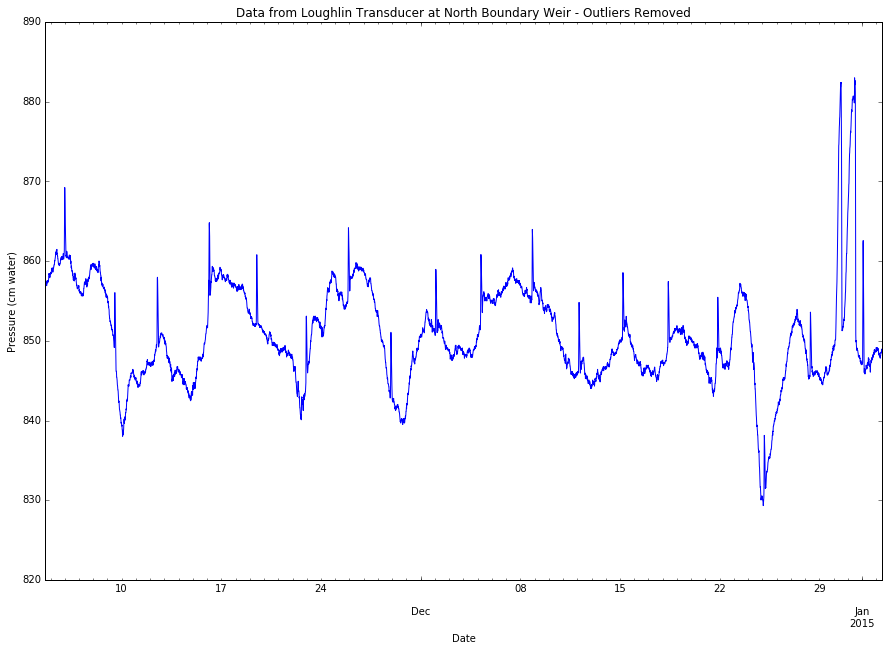

In [140]:
NB_LW = wt.smoother(NB_LW, 'NB_LW_p_cm', 50, 3)
NB_LW['NB_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Data from Loughlin Transducer at North Boundary Weir - Outliers Removed')

Import the barometric pressure data from the Hidden Lake weir barometer (north side barometer), maintained by Loughlin. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=nbbp></a>

In [141]:
HL_BP_LW = pd.read_csv(Hidden_Lake_Barometer_Loughlin, 
                    index_col=0, skiprows=52, skipfooter=1, parse_dates=True, names=['dt','HL_BP_LW_p_cm','HL_BP_LW_t_C'], 
                    engine='python')

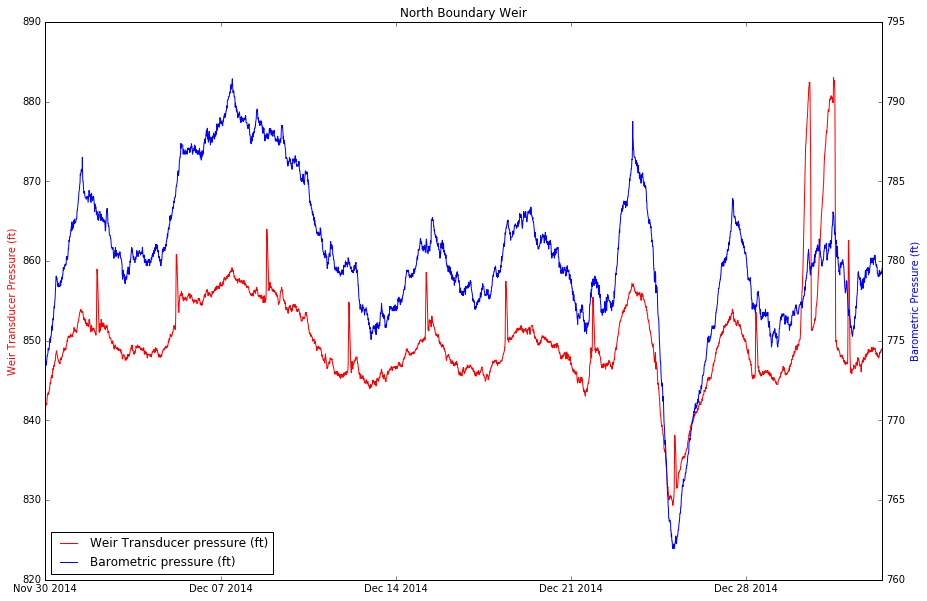

In [142]:
plt.figure()
x1 = NB_LW.index.to_datetime()
y1 = NB_LW['NB_LW_p_cm']

x2 = HL_BP_LW.index.to_datetime()
y2 = HL_BP_LW['HL_BP_LW_p_cm']

fig, ax1 = plt.subplots()
plt.title('North Boundary Weir')
ax2 = ax1.twinx()
ax1.plot(x1,y1,c='r',label='Weir Transducer pressure (ft)')
ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='r') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x2,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

In [143]:
NBound = pd.merge(NB_LW, HL_BP_LW, left_index=True, right_index=True, how='outer')
NBound['NB_LW_p_ft'] =(NBound['NB_LW_p_cm'] - NBound['HL_BP_LW_p_cm'])*0.0328084
NBound['HL_BP_LW_p_ft'] = NBound['HL_BP_LW_p_cm']*0.0328084

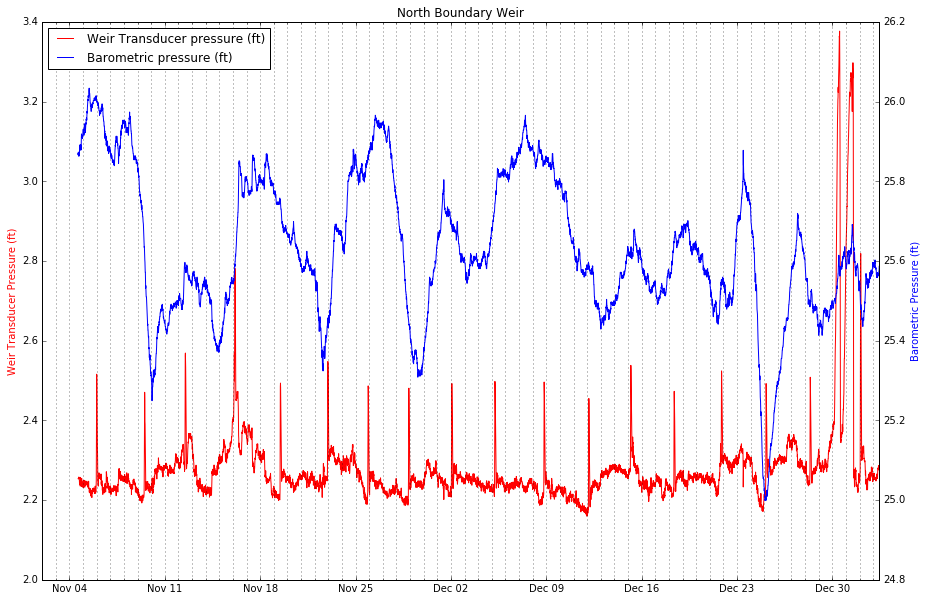

In [144]:
x = NBound.index.to_datetime()
y1 = NBound['NB_LW_p_ft']
y2 = NBound['HL_BP_LW_p_ft']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('North Boundary Weir')
ax1.plot(x,y1,c='r',label='Weir Transducer pressure (ft)')
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='r') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_xlim('11/2/2014',x[-1])
ax1.xaxis.set_minor_locator(dates.DayLocator())
ax1.xaxis.set_major_locator(dates.WeekdayLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('%b %d'))
ax1.legend(h1+h2, l1+l2, loc=0)
ax1.xaxis_date()
ax1.autoscale_view()
ax1.grid(which='minor')
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

Import the UGS data from the North Boundary weir. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=nbugs></a>

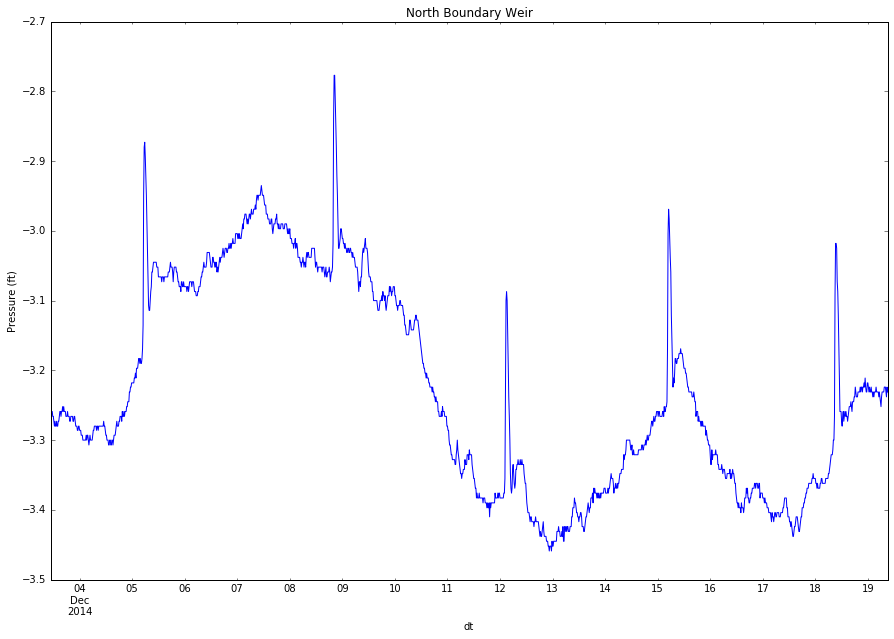

In [145]:
NB_US = pd.read_csv(North_Boundary_UGS, 
                     index_col=0, skiprows=17, skipfooter=1, parse_dates={'dt':[0,1]}, 
                     names=['date','time','ms','NB_US_p_ft','NB_US_t_C'], engine='python')
NB_US['NB_US_p_ft'].plot()
plt.title('North Boundary Weir')
plt.ylabel('Pressure (ft)')

Import manual data. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=northman></a>

In [146]:
NB_manual = pd.read_excel(North_Boundary_Manual, 'NorthBoundWeir', index_col=0, 
                          parse_cols=[0,1,2], skiprows=0, na_values=['NA',''],
                          names=['date','NB_vdepth_in','NB_depth_in'], skip_footer=0, parse_dates=True)
NB_manual['NB_offset_ft'] = (NB_manual['NB_depth_in']/12-NB_manual['NB_vdepth_in']/12).mean()
NB_manual['NB_depth_ft'] = NB_manual['NB_vdepth_in']/12+NB_manual['NB_offset_ft']
NB_manual = NB_manual.sort_index()
NB_manual = NB_manual[ NB_manual.index.to_datetime()>pd.datetime(2014,7,25)]
print NB_manual

                     NB_vdepth_in  NB_depth_in  NB_offset_ft  NB_depth_ft
date                                                                     
2014-08-27 14:00:00        5.0000          NaN      0.060897     0.477564
2014-09-15 14:05:00        4.8750       4.9375      0.060897     0.467147
2014-10-02 00:00:00        5.6250       6.5625      0.060897     0.529647
2014-10-28 00:00:00        4.8750       6.0000      0.060897     0.467147
2014-11-04 13:56:00        5.2500       5.9375      0.060897     0.498397
2014-11-04 14:42:00        5.1875       5.8750      0.060897     0.493189
2014-11-10 12:15:00        5.3750       5.9375      0.060897     0.508814
2014-11-14 11:23:00        5.1250       5.9375      0.060897     0.487981
2014-11-21 09:55:00        5.2500       5.8750      0.060897     0.498397
2014-12-01 10:36:00        4.8750       5.6250      0.060897     0.467147
2014-12-05 10:37:00        5.0000       6.1875      0.060897     0.477564
2014-12-12 09:29:00        4.9375     

In [147]:
meanDiff = rollmeandiff(NB_manual,'NB_depth_ft',NBound,'NB_LW_p_ft',5)
print meanDiff
NBound['NB_LW_h_ft'] = NBound['NB_LW_p_ft'] + meanDiff

-1.778


In [148]:
NBound = pd.merge(NBound, NB_US, left_index=True, right_index=True, how='outer')

In [149]:
NBound['HL_BP_LW_p_ft']=NBound['HL_BP_LW_p_cm']/2.54/12
meanDiff = rollmeandiff(NBound,'NB_US_p_ft',NBound,'HL_BP_LW_p_ft',5)
print meanDiff
NBound['NB_US_p_adj_ft'] = NBound['NB_US_p_ft'] - meanDiff

-28.825


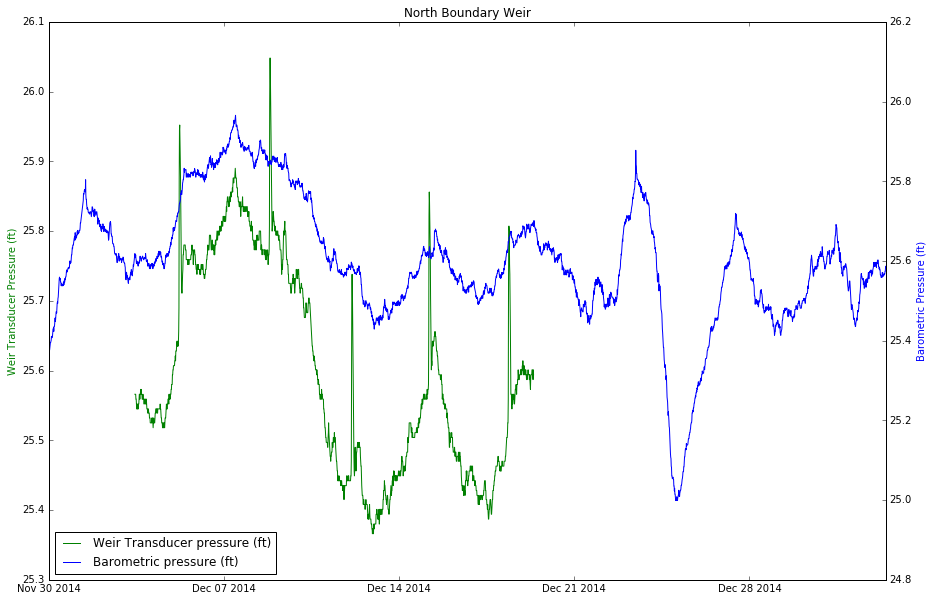

In [150]:
plt.figure()
x1 = NBound.index.to_datetime()

y1 = NBound['NB_US_p_adj_ft']
y2 = NBound['HL_BP_LW_p_ft']

fig, ax1 = plt.subplots()
plt.title('North Boundary Weir')
ax2 = ax1.twinx()
ax1.plot(x1,y1,c='g',label='Weir Transducer pressure (ft)')
ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='g') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x2,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

In [151]:
NBound['NB_US_p_adj_noBP_ft']=NBound['NB_US_p_adj_ft']-NBound['HL_BP_LW_p_ft']

In [152]:
meanDiff = rollmeandiff(NB_manual,'NB_depth_ft',NBound,'NB_US_p_adj_noBP_ft',5)
print meanDiff
NBound['NB_US_h_ft'] = NBound['NB_US_p_adj_noBP_ft'] + meanDiff

0.539


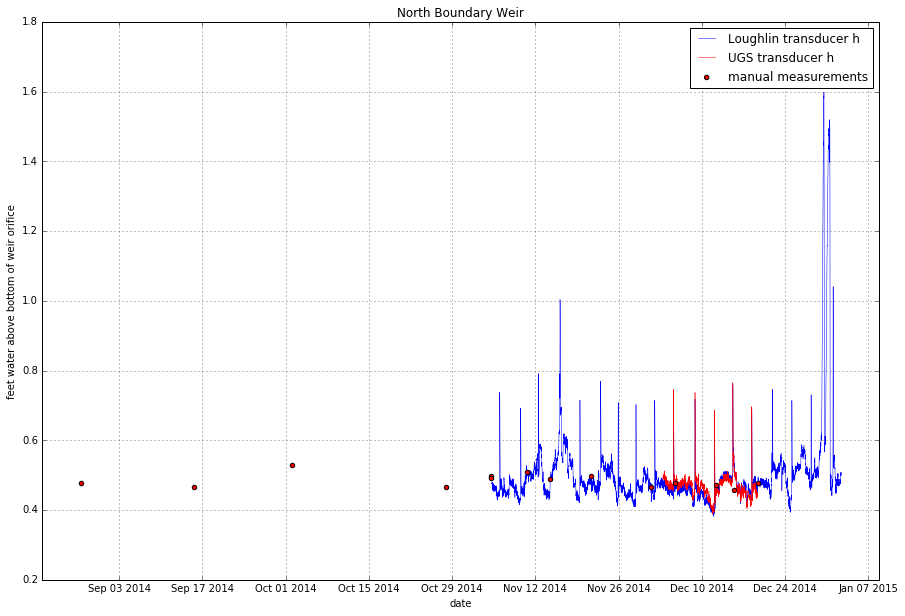

In [153]:
plt.figure()

x = NBound.index.to_datetime()
y = NBound['NB_LW_h_ft']

x1 = NB_manual.index.to_datetime()
y1 = NB_manual['NB_depth_ft']

y2 = NBound['NB_US_h_ft']

plt.plot(x, y, zorder=1, c='blue', linewidth=0.5, label='Loughlin transducer h')
plt.plot(x, y2, zorder=2, c='red', linewidth=0.5, label='UGS transducer h')
plt.scatter(x1, y1, c='red', zorder=3, label='manual measurements')
plt.title('North Boundary Weir')
plt.ylabel('feet water above bottom of weir orifice')
plt.xlabel('date')
plt.grid()
plt.legend(scatterpoints=1)


Once the transducer data were aligned with manual readings, we converted the height of water above the bottom of the weir orifice to discharge in both gpm and cfs.

To do this, we used equations from: U.S. Bureau of Reclamation, 2001, Water Measurement Manual - A water resources technical publication: online, http://www.usbr.gov/pmts/hydraulics_lab/pubs/wmm/.

For Cipoletti (trapezoidal) weirs, the equation to calculate discharge from h is:
$$
Q= 1511\cdot h^{\frac{3}{2}}
$$
<ul>
  <li>h = feet above bottom of weir orifice</li>
  <li>Q = discharge in gpm</li>
</ul>

In [154]:
NBound['NB_US_Q_gpm']=(NBound['NB_US_h_ft']**1.5)*1511
NBound['NB_LW_Q_gpm']=(NBound['NB_LW_h_ft']**1.5)*1511
NB_manual['NB_man_Q_ft'] = (NB_manual['NB_depth_ft']**1.5)*1511 
NBound['NB_US_Q_cfs']=0.00222800926*NBound['NB_US_Q_gpm']
NBound['NB_LW_Q_cfs']=0.00222800926*NBound['NB_LW_Q_gpm']

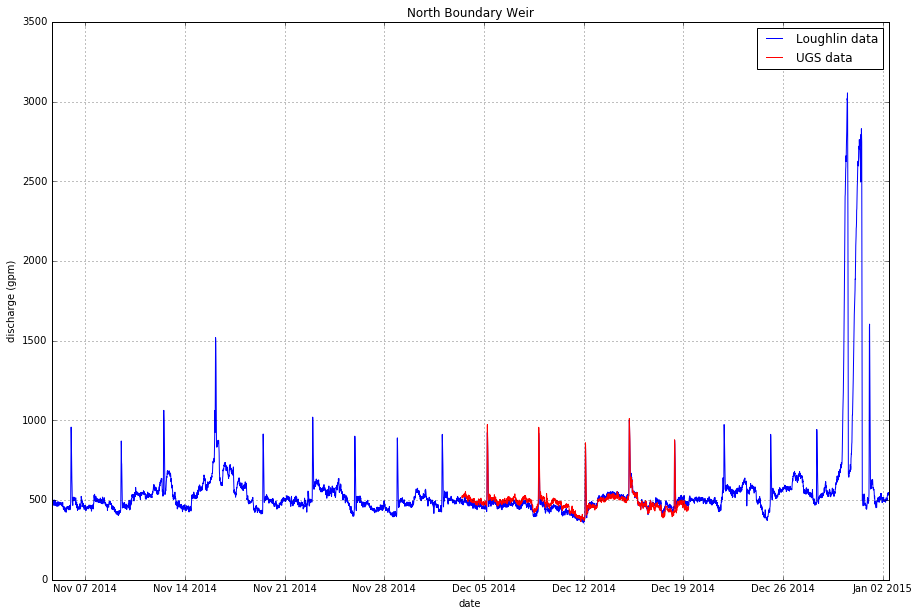

In [155]:
plt.figure()
x = NBound.index.to_datetime()
y1 = NBound['NB_LW_Q_gpm']
y2 = NBound['NB_US_Q_gpm']

y3 = pd.rolling_mean(y1, window=86, center=True)
y4 = pd.rolling_mean(y2, window=48, center=True)

plt.figure()
plt.plot(x,y1, color='blue', zorder=1, label='Loughlin data')
plt.plot(x,y2, color='red', zorder=2, label='UGS data')
plt.title('North Boundary Weir')
plt.ylabel('discharge (gpm)')
plt.xlabel('date')
plt.grid()

plt.legend()

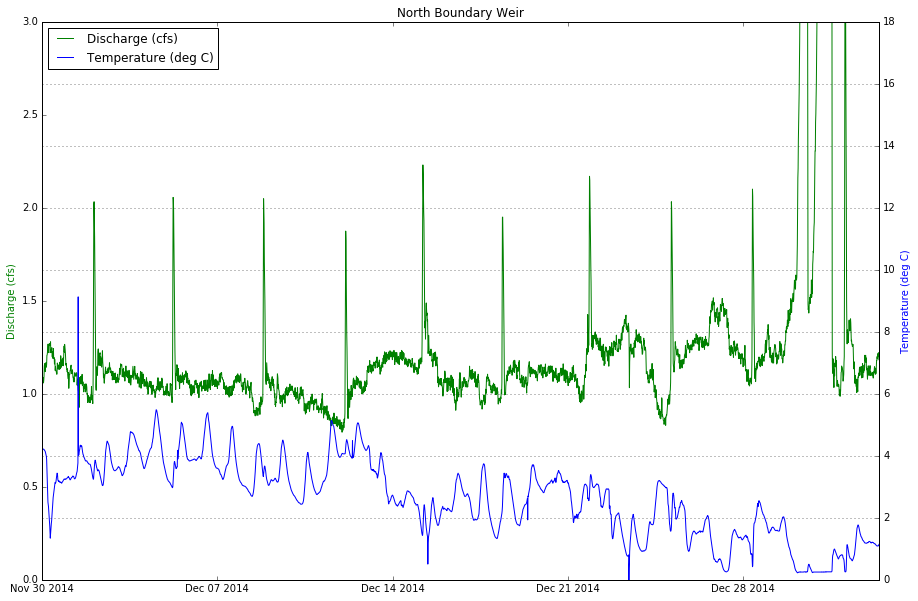

In [156]:
plt.figure()
x1 = NBound.index.to_datetime()

y1 = NBound['NB_LW_Q_cfs']
y2 = NBound['NB_LW_t_C']

fig, ax1 = plt.subplots()
plt.title('North Boundary Weir')
ax2 = ax1.twinx()
ax1.plot(x1,y1,c='g',label='Discharge (cfs)')
ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylim(0,3)
ax2.set_ylim(0,18)
ax1.set_ylabel('Discharge (cfs)', color='g') 
ax2.set_ylabel('Temperature (deg C)', color='b') 
ax2.plot(x1,y2,c='b',label='Temperature (deg C)')
plt.grid()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2)

plt.show()

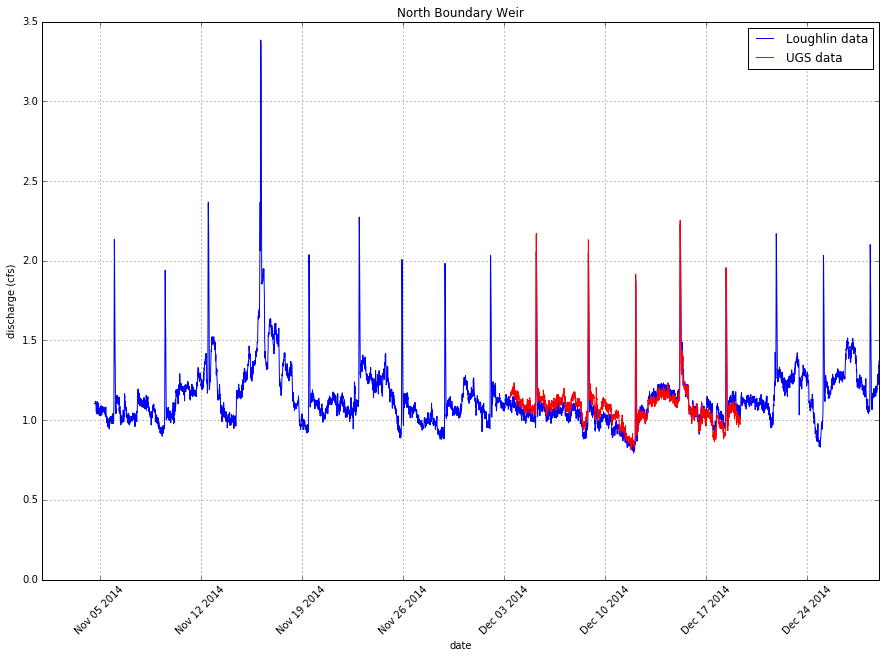

In [157]:
plt.figure()
x = NBound.index.to_datetime()
y1 = NBound['NB_LW_Q_cfs']
y2 = NBound['NB_US_Q_cfs']

y3 = pd.rolling_mean(y1, window=86, center=True)
y4 = pd.rolling_mean(y2, window=48, center=True)

plt.figure()
plt.plot(x,y1, color='blue', zorder=1, label='Loughlin data')
plt.plot(x,y2, color='red', zorder=2, label='UGS data')
plt.title('North Boundary Weir')
plt.ylabel('discharge (cfs)')
plt.xlabel('date')
plt.xlim('11/1/2014','12/29/2014')
plt.grid(which='both')
plt.xticks(rotation=45)
plt.ylim(0,3.5)
plt.legend()
plt.savefig(rootlocal+"NorthBoundaryWeir.pdf")

In [158]:
NBound = nodups(NBound,All)

In [159]:
list(NBound.columns.values)

['NB_LW_t_C',
 'NB_US_t_C',
 'NB_US_Q_gpm',
 'NB_LW_Q_gpm',
 'NB_US_Q_cfs',
 'NB_LW_Q_cfs']

In [160]:
All = pd.merge(All, NBound, left_index=True, right_index=True, how='outer')

In [161]:
#del (NB_LW,NBound)

## Wells

[Hidden Lake Well](#Hidden-Lake-Well)
[Exploration Well 2](#Exploration-Well-2)
[Aquifer Test Hydrographs](#Aquifer-Test-Hydrographs)

### Hidden Lake Well

[To Top](#top)

This is the pumping well. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=hlw></a>

In [162]:
HLW = pd.read_excel(Hidden_Lake_Well, 'PowderMt-01-01-2014', index_col=0, 
                  skiprows=5, skipfooter=0, parse_cols=[0,2,3],
                  names=['date','HLW_h_ft','HLW_Q_gpm'])

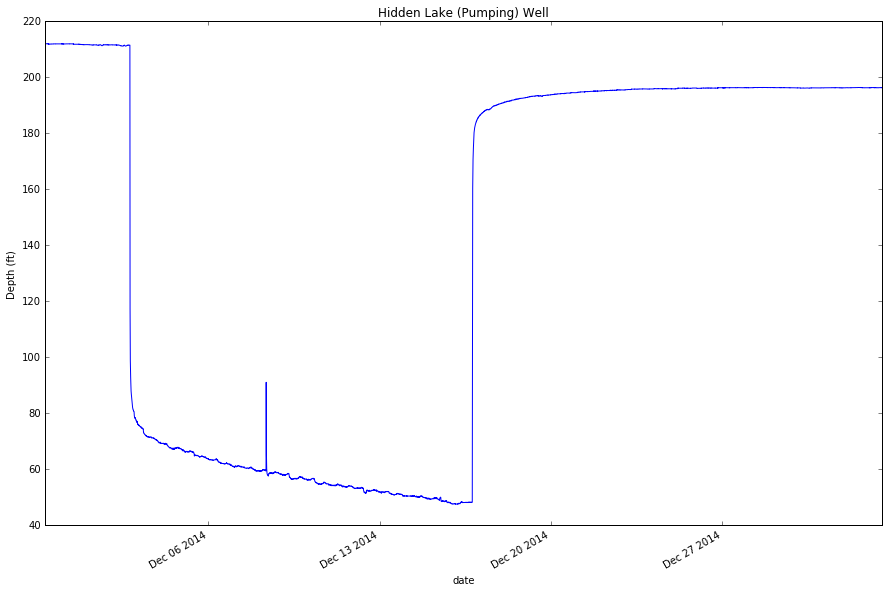

In [163]:
HLW['HLW_h_ft'].plot()
plt.title('Hidden Lake (Pumping) Well')
plt.ylabel('Depth (ft)')

The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=hlwman></a>

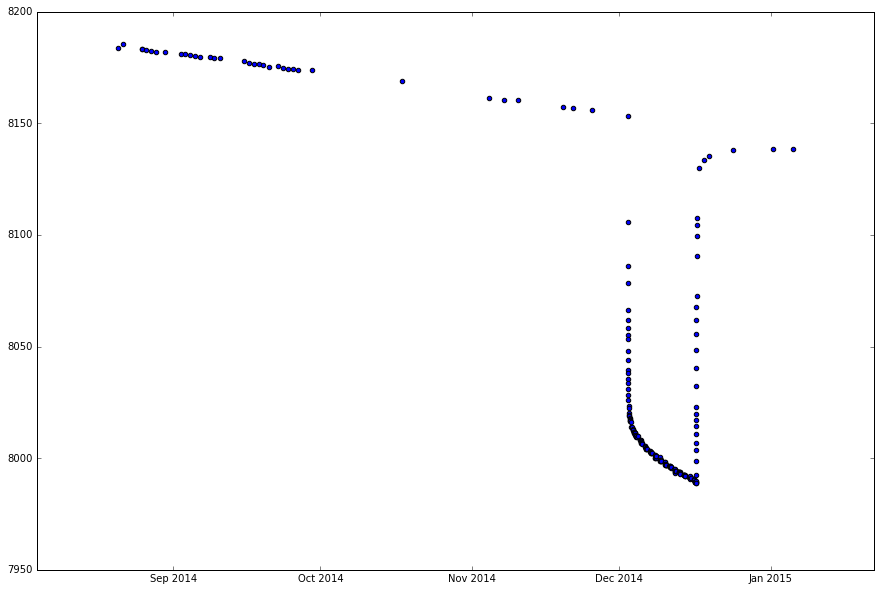

In [164]:
HLWM = pd.read_excel(Hidden_Lake_Well_Manual, 'HiddenLakeWell', index_col=0, 
                     skiprows=0, parse_cols=[0,1], names=['date','hlw_dtw_man_ft'])
HLWM['HLWM_wl_elev'] = 8904-HLWM['hlw_dtw_man_ft']

x1 = HLWM.index.to_datetime()
y1 = HLWM['HLWM_wl_elev']

plt.figure()
plt.scatter(x1,y1)

In [165]:
meanDiff = rollmeandiff(HLWM,'HLWM_wl_elev',HLW,'HLW_h_ft',2)
print meanDiff
HLW['HLW_wl_elev_ft'] = HLW['HLW_h_ft'] + meanDiff

7941.972


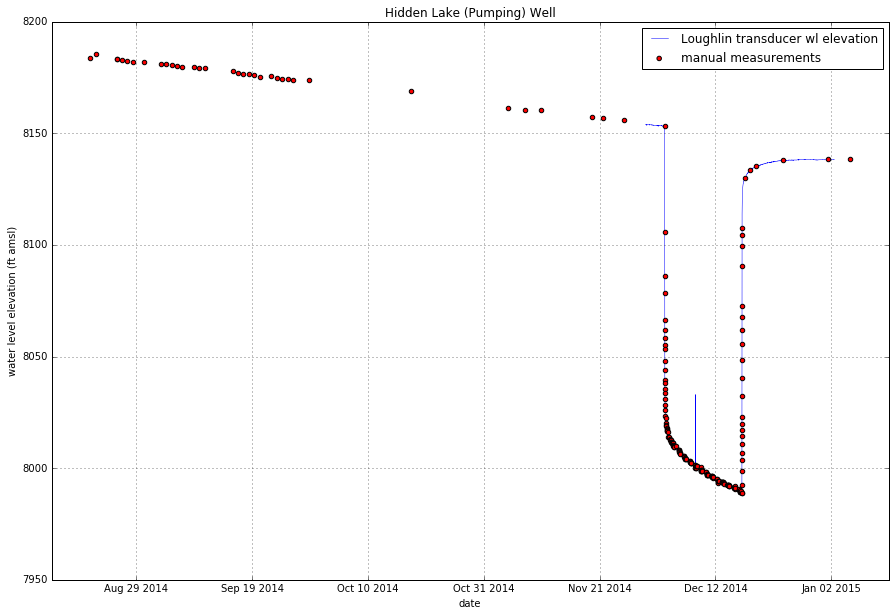

In [166]:
plt.figure()

x = HLW.index.to_datetime()
y = HLW['HLW_wl_elev_ft']

x1 = HLWM.index.to_datetime()
y1 = HLWM['HLWM_wl_elev']

plt.plot(x, y, zorder=1, c='blue', linewidth=0.5, label='Loughlin transducer wl elevation')
plt.scatter(x1, y1, c='red', zorder=3, label='manual measurements')
plt.title('Hidden Lake (Pumping) Well')
plt.ylabel('water level elevation (ft amsl)')
plt.xlabel('date')
plt.grid()
plt.legend(scatterpoints=1)

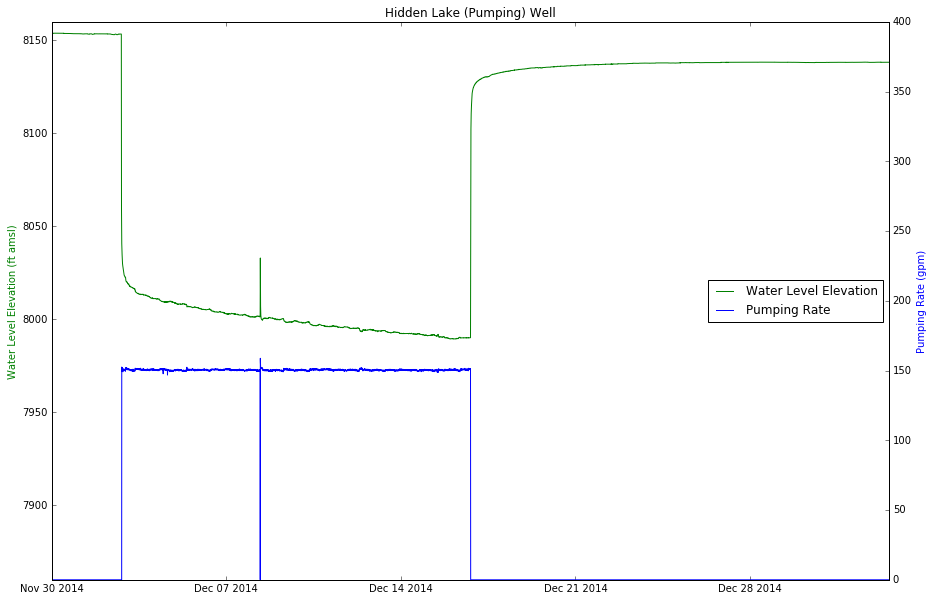

In [167]:
plt.figure()

x1 = HLW.index.to_datetime()
y1 = HLW['HLW_wl_elev_ft']

x2 = HLW.index.to_datetime()
y2 = HLW['HLW_Q_gpm']


fig, ax1 = plt.subplots()
plt.title('Hidden Lake (Pumping) Well')
ax2 = ax1.twinx()
ax1.plot(x1,y1,c='g',label='Water Level Elevation', zorder=1)
ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylabel('Water Level Elevation (ft amsl)', color='g') 
ax2.set_ylabel('Pumping Rate (gpm)', color='b') 
ax2.plot(x2,y2,c='b',label='Pumping Rate', zorder=2)
#plt.gca().invert_yaxis()
ax1.set_ylim(7860,8160)
ax2.set_ylim(0,400)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=7)


plt.show()

2014-11-29 08:00:01
                            OLS Regression Results                            
Dep. Variable:         HLW_wl_elev_ft   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     2808.
Date:                Tue, 09 Feb 2016   Prob (F-statistic):          2.11e-258
Time:                        09:22:05   Log-Likelihood:                 859.40
No. Observations:                 768   AIC:                            -1715.
Df Residuals:                     766   BIC:                            -1706.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       4.911e+05   9113.728

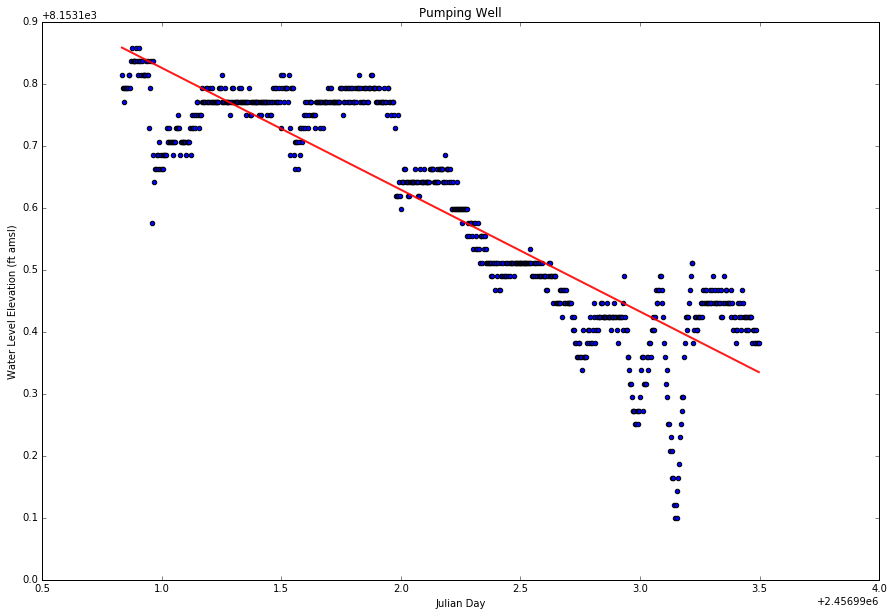

In [168]:
y = HLW['HLW_wl_elev_ft'][HLW.index.to_datetime() < pd.datetime(2014,12,2,0,0)]
x0 = HLW.index.to_julian_date()[HLW.index.to_datetime() < pd.datetime(2014,12,2,0,0)]
x = sm.add_constant(x0)
print(min(HLW.index))
plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Pumping Well')
plt.ylabel('Water Level Elevation (ft amsl)')
plt.xlabel('Julian Day')

2014-08-20 15:00:00
                            OLS Regression Results                            
Dep. Variable:           HLWM_wl_elev   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     8583.
Date:                Tue, 09 Feb 2016   Prob (F-statistic):           1.83e-41
Time:                        09:22:05   Log-Likelihood:                -26.454
No. Observations:                  35   AIC:                             56.91
Df Residuals:                      33   BIC:                             60.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       7.476e+05   7980.969

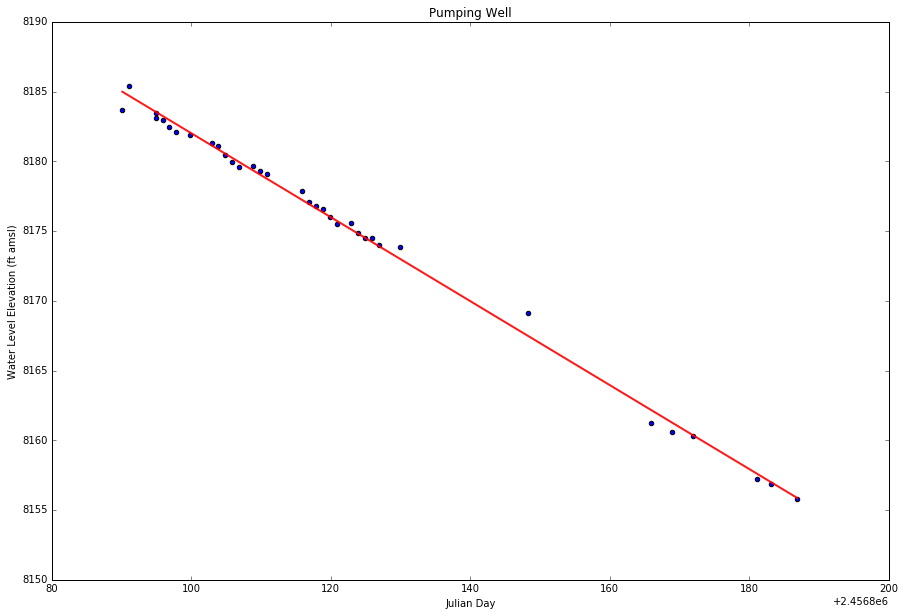

In [169]:
y = HLWM['HLWM_wl_elev'][HLWM.index.to_datetime() < pd.datetime(2014,12,2,0,0)]
x0 = HLWM.index.to_julian_date()[HLWM.index.to_datetime() < pd.datetime(2014,12,2,0,0)]
x = sm.add_constant(x0)
print min(HLWM.index)
plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Pumping Well')
plt.ylabel('Water Level Elevation (ft amsl)')
plt.xlabel('Julian Day')

In [170]:
HLW = HLW.resample('1Min', how='mean')
HLW = HLW.interpolate(method='time', limit=90)
HLW = HLW.resample('5Min', how='mean')

In [171]:
HLW15 = HLW.resample('15Min', how='mean')

In [172]:
All=pd.merge(All, HLW15, left_index=True, right_index=True, how='outer')

In [173]:
list(All.columns.values)

['USU_Avon_BP_mmHg',
 'USU_SF_BP_mmHg',
 'USU_SF_PPT_in',
 'USU_PPT_CDM',
 'USU_SF_AD_h_ft',
 'USU_SF_BD_h_ft',
 'Site Id',
 'WTEQ.I-1 (in) ',
 'PREC.I-1 (in) ',
 'TOBS.I-1 (degC) ',
 'SNWD.I-1 (in) ',
 'SMS.I-1:-2 (pct)  (silt)',
 'SMS.I-1:-8 (pct)  (silt)',
 'SMS.I-1:-20 (pct)  (silt)',
 'STO.I-1:-2 (degC) ',
 'STO.I-1:-8 (degC) ',
 'STO.I-1:-20 (degC) ',
 'SAL.I-1:-2 (gram) ',
 'SAL.I-1:-8 (gram) ',
 'SAL.I-1:-20 (gram) ',
 'RDC.I-1:-2 (unit) ',
 'RDC.I-1:-8 (unit) ',
 'RDC.I-1:-20 (unit) ',
 'BATT.I-1 (volt) ',
 'Unnamed: 20',
 'SForkWolfCreek',
 'OtherQuartzite',
 'NorthForkofWolfCreek',
 'LeftysCreek',
 'JamesPeakFork',
 'HiddenLakeFork',
 'CobabeCreek',
 'NorthSide',
 'SouthSide',
 'UL_BP_LW_p_cm',
 'UL_BP_LW_p_ft',
 'UL_BP_LW_t_C',
 'UL_JF_Q_cfs',
 'UL_JF_Q_gpm',
 'UL_JF_t_C',
 'UL_LW_Q_cfs',
 'UL_LW_Q_gpm',
 'UL_LW_t_C',
 'LL_LW_t_C',
 'LL_JF_t_C',
 'LL_LW_Q_gpm',
 'LL_JF_Q_gpm',
 'LL_JF_Q_cfs',
 'LL_LW_Q_cfs',
 'HL_LW_t_C',
 'HL_BP_LW_p_cm',
 'HL_BP_LW_t_C',
 'HL_BP_LW_p_ft',

### Exploration Well 2

[To Top](#top)

The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=exw></a>

In [174]:
EXW = pd.read_csv(Exploration_Well_2, index_col=0, parse_dates=True,
                  skiprows=89, usecols=[0,2,3], names=['date','EXW_p_psi','EXW_t_C'])
EXW['EXW_p_ft']=EXW['EXW_p_psi']*2.307

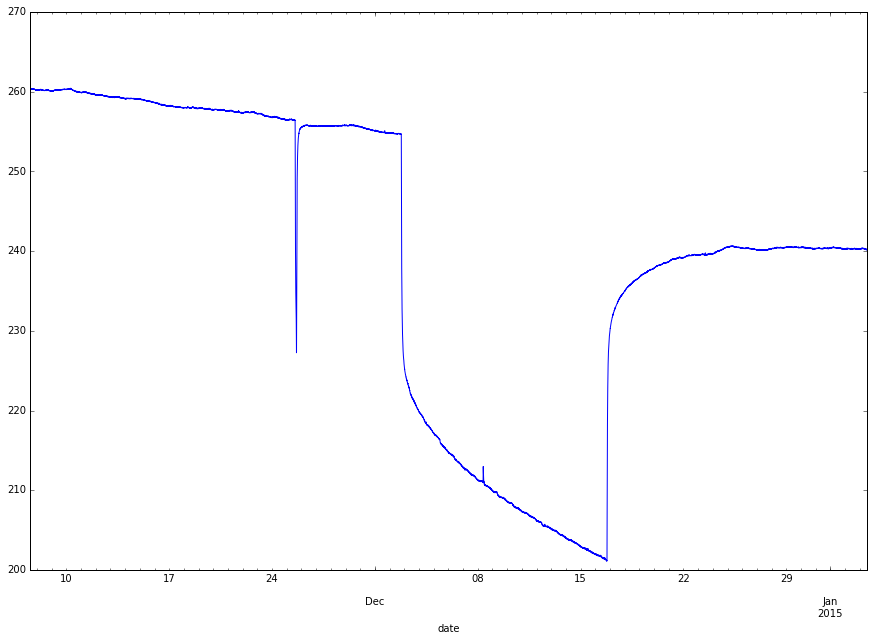

In [175]:
EXW['EXW_p_ft'].plot()

The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=exman></a>

In [176]:
EXWM = pd.read_excel(Exploration_Well_2_Manual,'ExpWell2',names=['date','EXWM_h_ft'],index_col=0)
print EXWM

                     EXWM_h_ft
date                          
2014-10-17 13:30:00     735.32
2014-11-07 11:34:00     743.94


In [177]:
oldwl = pd.read_excel(oldwls2013,'Sheet1',names=['date','EXW_h_ft','pumpMin','s_ft','rateGPM'],index_col=0)

In [178]:
EXW['EXW_wl_elev_ft'] = EXW['EXW_p_ft']+7896.5
oldwl['EXW_wl_elev_ft'] = 8901 - oldwl['EXW_h_ft']

In [179]:
EXWall = pd.concat([EXW, oldwl],axis=0)
EXWall.sort_index(inplace=True)

In [180]:
EXWall.dropna(subset=['EXW_wl_elev_ft'],inplace=True)

In [181]:
Leftys

UL_BP_LW_p_cm  UL_BP_LW_p_ft  UL_BP_LW_t_C  UL_JF_Q_cfs  \
2013-07-30 13:15:00            NaN            NaN           NaN          NaN   
2013-07-30 13:30:00            NaN            NaN           NaN          NaN   
2013-07-30 13:45:00            NaN            NaN           NaN          NaN   
2013-07-30 14:00:00            NaN            NaN           NaN          NaN   
2013-07-30 14:15:00            NaN            NaN           NaN          NaN   
2013-07-30 14:30:00            NaN            NaN           NaN          NaN   
2013-07-30 14:45:00            NaN            NaN           NaN          NaN   
2013-07-30 15:00:00            NaN            NaN           NaN          NaN   
2013-07-30 15:15:00            NaN            NaN           NaN          NaN   
2013-07-30 15:30:00            NaN            NaN           NaN          NaN   
2013-07-30 15:45:00            NaN            NaN           NaN          NaN   
2013-07-30 16:00:00            NaN            NaN           NaN          NaN   
2013-07-30 16:15:00            NaN            NaN           NaN          NaN   
2013-07-30 16:30:00            NaN            NaN           NaN          NaN   
2013-07-30 16:45:00            NaN            NaN           NaN          NaN   
2013-07-30 17:00:00            NaN            NaN           NaN          NaN   
2013-07-30 17:15:00            NaN            NaN           NaN          NaN   
2013-07-30 17:30:00            NaN            NaN           NaN          NaN   
2013-07-30 17:45:00            NaN            NaN           NaN          NaN   
2013-07-30 18:00:00            NaN            NaN           NaN          NaN   
2013-07-30 18:15:00            NaN            NaN           NaN          NaN   
2013-07-30 18:30:00            NaN            NaN           NaN          NaN   
2013-07-30 18:45:00            NaN            NaN           NaN          NaN   
2013-07-30 19:00:00            NaN            NaN           NaN          NaN   
2013-07-30 19:15:00            NaN            NaN           NaN          NaN   
2013-07-30 19:30:00            NaN            NaN           NaN          NaN   
2013-07-30 19:45:00            NaN            NaN           NaN          NaN   
2013-07-30 20:00:00            NaN            NaN           NaN          NaN   
2013-07-30 20:15:00            NaN            NaN           NaN          NaN   
2013-07-30 20:30:00            NaN            NaN           NaN          NaN   
...                            ...            ...           ...          ...   
2015-01-02 08:00:00        767.000      25.164043        -2.970          NaN   
2015-01-02 08:15:00        767.150      25.168964        -2.983          NaN   
2015-01-02 08:30:00        767.150      25.168964        -2.997          NaN   
2015-01-02 08:45:00        767.150      25.168964        -3.017          NaN   
2015-01-02 09:00:00        767.150      25.168964        -3.030          NaN   
2015-01-02 09:15:00        767.325      25.174706        -3.050          NaN   
2015-01-02 09:30:00        767.475      25.179627        -3.067          NaN   
2015-01-02 09:45:00        767.650      25.185368        -3.087          NaN   
2015-01-02 10:00:00        767.650      25.185368        -3.093          NaN   
2015-01-02 10:15:00        767.800      25.190290        -3.100          NaN   
2015-01-02 10:30:00        767.800      25.190290        -3.093          NaN   
2015-01-02 10:45:00        767.800      25.190290        -3.087          NaN   
2015-01-02 11:00:00        767.800      25.190290        -3.073          NaN   
2015-01-02 11:15:00        767.800      25.190290        -3.050          NaN   
2015-01-02 11:30:00        767.975      25.196031        -3.030          NaN   
2015-01-02 11:45:00        767.975      25.196031        -2.997          NaN   
2015-01-02 12:00:00        767.650      25.185368        -2.960          NaN   
2015-01-02 12:15:00        767.475      25.179627        -2.920          NaN   
2015-01-02 12:30:00  

In [182]:
oldUpperLeftys = pd.read_excel(oldwls2013,'Lefty Flow',index_col=0)
#names=['date','EXW_h_ft','pumpMin','s_ft','rateGPM']

In [183]:
oldUpperLeftys

Flow From Tansducer in Lefty Springs  Daily Precip
Date/Time                                                              
2013-07-30 13:15:00                             49.719830      0.000000
2013-07-30 13:30:00                             46.762670      0.000000
2013-07-30 13:45:00                             47.618690      0.000000
2013-07-30 14:00:00                             46.710790      0.000000
2013-07-30 14:15:00                             46.581090      0.000000
2013-07-30 14:30:00                             46.892370      0.000000
2013-07-30 14:45:00                             46.412480      0.000000
2013-07-30 15:00:00                             46.568120      0.000000
2013-07-30 15:15:00                             46.645940      0.000000
2013-07-30 15:30:00                             46.529210      0.000000
2013-07-30 15:45:00                             46.243870      0.011811
2013-07-30 16:00:00                             46.101200      0.000000
2013-07-30 16:15:00                             45.361910      0.000000
2013-07-30 16:30:00                             45.361910      0.000000
2013-07-30 16:45:00                             45.115480      0.000000
2013-07-30 17:00:00                             44.972810      0.000000
2013-07-30 17:15:00                             44.713410      0.000000
2013-07-30 17:30:00                             44.570740      0.000000
2013-07-30 17:45:00                             44.609650      0.000000
2013-07-30 18:00:00                             44.609650      0.000000
2013-07-30 18:15:00                             44.635590      0.000000
2013-07-30 18:30:00                             44.531830      0.000000
2013-07-30 18:45:00                             44.103820      0.000000
2013-07-30 19:00:00                             44.168670      0.000000
2013-07-30 19:15:00                             44.233520      0.000000
2013-07-30 19:30:00                             43.922240      0.000000
2013-07-30 19:45:00                             43.714720      0.000000
2013-07-30 20:00:00                             44.207580      0.059055
2013-07-30 20:15:00                             44.026000      0.000000
2013-07-30 20:30:00                             43.792540      0.000000
...                                                   ...           ...
2014-09-05 04:08:51                             51.253713           NaN
2014-09-05 04:23:51                             51.253713           NaN
2014-09-05 04:38:51                             52.138905           NaN
2014-09-05 04:53:51                             52.138905           NaN
2014-09-05 05:08:51                             53.033208           NaN
2014-09-05 05:23:51                             52.584916           NaN
2014-09-05 05:38:51                             53.033208           NaN
2014-09-05 05:53:51                             51.695172           NaN
2014-09-05 06:08:51                             52.138905           NaN
2014-09-05 06:23:51                             53.033208           NaN
2014-09-05 06:38:51                             53.033208           NaN
2014-09-05 06:53:51                             52.584916           NaN
2014-09-05 07:08:51                             53.936651           NaN
2014-09-05 07:23:51                             52.584916           NaN
2014-09-05 07:38:51                             52.138905           NaN
2014-09-05 07:53:51                             52.584916           NaN
2014-09-05 08:08:51                             53.033208           NaN
2014-09-05 08:23:51                             53.033208           NaN
2014-09-05 08:38:51                             53.033208           NaN
2014-09-05 08:53:51                             54.849267           NaN
2014-09-05 09:08:51                             54.391811           NaN
2014-09-05 09:23:51                             53.483785           NaN
2014-09-05 09:38:51                             53.483785    

In [184]:
?plt.xscale

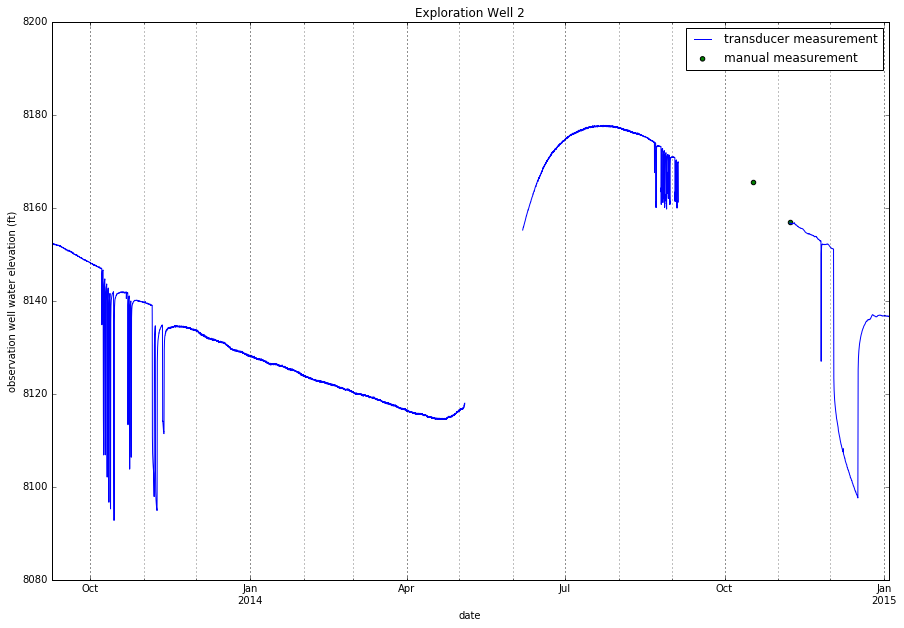

In [185]:
EXWM['EXWM_wl_elev'] = 8901-EXWM['EXWM_h_ft']

x1 = EXWM.index.to_datetime()
y1 = EXWM['EXWM_wl_elev']

x2 = EXWall.index.to_datetime()
y2 = EXWall['EXW_wl_elev_ft']

#x3 = SNOTEL.index.to_datetime()
#y3 = SNOTEL[u'SMS.I-1:-20 (pct)  (silt)']

#x3 = oldwl.index.to_datetime()
#y3 = oldwl['EXW_wl_elev_ft']

plt.figure()

#plt.plot(x2,y2, color = 'blue')
#plt.plot(x3,y3, color = 'blue')
EXWall['EXW_wl_elev_ft'].resample('H').plot(label='transducer measurement')
plt.scatter(x1,y1, c='green',label='manual measurement')
plt.ylabel('observation well water elevation (ft)')
plt.title('Exploration Well 2')
#plt.xticks(rotation=70)
#plt.twinx()
#plt.plot(x3,y3)
#plt.xlim('1/1/2014','1/1/2016')
plt.grid(which='both',axis='x')

legend = plt.legend(frameon = 1,scatterpoints=1)
frame = legend.get_frame()
frame.set_facecolor('white')
#frame.set_alpha(0)


#plt.savefig("C:\\Users\\PAULINKENBRANDT\\Google Drive\\WORK\\Powder Mountain\\Exp_Well_2_Long_Term_Hydrograph.pdf")
plt.savefig(rootlocal + 'Exp_Well_2_Long_Term_Hydrograph.pdf')

5560
5560
                            OLS Regression Results                            
Dep. Variable:         EXW_wl_elev_ft   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.763e+06
Date:                Tue, 09 Feb 2016   Prob (F-statistic):               0.00
Time:                        09:22:56   Log-Likelihood:                 5971.0
No. Observations:                5560   AIC:                        -1.194e+04
Df Residuals:                    5558   BIC:                        -1.192e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       5.093e+05    377.455   1349.26

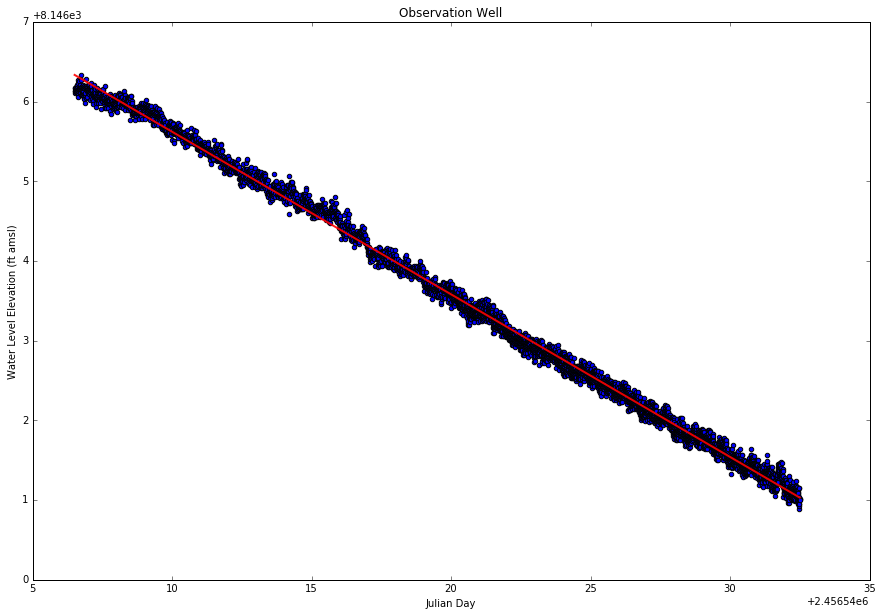

In [186]:
EXWsamp = EXWall[(EXWall.index.to_datetime() > pd.datetime(2013,9,11))&(EXWall.index.to_datetime() < pd.datetime(2013,10,7))]
x0 = EXWsamp.index.to_julian_date()
y = EXWsamp['EXW_wl_elev_ft']
x = sm.add_constant(x0)
print len(x0)
print len(y)

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Observation Well')
plt.ylabel('Water Level Elevation (ft amsl)')
plt.xlabel('Julian Day')

3623
3623
                            OLS Regression Results                            
Dep. Variable:         EXW_wl_elev_ft   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 8.928e+05
Date:                Tue, 09 Feb 2016   Prob (F-statistic):               0.00
Time:                        09:22:57   Log-Likelihood:                -1595.7
No. Observations:                3623   AIC:                             3195.
Df Residuals:                    3621   BIC:                             3208.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       3.408e+05    352.132    967.95

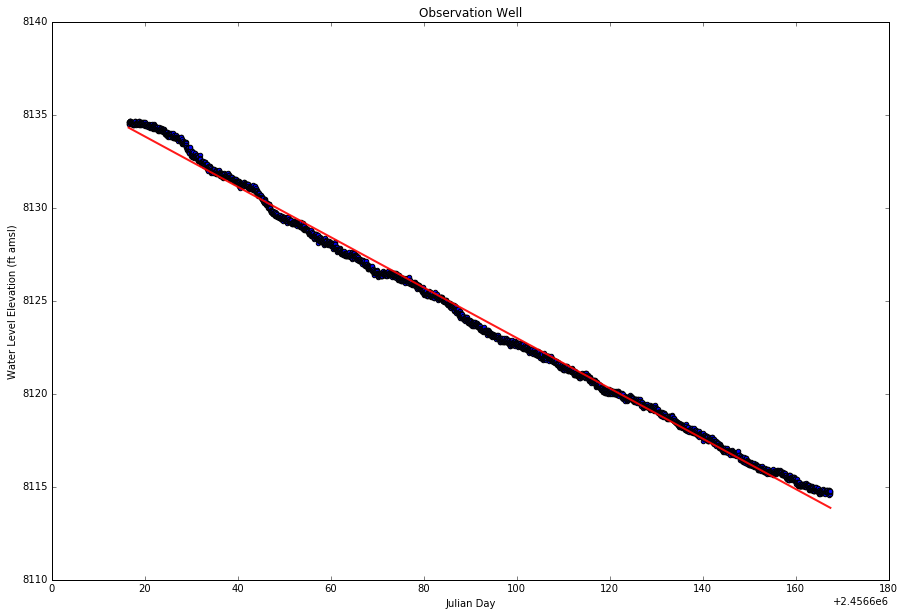

In [187]:
EXWsamp = EXWall[(EXWall.index.to_datetime() > pd.datetime(2013,11,20))&(EXWall.index.to_datetime() < pd.datetime(2014,4,20))]
x0 = EXWsamp.index.to_julian_date()
y = EXWsamp['EXW_wl_elev_ft']
x = sm.add_constant(x0)
print len(x0)
print len(y)

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Observation Well')
plt.ylabel('Water Level Elevation (ft amsl)')
plt.xlabel('Julian Day')

1596
1596
                            OLS Regression Results                            
Dep. Variable:         EXW_wl_elev_ft   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 4.087e+04
Date:                Tue, 09 Feb 2016   Prob (F-statistic):               0.00
Time:                        09:22:57   Log-Likelihood:                 1593.8
No. Observations:                1596   AIC:                            -3184.
Df Residuals:                    1594   BIC:                            -3173.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       3.236e+05   1560.228    207.41

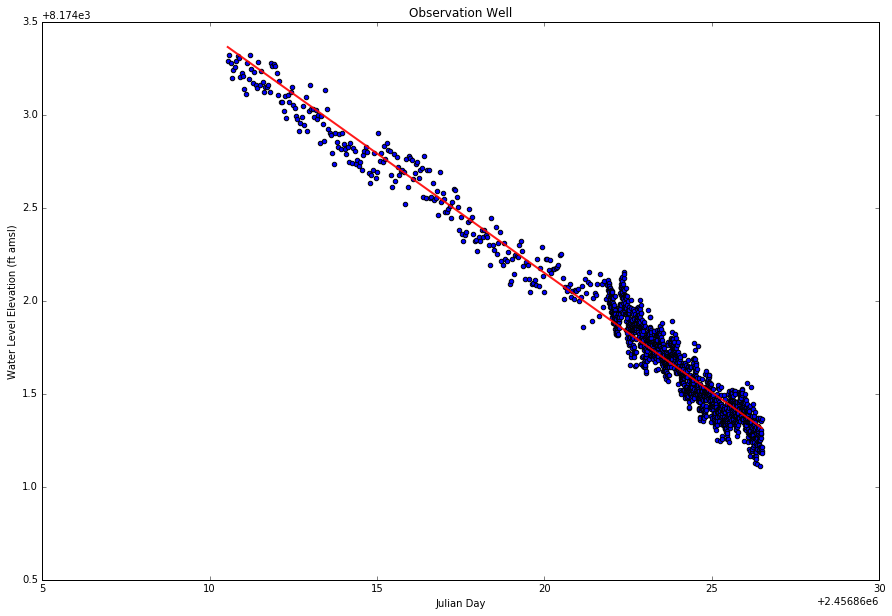

In [188]:
EXWsamp = EXWall[(EXWall.index.to_datetime() > pd.datetime(2014,8,1))&(EXWall.index.to_datetime() < pd.datetime(2014,8,17))]
x0 = EXWsamp.index.to_julian_date()
y = EXWsamp['EXW_wl_elev_ft']
x = sm.add_constant(x0)
print len(x0)
print len(y)

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Observation Well')
plt.ylabel('Water Level Elevation (ft amsl)')
plt.xlabel('Julian Day')

In [189]:
EXWall = EXWall.resample('1Min', how='mean')
EXWall = EXWall.interpolate(method='time', limit=90)
EXWall = EXWall.resample('5Min', how='mean')

In [190]:
EXW15 = EXWall.resample('15Min', how='mean')
All=pd.merge(All, EXW15, left_index=True, right_index=True, how='outer')

In [191]:
#list(All.columns.values)

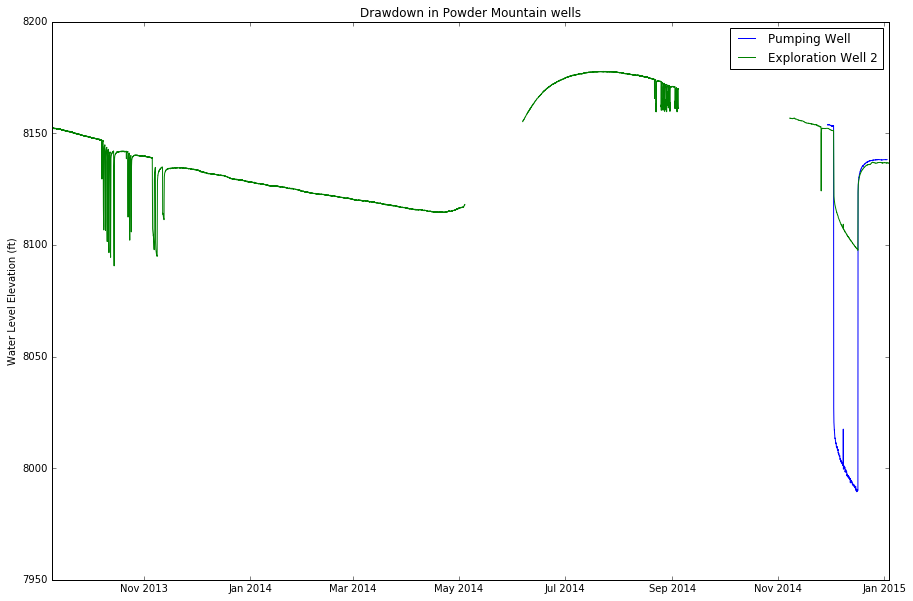

In [192]:
x1 = All.index.to_datetime()
y1 = All['HLW_wl_elev_ft']

x2 = All.index.to_datetime()
y2 = All['EXW_wl_elev_ft']
plt.figure()
plt.plot(x1,y1, label='Pumping Well')
plt.plot(x2,y2, label='Exploration Well 2')
plt.title('Drawdown in Powder Mountain wells')
plt.ylabel('Water Level Elevation (ft)')
plt.legend(loc=0)

1151
1151
                            OLS Regression Results                            
Dep. Variable:         EXW_wl_elev_ft   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 4.065e+04
Date:                Tue, 09 Feb 2016   Prob (F-statistic):               0.00
Time:                        09:23:35   Log-Likelihood:                 622.10
No. Observations:                1151   AIC:                            -1240.
Df Residuals:                    1149   BIC:                            -1230.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       6.033e+05   2951.605    204.38

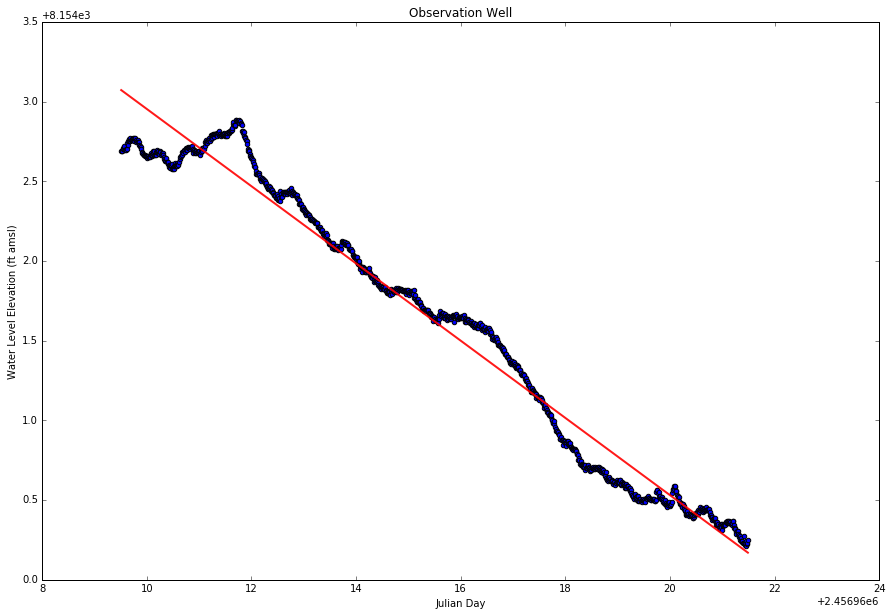

In [193]:
bAll = All[(All.index.to_datetime() < pd.datetime(2014,11,20))&(All.index.to_datetime() > pd.datetime(2014,11,8))]
x0 = bAll.index.to_julian_date()
y = bAll['EXW_wl_elev_ft']
x = sm.add_constant(x0)
print len(x0)
print len(y)

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Observation Well')
plt.ylabel('Water Level Elevation (ft amsl)')
plt.xlabel('Julian Day')

In [194]:
All.to_csv(OUT)

In [195]:
All.columns

Index([u'USU_Avon_BP_mmHg', u'USU_SF_BP_mmHg', u'USU_SF_PPT_in',
       u'USU_PPT_CDM', u'USU_SF_AD_h_ft', u'USU_SF_BD_h_ft', u'Site Id',
       u'WTEQ.I-1 (in) ', u'PREC.I-1 (in) ', u'TOBS.I-1 (degC) ',
       u'SNWD.I-1 (in) ', u'SMS.I-1:-2 (pct)  (silt)',
       u'SMS.I-1:-8 (pct)  (silt)', u'SMS.I-1:-20 (pct)  (silt)',
       u'STO.I-1:-2 (degC) ', u'STO.I-1:-8 (degC) ', u'STO.I-1:-20 (degC) ',
       u'SAL.I-1:-2 (gram) ', u'SAL.I-1:-8 (gram) ', u'SAL.I-1:-20 (gram) ',
       u'RDC.I-1:-2 (unit) ', u'RDC.I-1:-8 (unit) ', u'RDC.I-1:-20 (unit) ',
       u'BATT.I-1 (volt) ', u'Unnamed: 20', u'SForkWolfCreek',
       u'OtherQuartzite', u'NorthForkofWolfCreek', u'LeftysCreek',
       u'JamesPeakFork', u'HiddenLakeFork', u'CobabeCreek', u'NorthSide',
       u'SouthSide', u'UL_BP_LW_p_cm', u'UL_BP_LW_p_ft', u'UL_BP_LW_t_C',
       u'UL_JF_Q_cfs', u'UL_JF_Q_gpm', u'UL_JF_t_C', u'UL_LW_Q_cfs',
       u'UL_LW_Q_gpm', u'UL_LW_t_C', u'LL_LW_t_C', u'LL_JF_t_C',
       u'LL_LW_Q_gpm', u'LL_JF_Q

In [232]:
stations = [u'UL_JF_Q_gpm', u'UL_LW_Q_gpm', u'LL_LW_Q_gpm', u'LL_JF_Q_gpm', u'HL_LW_Q_gpm', u'HL_JF_Q_gpm', 
            u'NB_US_Q_gpm', u'NB_LW_Q_gpm', u'HLW_wl_elev_ft', u'EXW_wl_elev_ft']

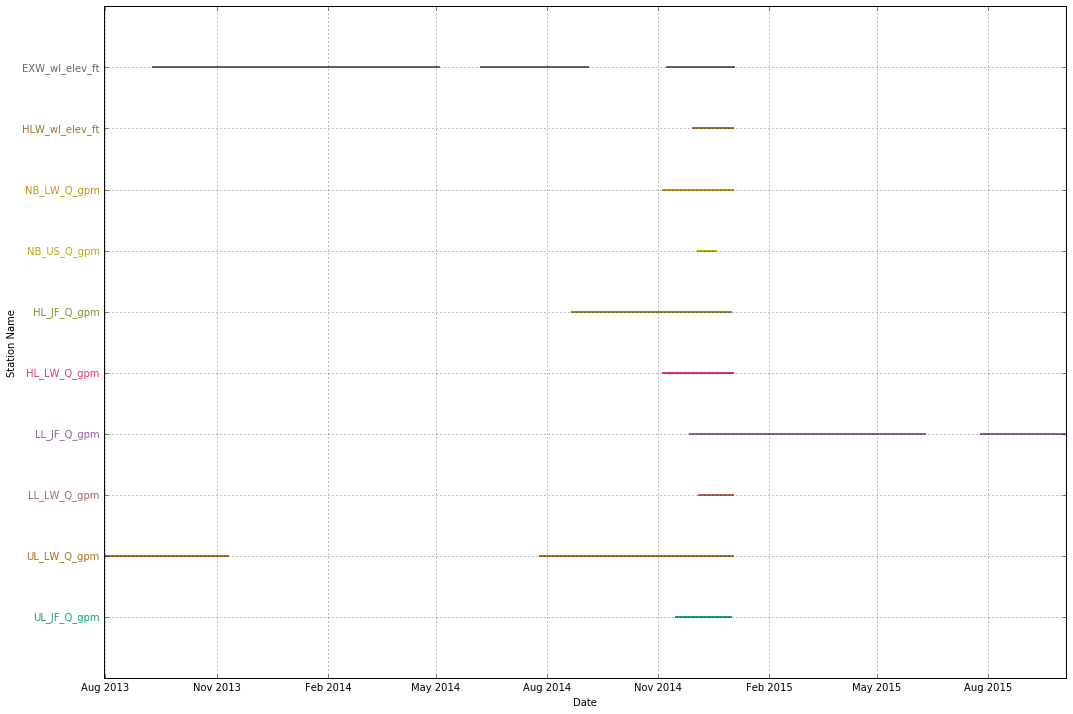

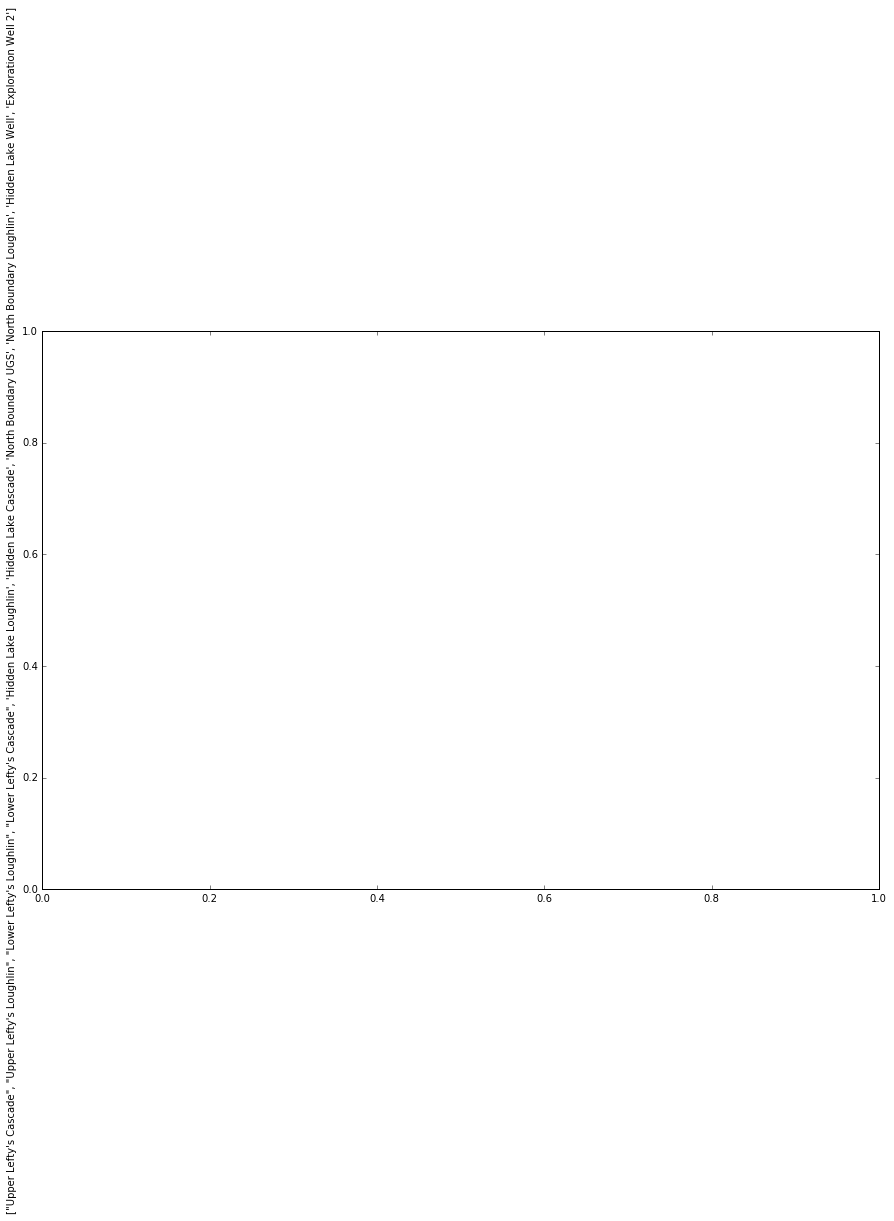

In [234]:
wa.gantt(All, stations)

### Aquifer Test Hydrographs

Import barometric pressure data. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=exbp></a>

In [199]:
UL_BP = pd.read_csv(Upper_Leftys_Barometer_Loughlin, usecols=[0,1],
                    index_col=0, skiprows=52, skipfooter=1, parse_dates=True, names=['dt','UL_BP_p_cm'], 
                    engine='python')
UL_BP['UL_BP_ft'] = UL_BP['UL_BP_p_cm']/2.54/12
UL_BP = UL_BP.drop(['UL_BP_p_cm'],axis=1)
UL_BP = UL_BP.resample('1Min', how='mean')
UL_BP = UL_BP.interpolate(method='time', limit=90)
UL_BP = UL_BP.resample('5Min', how='mean')

Create a dataframe for aquifer test analysis and hydrograph veiwing.

In [200]:
try:
    del Wells
except (NameError):
    pass
Wells = pd.merge(HLW,EXW, left_index=True, right_index=True, how='outer')
Wells = Wells.drop(['EXW_p_psi','EXW_p_ft','HLW_h_ft'],axis=1)
Wells = pd.merge(Wells,UL_BP, left_index=True, right_index=True, how='left')
list(Wells.columns.values)

['HLW_Q_gpm', 'HLW_wl_elev_ft', 'EXW_t_C', 'EXW_wl_elev_ft', 'UL_BP_ft']

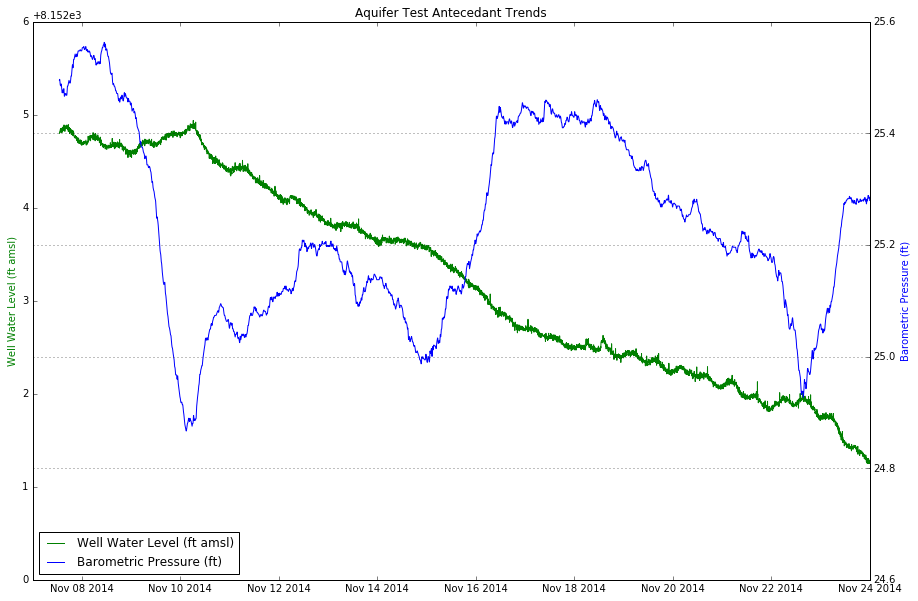

In [201]:
x = Wells.index.to_datetime()
y2 = Wells['UL_BP_ft']
y1 = Wells['EXW_wl_elev_ft']

plt.figure()

fig, ax1 = plt.subplots()
plt.title('Aquifer Test Antecedant Trends')
ax2 = ax1.twinx()
ax1.plot(x,y1,c='g',label='Well Water Level (ft amsl)')
ax1.set_xlim(left='11/7/2014',right='11/24/2014')
ax1.yaxis.get_major_formatter().set_powerlimits((-10, 10))
ax1.set_ylim(8152,8158)
#ax2.set_ylim(0,18)
ax1.set_ylabel('Well Water Level (ft amsl)', color='g') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x,y2,c='b',label='Barometric Pressure (ft)')
plt.grid()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

In [202]:
# Slope from OLS of antecedent trends
correction_factor = 0.30

Wells = Wells[Wells.index.to_datetime() >= pd.datetime(2014,12,2,18,55)]

Wells['pumping_day'] = Wells.index.to_julian_date() - Wells.index.to_julian_date()[0]
Wells['pumping_min'] = (Wells['pumping_day']*24*60).round(2)
Wells['HLW_corr_elev_ft'] = Wells['HLW_wl_elev_ft'] + Wells['pumping_day']*correction_factor
Wells['EXW_corr_elev_ft'] = Wells['EXW_wl_elev_ft'] + Wells['pumping_day']*correction_factor
Wells['HLW_S_ft'] = (Wells['HLW_corr_elev_ft'][0] - Wells['HLW_corr_elev_ft']).round(2)
Wells['EXW_S_ft'] = (Wells['EXW_corr_elev_ft'][0] - Wells['EXW_corr_elev_ft']).round(2)
Wells['HLW_Q_gpm'] = Wells['HLW_Q_gpm'].round(0)
Wells['HLW_Q_gpm'] = Wells['HLW_Q_gpm'].fillna(0)

Wells = Wells.drop(['HLW_wl_elev_ft', 'EXW_wl_elev_ft', 'pumping_day', 'UL_BP_ft', 'HLW_corr_elev_ft', 'EXW_corr_elev_ft'], axis=1)
list(Wells.columns.values)

['HLW_Q_gpm', 'EXW_t_C', 'pumping_min', 'HLW_S_ft', 'EXW_S_ft']

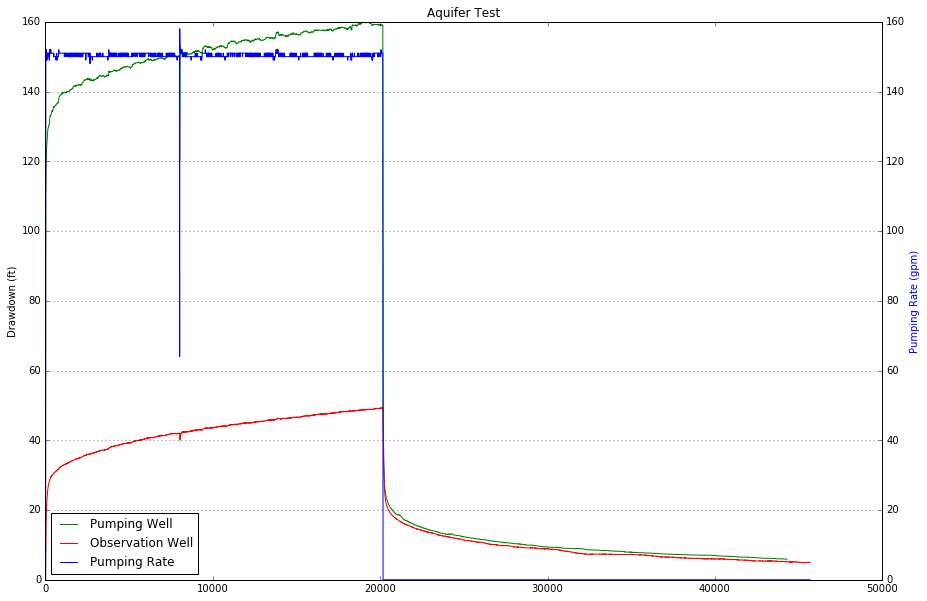

In [203]:
x = Wells['pumping_min'] 
y1 = Wells['HLW_S_ft']
y2 = Wells['EXW_S_ft']
y3 = Wells['HLW_Q_gpm']

plt.figure()

fig, ax1 = plt.subplots()
plt.title('Aquifer Test')
ax2 = ax1.twinx()
ax1.plot(x,y1,c='g',label='Pumping Well')
ax1.plot(x,y2,c='r',label='Observation Well')
#ax1.yaxis.get_major_formatter().set_powerlimits((-10, 10))
#ax2.set_ylim(0,18)
ax1.set_ylabel('Drawdown (ft)') 
ax2.set_ylabel('Pumping Rate (gpm)', color='b') 
ax2.plot(x,y3,c='b',label='Pumping Rate')
plt.grid()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

In [204]:
Wells1 = Wells[Wells.index.to_datetime() < pd.datetime(2014,12,4,12)]
Wells2 = Wells[(Wells.index.to_datetime() > pd.datetime(2014,12,4,12)) & (Wells.index.to_datetime() < pd.datetime(2014,12,15,12))]
Wells3 = Wells[(Wells.index.to_datetime() > pd.datetime(2014,12,15,12)) & (Wells.index.to_datetime() < pd.datetime(2014,12,18,12))]
Wells4 = Wells[(Wells.index.to_datetime() > pd.datetime(2014,12,18,12))].resample('30Min', how='mean')

WellsShort = Wells1
WellsShort = pd.concat([WellsShort, Wells2.resample('30Min', how='mean')])
WellsShort = pd.concat([WellsShort, Wells3])
WellsShort = pd.concat([WellsShort, Wells4])

In [205]:
Wells = Wells.set_index(keys=['pumping_min'])
WellsShort = WellsShort.set_index(keys=['pumping_min']) 
#['HLW_Q_gpm', 'EXW_t_C', 'UL_BP_ft', 'pumping_min', 'HLW_S_ft', 'EXW_S_ft']

In [206]:
writer = pd.ExcelWriter(rootlocal + 'AquiferTest.xlsx', engine='xlsxwriter')
Wells.to_excel(writer,'Complete_Data')
WellsShort.to_excel(writer,'Shortened_Data')
writer.save()

## Analysis

### North Boundary Weir Analysis

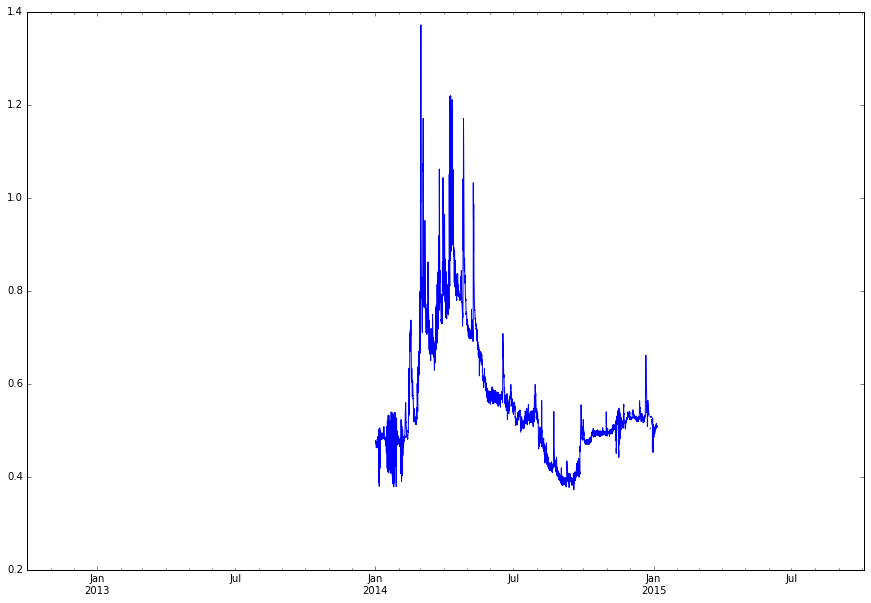

In [207]:
All['USU_SF_AD_h_ft'].plot()

In [208]:
try:
    del df
except (NameError):
    pass
df = All[(All.index.to_datetime() < pd.datetime(2014,12,29,20,0))&(All.index.to_datetime() > pd.datetime(2014,11,12,13,30))]

In [209]:
df['USU_Avon_BP_ft'] = 0.04460334762*df.loc[:,'USU_Avon_BP_mmHg']
df['HLW_Q_cfs'] = 0.00222800926*df.loc[:,'HLW_Q_gpm']
df['USU_SF_PPT_ft'] = df.loc[:,'USU_SF_PPT_in']/12

df['USU_Avon_std_BP_ft'] = (df.loc[:,'USU_Avon_BP_ft'] - df.loc[:,'USU_Avon_BP_ft'].mean()) / df.loc[:,'USU_Avon_BP_ft'].std()
df['HLW_std_Q_cfs'] = (df.loc[:,'HLW_Q_cfs'] - df.loc[:,'HLW_Q_cfs'].mean()) / df.loc[:,'HLW_Q_cfs'].std()
df['EXW_std_wl_elev_ft'] = (df.loc[:,'EXW_wl_elev_ft'] - df.loc[:,'EXW_wl_elev_ft'].mean()) / df.loc[:,'EXW_wl_elev_ft'].std()
df['USU_SF_AD_std_h_ft'] = (df.loc[:,'USU_SF_AD_h_ft'] - df.loc[:,'USU_SF_AD_h_ft'].mean()) / df.loc[:,'USU_SF_AD_h_ft'].std()
df['NB_LW_std_Q_cfs'] = (df.loc[:,'NB_LW_Q_cfs'] - df.loc[:,'NB_LW_Q_cfs'].mean()) / df.loc[:,'NB_LW_Q_cfs'].std()
df['HL_BP_LW_std_t_C'] = (df.loc[:,'HL_BP_LW_t_C'] - df.loc[:,'HL_BP_LW_t_C'].mean()) / df.loc[:,'HL_BP_LW_t_C'].std()


c:\python27\arcgis10.3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
c:\python27\arcgis10.3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\python27\arcgis10.3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [210]:
df1 = df[(df.index.to_datetime() < pd.datetime(2014,12,29,20,0))&(df.index.to_datetime() > pd.datetime(2014,12,1,0))]
x0 = df1.index.to_julian_date()
x = [(x0[i]-x0[0])*24*60 for i in range(len(x0))]
y1 = df1['USU_Avon_std_BP_ft'] 
y2 = df1['HLW_std_Q_cfs']
y3 = df1['EXW_std_wl_elev_ft']
y4 = df1['USU_SF_AD_std_h_ft'] 
y5 = df1['NB_LW_std_Q_cfs']
y6 = (df1['HL_JF_Q_cfs']-df1['HL_JF_Q_cfs'].mean())/df1['HL_JF_Q_cfs'].std()
y7 = (df1['LL_JF_Q_cfs']-df1['LL_JF_Q_cfs'].mean())/df1['LL_JF_Q_cfs'].std()
y8 = df1['USU_SF_PPT_ft']

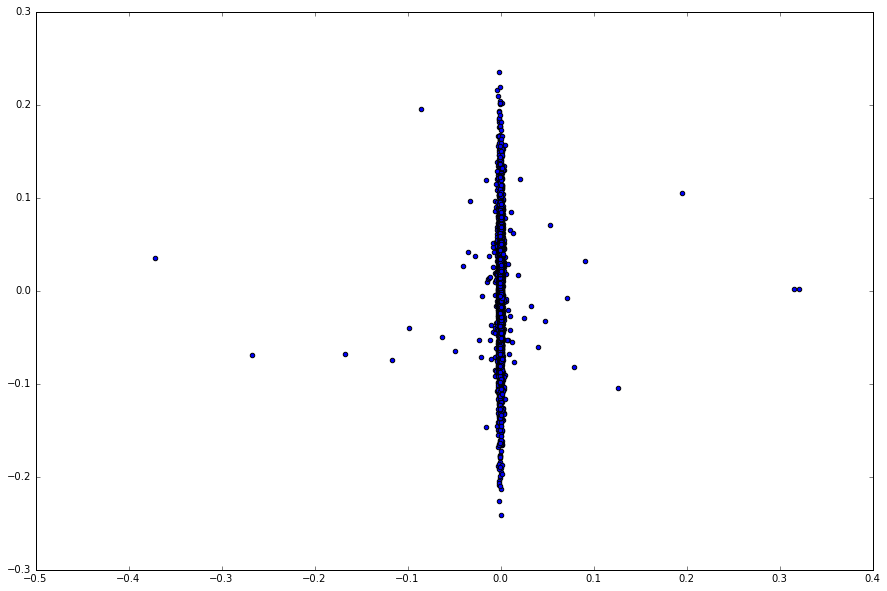

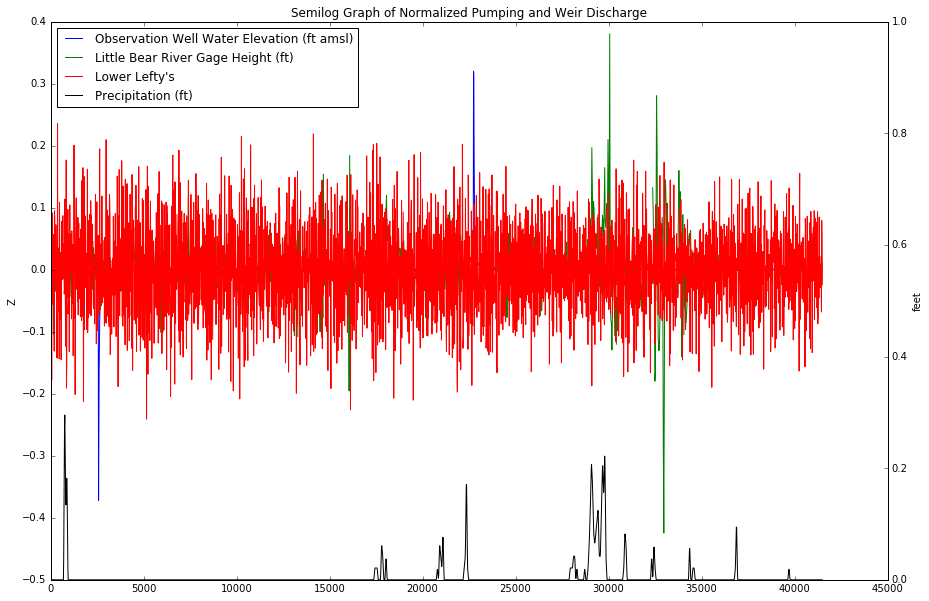

In [211]:
y3a = y3.diff()
y4a = y4.diff()
y7a = y7.diff()
plt.figure()
plt.scatter(y3a,y7a)

plt.figure()
# Three subplots sharing both x/y axes
f, ax1 = plt.subplots(1, sharex=True, sharey=True)
ax1.plot(x, y3a, label='Observation Well Water Elevation (ft amsl)')
ax1.plot(x,y4a,label='Little Bear River Gage Height (ft)')
ax1.plot(x,y7a, label='Lower Lefty\'s')
#ax1.set_xscale('log')

ax1.set_ylabel('Z')
ax1.set_title('Semilog Graph of Normalized Pumping and Weir Discharge')
ax1a = ax1.twinx()
ax1a.plot(x,y8, color='black', label='Precipitation (ft)')
ax1a.set_ylabel('feet')
ax1a.set_ylim(bottom=0,top=1)
h1, l1 = ax1.get_legend_handles_labels()
h1a, l1a = ax1a.get_legend_handles_labels()
ax1.legend(h1+h1a, l1+l1a, loc=2)

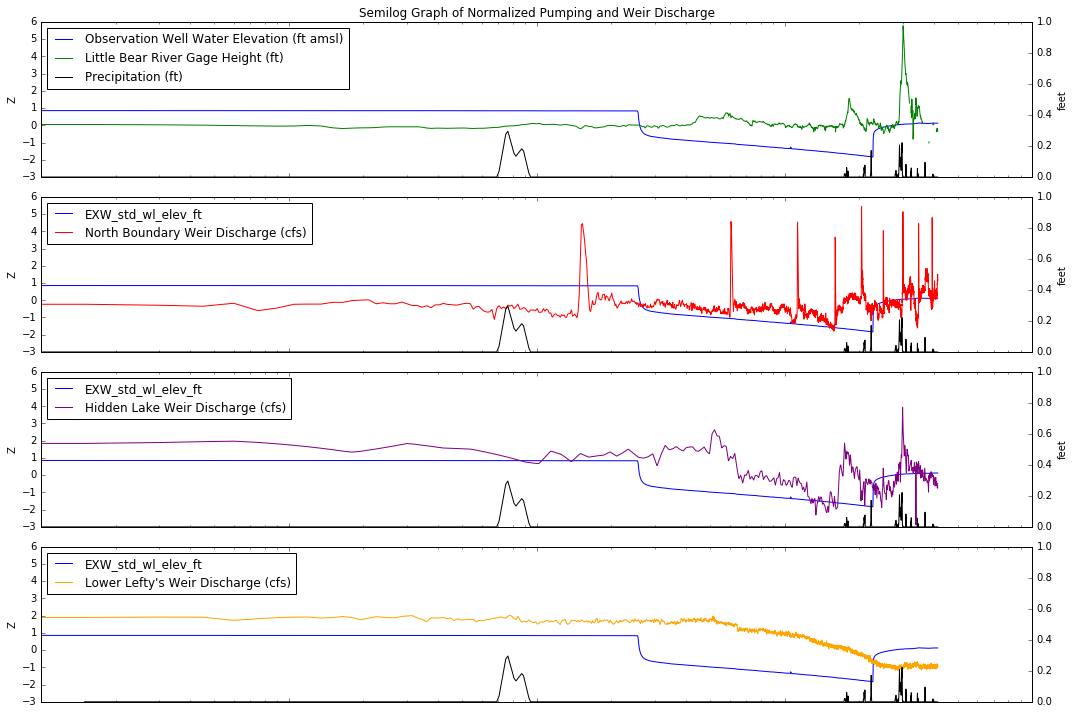

In [212]:
df1 = df[(df.index.to_datetime() < pd.datetime(2014,12,29,20,0))&(df.index.to_datetime() > pd.datetime(2014,12,1,0))]
x0 = df1.index.to_julian_date()
x = [(x0[i]-x0[0])*24*60 for i in range(len(x0))]
y1 = df1['USU_Avon_std_BP_ft'] 
y2 = df1['HLW_std_Q_cfs']
y3 = df1['EXW_std_wl_elev_ft']
y4 = df1['USU_SF_AD_std_h_ft'] 
y5 = df1['NB_LW_std_Q_cfs']
y6 = (df1['HL_JF_Q_cfs']-df1['HL_JF_Q_cfs'].mean())/df1['HL_JF_Q_cfs'].std()
y7 = (df1['LL_JF_Q_cfs']-df1['LL_JF_Q_cfs'].mean())/df1['LL_JF_Q_cfs'].std()
y8 = df1['USU_SF_PPT_ft']

plt.figure()
# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True)
ax1.plot(x, y3, label='Observation Well Water Elevation (ft amsl)')
ax1.plot(x,y4,label='Little Bear River Gage Height (ft)')
ax1.set_xscale('log')
ax1.set_ylabel('Z')
ax1.set_title('Semilog Graph of Normalized Pumping and Weir Discharge')
ax1a = ax1.twinx()
ax1a.plot(x,y8, color='black', label='Precipitation (ft)')
ax1a.set_ylabel('feet')
ax1a.set_ylim(bottom=0,top=1)
h1, l1 = ax1.get_legend_handles_labels()
h1a, l1a = ax1a.get_legend_handles_labels()
ax1.legend(h1+h1a, l1+l1a, loc=2)

ax2.plot(x,y3)
ax2.plot(x,y5,label='North Boundary Weir Discharge (cfs)',color='red')
ax2.set_xscale('log')
ax2.set_ylabel('Z')
ax2.legend(loc=2)
ax2a = ax2.twinx()
ax2a.plot(x,y8, color='black')
ax2a.set_ylabel('feet')
ax2a.set_ylim(bottom=0,top=1)
ax2.legend(loc=2)

ax3.plot(x,y3)
ax3.plot(x,y6,label='Hidden Lake Weir Discharge (cfs)',color='purple')
ax3.set_xscale('log')
ax3.set_ylabel('Z')
ax3.legend(loc=2)
ax3a = ax3.twinx()
ax3a.plot(x,y8, color='black')
ax3a.set_ylim(bottom=0,top=1)
ax3a.set_ylabel('feet')

ax4.plot(x,y3)
ax4.plot(x,y7, label='Lower Lefty\'s Weir Discharge (cfs)',color='orange')
ax4.set_xscale('log')
ax4.set_ylabel('Z')
ax4.legend(loc=2)
ax4a = ax4.twinx()
ax4a.plot(x,y8, color='black')
ax4a.set_ylim(bottom=0,top=1)
ax3a.set_ylabel('feet')

plt.xlabel('Time (min)')
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.tight_layout()
plt.savefig(rootlocal+'Semilog_All.pdf')

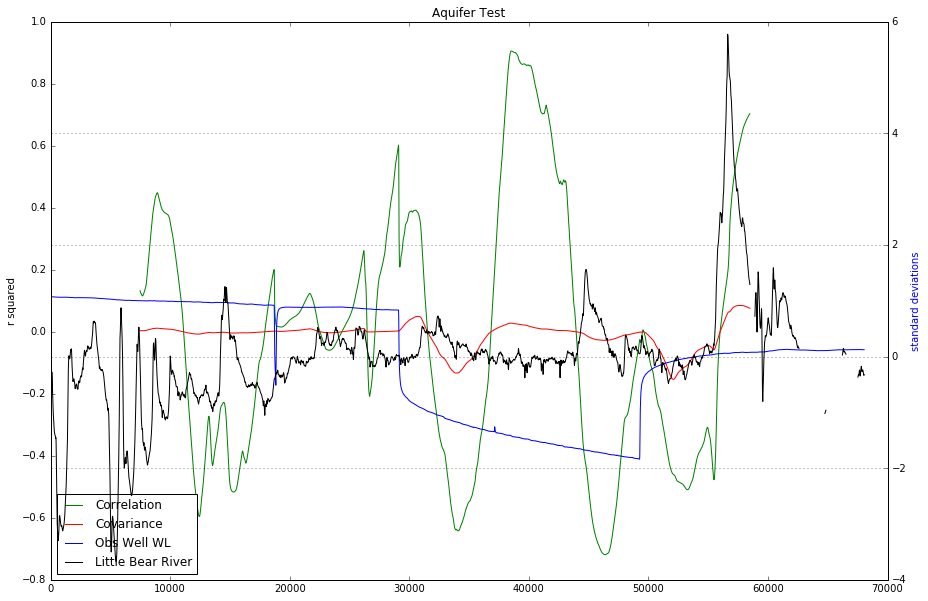

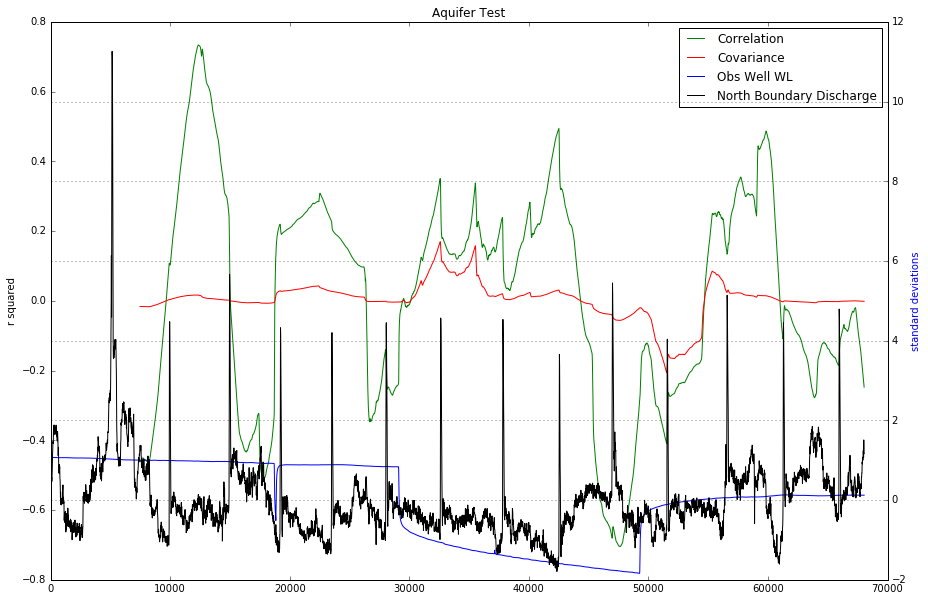

In [213]:
x0 = df.index.to_julian_date()
x = [(x0[i]-x0[0])*24*60 for i in range(len(x0))]
y3 = df['EXW_std_wl_elev_ft']#.diff()
y4 = df['USU_SF_AD_std_h_ft']#.diff() 
y5 = df['NB_LW_std_Q_cfs']#.diff()

correls = pd.rolling_corr(y4,y3,  500)
covar = pd.rolling_cov(y4,y3,  500)


plt.figure()

fig, ax1 = plt.subplots()
plt.title('Aquifer Test')
ax2 = ax1.twinx()
ax1.plot(x,correls,c='g',label='Correlation')
ax1.plot(x,covar,c='r',label='Covariance')
#ax1.yaxis.get_major_formatter().set_powerlimits((-10, 10))
#ax2.set_ylim(0,18)
ax1.set_ylabel('r squared') 
ax2.set_ylabel('standard deviations', color='b') 
ax2.plot(x,y3,c='b',label='Obs Well WL')
ax2.plot(x,y4,c='black',label='Little Bear River')
plt.grid()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

correls = pd.rolling_corr(y5,y3,  500)
covar = pd.rolling_cov(y5,y3,  500)

plt.figure()

fig, ax1 = plt.subplots()
plt.title('Aquifer Test')
ax2 = ax1.twinx()
ax1.plot(x,correls,c='g',label='Correlation')
ax1.plot(x,covar,c='r',label='Covariance')
#ax1.yaxis.get_major_formatter().set_powerlimits((-10, 10))
#ax2.set_ylim(0,18)
ax1.set_ylabel('r squared') 
ax2.set_ylabel('standard deviations', color='b') 
ax2.plot(x,y3,c='b',label='Obs Well WL')
ax2.plot(x,y5,c='black',label='North Boundary Discharge')
plt.grid()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=1)

plt.show()

In [214]:
import statsmodels.formula.api as smf

In [215]:
df['HL_BP_LW_dt_C'] = df['HL_BP_LW_t_C'].diff()
df['NB_LW_dQ_cfs'] = df['NB_LW_Q_cfs'].diff()
df['PPT_CDM'] = (df['USU_SF_PPT_in'] - df['USU_SF_PPT_in'].mean()).cumsum()
df['jday'] = df.index.to_julian_date()

c:\python27\arcgis10.3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
c:\python27\arcgis10.3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\python27\arcgis10.3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [216]:
df1 = df[(df.index.to_datetime() < pd.datetime(2014,12,29,20,0))&(df.index.to_datetime() > pd.datetime(2014,12,2,18,45))]

From <a href=http://www.datarobot.com/blog/multiple-regression-using-statsmodels/>Data Robot</a> 

                            OLS Regression Results                            
Dep. Variable:                      Q   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     430.5
Date:                Tue, 09 Feb 2016   Prob (F-statistic):          2.69e-221
Time:                        09:25:27   Log-Likelihood:                -2143.4
No. Observations:                2270   AIC:                             4295.
Df Residuals:                    2266   BIC:                             4318.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0066      0.034     -0.194      0.8

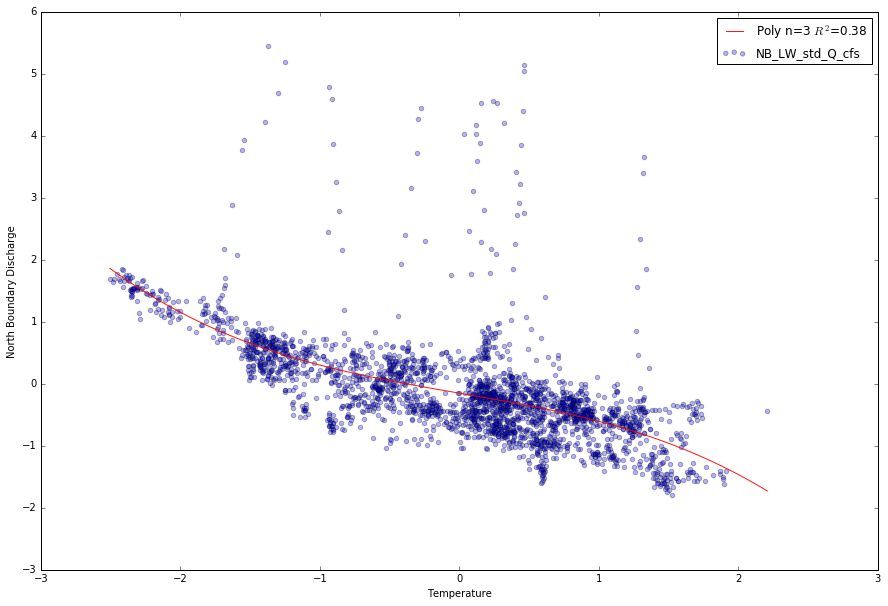

In [217]:
x0 = df1['jday']
time = [(x0[i]-x0[0])*24*60 for i in range(len(x0))]
#BP = df1['USU_Avon_BP_ft'] 
lil_bear = df1['USU_SF_AD_std_h_ft']
#PPT_CDM = df1['PPT_CDM']
temp = df1['HL_BP_LW_std_t_C'].get_values()
#SWE = df1['WTEQ.I-1 (in) ']
Q = df1['NB_LW_std_Q_cfs']

plt.figure()
plt.scatter(temp, Q, alpha=0.3)
plt.ylabel('North Boundary Discharge')
plt.xlabel('Temperature')

est = smf.ols(formula='Q ~ time + lil_bear + temp', data=df1).fit()

xp = pd.DataFrame({'temp': np.linspace(temp.min(), temp.max(), 100)})

poly3 = smf.ols(formula='Q ~ 1 + temp + I(temp ** 2.0) + I(temp ** 3.0)', data=df1).fit()
plt.plot(xp.temp,poly3.predict(xp), 'r-', alpha=0.9, label='Poly n=3 $R^2$=%.2f' % poly3.rsquared)
plt.legend()

print est.summary()

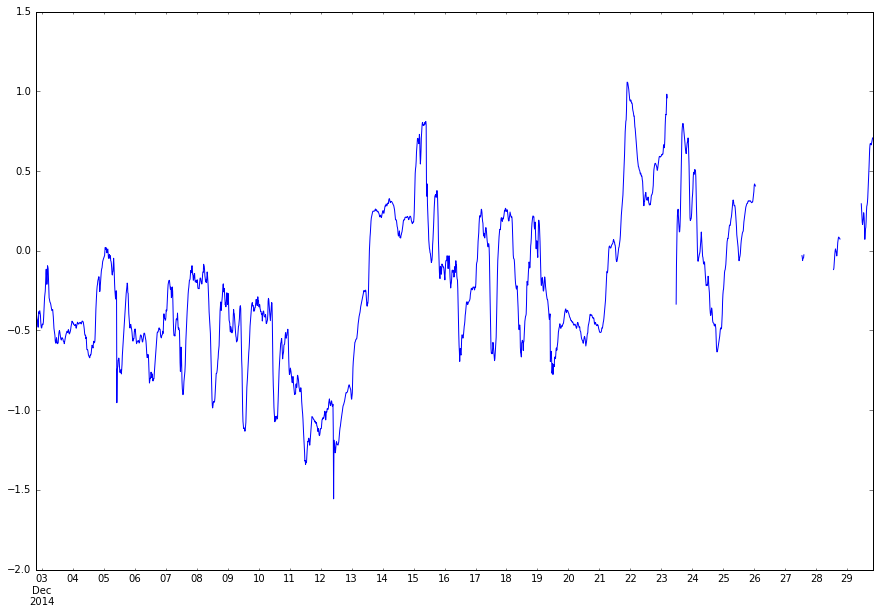

In [218]:
(df1['NB_LW_std_Q_cfs']-est.resid).plot()

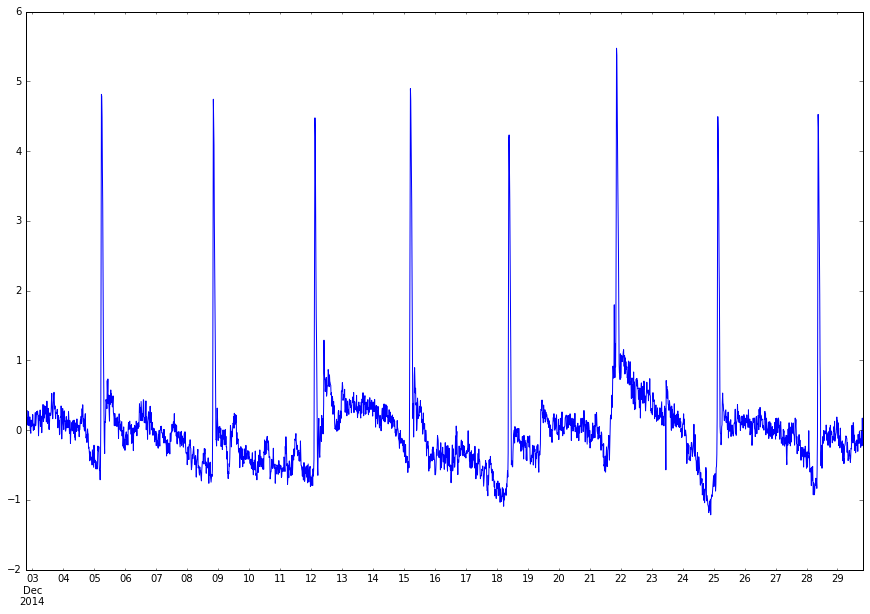

In [219]:
poly3.resid.plot()

### Hidden Lake Weir Analysis

In [220]:
try:
    del df
except (NameError):
    pass
df = All[(All.index.to_datetime() < pd.datetime(2014,12,25))&(All.index.to_datetime() > pd.datetime(2014,10,12))]
dflist = ['HL_JF_Q_cfs','USU_SF_BD_h_ft','USU_SF_AD_h_ft','HL_JF_t_C','EXW_wl_elev_ft','HLW_wl_elev_ft','USU_SF_PPT_in']
for i in list(df.columns.values):
    if i not in dflist:
        df = df.drop(i,axis=1)

In [221]:
df['PPT_CDM'] = (df['USU_SF_PPT_in'] - df['USU_SF_PPT_in'].mean()).cumsum()
df['jday'] = df.index.to_julian_date()

In [222]:
from pandas.tools.plotting import scatter_matrix

In [223]:
list(df.columns.values)

['USU_SF_PPT_in',
 'USU_SF_AD_h_ft',
 'USU_SF_BD_h_ft',
 'HL_JF_t_C',
 'HL_JF_Q_cfs',
 'HLW_wl_elev_ft',
 'EXW_wl_elev_ft',
 'PPT_CDM',
 'jday']

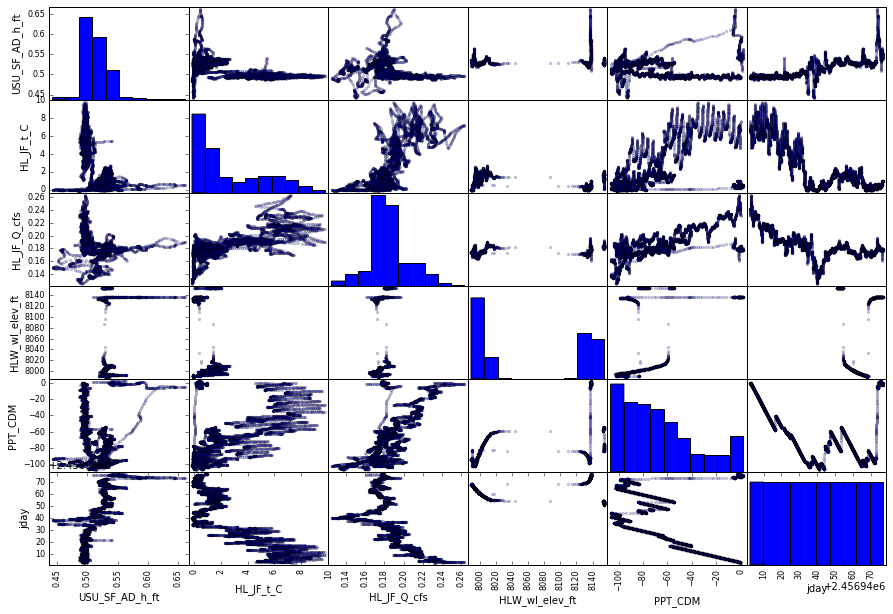

In [224]:
df1 = df.drop(['USU_SF_PPT_in','EXW_wl_elev_ft','USU_SF_BD_h_ft'],axis=1)

plt.figure()
scatter_matrix(df1, alpha=0.2, diagonal='hist')
plt.savefig(rootlocal+'Reg_Matrix.pdf')

In [225]:
df1['dUSU_SF_AD_h_ft'] = df1['USU_SF_AD_h_ft'].diff()
df1['dHL_JF_t_C'] = df1['HL_JF_t_C'].diff()
df1['dHL_JF_Q_cfs'] = df1['HL_JF_Q_cfs'].diff()
df1['dHLW_wl_elev_ft'] = df1['HLW_wl_elev_ft'].diff()
df1['dPPT_CDM'] = df1['PPT_CDM'].diff()

df1['nUSU_SF_AD_h_ft'] = (df1['USU_SF_AD_h_ft']-df1['USU_SF_AD_h_ft'].mean())/df1['USU_SF_AD_h_ft'].std()
df1['nHL_JF_t_C'] = (df1['HL_JF_t_C']-df1['HL_JF_t_C'].mean())/df1['HL_JF_t_C'].std()
df1['nHL_JF_Q_cfs'] = (df1['HL_JF_Q_cfs']-df1['HL_JF_Q_cfs'].mean())/df1['HL_JF_Q_cfs'].std()
df1['nHLW_wl_elev_ft'] = (df1['HLW_wl_elev_ft']-df1['HLW_wl_elev_ft'].mean())/df1['HLW_wl_elev_ft'].std()
df1['nPPT_CDM'] = (df1['PPT_CDM']-df1['PPT_CDM'].mean())/df1['PPT_CDM'].std()


In [226]:
df2 = df1.drop(['nUSU_SF_AD_h_ft','nHL_JF_t_C','nHL_JF_Q_cfs','nHLW_wl_elev_ft','nPPT_CDM',
                'USU_SF_AD_h_ft','USU_SF_AD_h_ft','HL_JF_Q_cfs','HLW_wl_elev_ft','PPT_CDM','HL_JF_t_C'],axis=1)
df3 = df1.drop(['dUSU_SF_AD_h_ft','dHL_JF_t_C','dHL_JF_Q_cfs','dHLW_wl_elev_ft','dPPT_CDM',
                'USU_SF_AD_h_ft','USU_SF_AD_h_ft','HL_JF_Q_cfs','HLW_wl_elev_ft','PPT_CDM','HL_JF_t_C'],axis=1)

In [227]:
flow = df['HL_JF_Q_cfs']
time = df['jday']
lil_bear = df['USU_SF_AD_h_ft']
temp = df['HL_JF_t_C']
precip = df['USU_SF_PPT_in']
pump_well = df['HLW_wl_elev_ft']
ppt_cdm = df['PPT_CDM']


est = smf.ols(formula='flow ~ time + lil_bear + temp + ppt_cdm', data=df).fit()
print est.summary()

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     4351.
Date:                Tue, 09 Feb 2016   Prob (F-statistic):               0.00
Time:                        09:26:04   Log-Likelihood:                 21119.
No. Observations:                6886   AIC:                        -4.223e+04
Df Residuals:                    6881   BIC:                        -4.219e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    592.5092     37.405     15.841      0.0

In [228]:
df['resid']=est.resid
df['modeled']=df['HL_JF_Q_cfs']-df['resid']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x215A3AD0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x4063B8B0>], dtype=object)

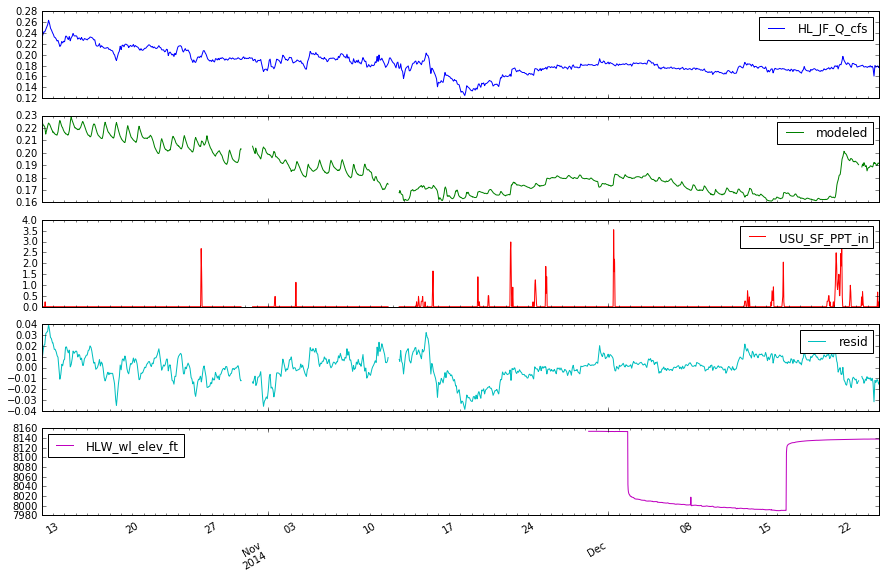

In [229]:
y0 = df['HL_JF_Q_cfs']
x0 = df['jday']
x1 = df['USU_SF_AD_h_ft']
x2 = df['HL_JF_t_C']
x3 = df['HLW_wl_elev_ft']
x4 = df['USU_SF_PPT_in']
x5 = df['PPT_CDM']
x6 = df['modeled']
x7 = df['resid']


df[['HL_JF_Q_cfs','modeled','USU_SF_PPT_in','resid','HLW_wl_elev_ft']].plot(subplots=True)

In [230]:
df.to_csv(rootlocal+'hidden_lake_out.csv')

IOError: [Errno 2] No such file or directory: 'E:\\POWMOW\\Figures\\HL_Model.pdf'

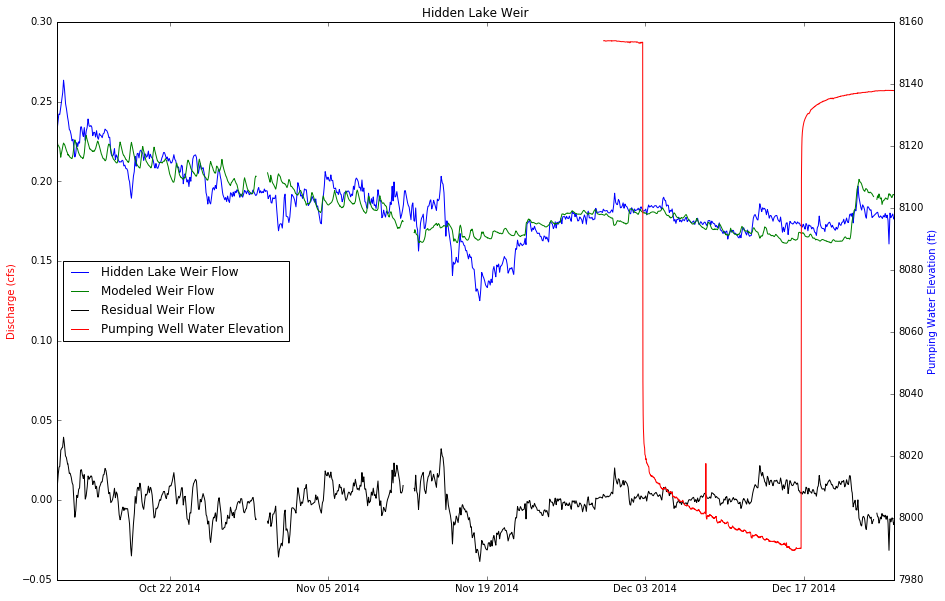

In [231]:
plt.figure()

x0 = df.index.to_datetime()
x1 = df['USU_SF_AD_h_ft']
x2 = df['HL_JF_t_C']
x3 = df['HLW_wl_elev_ft']
x4 = df['USU_SF_PPT_in']
x5 = df['PPT_CDM']
x6 = df['modeled']
x7 = df['resid']
y0 = df['HL_JF_Q_cfs']

fig, ax1 = plt.subplots()
plt.title('Hidden Lake Weir')
ax2 = ax1.twinx()
ax1.plot(x0,y0,c='b',label='Hidden Lake Weir Flow')
ax1.plot(x0,x6,c='g',label='Modeled Weir Flow')
ax1.plot(x0,x7,c='black',label='Residual Weir Flow')
#ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylabel('Discharge (cfs)', color='r') 
ax2.set_ylabel('Pumping Water Elevation (ft)', color='b') 
ax2.plot(x0,x3,c='r',label='Pumping Well Water Elevation')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=6)
plt.savefig('E:\\POWMOW\\Figures\\HL_Model.pdf')
plt.show()


In [ ]:
x0 = df.index.to_datetime().values
y0 = df['HL_JF_Q_cfs'].values
start_day = x0[0]
last_day = x0[-1]
date_diff = (df['jday'][-1]-df['jday'][0])
num_samps = len(x0)
interval = ((df['jday'][-1]-df['jday'][0])/len(x0))
print start_day
print last_day
print date_diff
print num_samps
print interval

In [ ]:
import rpy2
%load_ext rmagic

In [ ]:
%R -i y0 plot(y0)

In [ ]:
%%R -i y0 -o strt,lst
library(chron)

strt <-as.Date("10/11/2014 18:15:00", format='%m/%d/%Y %H:%M:%S');
lst <-as.Date("12/24/2014 16:45:00", format='%m/%d/%Y %H:%M:%S');
yser <- ts(y0, start=strt, end=lst, frequency=48)

Qtimeseriescomponents <- decompose(yser)
plot(Qtimeseriescomponents)


### Lower Lefty's Spring Analysis

[To Top](#top)

In [ ]:
try:
    del df
except (NameError):
    pass
df = All[(All.index.to_datetime() < pd.datetime(2015,1,1))&(All.index.to_datetime() > pd.datetime(2014,11,27))]


In [ ]:
dflist = ['UL_JF_t_C','WTEQ.I-1 (in) ','USU_SF_AD_h_ft','HLW_wl_elev_ft','USU_Avon_BP_mmHg',
          'HLW_wl_elev_ft','USU_SF_PPT_in','UL_JF_Q_cfs','EXW_wl_elev_ft','LL_JF_Q_cfs', 'UL_BP_LW_t_C','LL_JF_t_C','UL_BP_LW_p_ft',]
for i in list(df.columns.values):
    if i not in dflist:
        df = df.drop(i,axis=1)

In [ ]:
df['UL_JF_t_C'] = df['UL_JF_t_C'].diff()
df['UL_JF_Q_cfs'] = df['UL_JF_Q_cfs'].diff()
df['PPT_CDM'] = (df['USU_SF_PPT_in'] - df['USU_SF_PPT_in'].mean()).cumsum()
df['jday'] = df.index.to_julian_date()    


In [ ]:
flow = df['LL_JF_Q_cfs']
time = df['jday']
lil_bear = df['USU_SF_AD_h_ft']
temp = df['LL_JF_t_C']
pump_well = df['HLW_wl_elev_ft']
ppt_cdm = df['PPT_CDM']
swe = df['WTEQ.I-1 (in) ']
obs_well = df['EXW_wl_elev_ft']

est = smf.ols(formula='flow ~ 1+ pump_well + lil_bear + I(pump_well**2.0) + I(lil_bear**2.0)', data=df).fit()
print est.summary()



xp = pd.DataFrame({'pump_well': np.linspace(pump_well.min(), pump_well.max(), 100), 
                  'lil_bear': np.linspace(lil_bear.min(), lil_bear.max(), 100),
                  'time':np.linspace(time.min(), time.max(), 100)})

#poly3 = smf.ols(formula='Q ~ 1 + temp + I(temp ** 2.0) + I(temp ** 3.0)', data=df1).fit()
plt.plot(xp.time,est.predict(xp), 'r-', alpha=0.9, label='Poly n=3 $R^2$=%.2f' % est.rsquared)
plt.scatter(time,flow)
plt.legend()

In [ ]:
df['resid']=est.resid
df['modeled']=df['LL_JF_Q_cfs']-df['resid']
df['resid'].plot()

In [ ]:
flow = df['LL_JF_Q_cfs']
time = df['jday']
lil_bear = df['USU_SF_AD_h_ft']
temp = df['UL_JF_t_C']
pump_well = df['HLW_wl_elev_ft']
ppt_cdm = df['PPT_CDM']
swe = df['WTEQ.I-1 (in) ']

df1 = df
dflist = ['LL_JF_Q_cfs','jday','USU_SF_AD_h_ft','HLW_wl_elev_ft','PPT_CDM','WTEQ.I-1 (in) ','HLW_wl_elev_ft']
for i in list(df.columns.values):
    if i not in dflist:
        df1 = df1.drop(i,axis=1)

scatter_matrix(df1, alpha=0.2, diagonal='hist')

In [ ]:
y0 = df['LL_JF_Q_cfs']
x0 = df['jday']
x1 = df['USU_SF_AD_h_ft']
x2 = df['UL_JF_t_C']
x3 = df['HLW_wl_elev_ft']
x4 = df['USU_SF_PPT_in']
x5 = df['PPT_CDM']
x6 = df['modeled']
x7 = df['resid']


df[['LL_JF_Q_cfs','USU_SF_AD_h_ft','USU_SF_PPT_in','PPT_CDM','HLW_wl_elev_ft']].plot(subplots=True)

In [ ]:
plt.figure()

x0 = df.index.to_datetime()
x1 = df['USU_SF_AD_h_ft']
x2 = df['LL_JF_t_C']
x3 = df['HLW_wl_elev_ft']
x4 = df['USU_SF_PPT_in']
x5 = df['PPT_CDM']
x6 = df['modeled']
x7 = df['resid']
y0 = df['LL_JF_Q_cfs']

fig, ax1 = plt.subplots()
plt.title('Lefty\'s Weir')
ax2 = ax1.twinx()
ax1.plot(x0,y0,c='b',label='Lefty\'s Weir Flow')
ax1.plot(x0,x6,c='g',label='Modeled Weir Flow')
ax1.plot(x0,x7,c='black',label='Residual Weir Flow')
#ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylabel('Discharge (cfs)', color='r') 
ax2.set_ylabel('Pumping Water Elevation (ft)', color='b') 
ax2.plot(x0,x3,c='r',label='Pumping Well Water Elevation')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=7)

plt.show()

In [ ]:

x0 = df['jday']
x = [(x0[i]-x0[0])*24*60 for i in range(len(x0))]

df['LL_JF_std_Q_cfs'] = (df['LL_JF_Q_cfs']-df['LL_JF_Q_cfs'].mean())/df['LL_JF_Q_cfs'].std()
df['EXW_std_wl_elev_ft'] = (df['EXW_wl_elev_ft']-df['EXW_wl_elev_ft'].mean())/df['EXW_wl_elev_ft'].std()

y5 = df['LL_JF_std_Q_cfs']
y3 = df['EXW_std_wl_elev_ft']

plt.figure()
#plt.plot(x,y1,label='USU_Avon_std_BP_ft')
#plt.plot(x,y2,label='HLW_std_Q_cfs')
plt.plot(x,y3,label='Observation Well Elevation (ft amsl)')
plt.plot(x,y5,label='Lower Lefty\'s Weir Discharge (cfs)')
plt.title('Comparison of Standardized Variables in relation to Lower Lefty\'s Weir')
plt.xlabel('Standard Deviations')
plt.ylabel('minutes of pumping')
plt.grid()
plt.ylim(-4,6)
plt.legend(loc=2)
plt.xscale('log')
plt.savefig('E:\\POWMOW\\Figures\\Semilog_Leftys_and_Obs_Well.pdf')


print df[['EXW_std_wl_elev_ft','LL_JF_std_Q_cfs']].corr(method='spearman')
print df[['EXW_std_wl_elev_ft','LL_JF_std_Q_cfs']].corr(method='kendall')
print df[['EXW_std_wl_elev_ft','LL_JF_std_Q_cfs']].corr(method='pearson')


### Upper Lefty's Spring Analysis

In [ ]:
list(All.columns.values)

In [ ]:
try:
    del df
except (NameError):
    pass
df = All[(All.index.to_datetime() < pd.datetime(2015,1,1))&(All.index.to_datetime() > pd.datetime(2014,11,27,12))]

In [ ]:
well = df['HLW_wl_elev_ft'].diff().values
obswell = df['EXW_wl_elev_ft'].diff().values
pump = df['HLW_Q_gpm'].diff().values
llstream = df['LL_JF_Q_cfs'].diff().values
ulstream = df['UL_JF_Q_cfs'].diff().values

In [ ]:
df[['EXW_wl_elev_ft','LL_JF_Q_cfs']].plot()

In [ ]:
plt.xcorr(obswell[1:],llstream[1:],maxlags=40)
plt.grid()

In [ ]:
from IPython.display import display

In [ ]:
%load_ext rpy2.ipython 
%R require(ggplot2)

<a href=http://www.r-bloggers.com/chicken-or-the-egg-granger-causality-for-the-masses/>From r-bloggers</a>

In [ ]:
%R -i well,llstream library(MSBVAR); df <- data.frame(well,llstream); print(granger.test(df, 1))

In [ ]:
%R -i well,pump library(MSBVAR); df <- data.frame(well,pump); print(granger.test(df, 1))

In [ ]:
%R -i obswell,pump library(MSBVAR); df <- data.frame(obswell,pump); print(granger.test(df, 1))

In [ ]:
%R -i well,ulstream library(MSBVAR); df <- data.frame(well,ulstream); print(granger.test(df, 1))

In [ ]:
print ulstream

In [ ]:
print obswell


In [ ]:
well


In [ ]:
%R -i obswell,llstream library(lmtest); print(grangertest(llstream~obswell,order=12,na.action = na.omit))

In [ ]:
for i in list(All.columns.values):
    print i
    print All[i].count()

In [ ]:
try:
    del dfa
except (NameError):
    pass
dfa = All[(All.index.to_datetime() < pd.datetime(2014,12,2))&(All.index.to_datetime() > pd.datetime(2014,7,28))]

ulspring = dfa['UL_LW_Q_cfs'].diff().values[100:-100]
ppt = dfa['USU_PPT_CDM'].diff().values[100:-100]
time = dfa.index.to_datetime()
spngstd = (dfa['UL_LW_Q_cfs']-dfa['UL_LW_Q_cfs'].mean())/dfa['UL_LW_Q_cfs'].std()
pptstd = (dfa['USU_PPT_CDM']-dfa['USU_PPT_CDM'].mean())/dfa['USU_PPT_CDM'].std()
plt.xcorr(ulspring,ppt,maxlags=50)
plt.figure()
plt.plot(time,spngstd)
plt.plot(time, pptstd)

In [ ]:
%%R -i ulspring -o QTS
library(chron)
library(MASS)
y0<-ulspring
strt <-as.Date("07/28/2014 08:00:00", format='%m/%d/%Y %H:%M:%S');
lst <-as.Date("12/24/2014 16:45:00", format='%m/%d/%Y %H:%M:%S');
yser <- ts(y0, start=strt, end=lst, frequency=48)

QTS<- decompose(yser)
plot(QTS)
#y1<-boxcox(y0)
#qqnorm(y1)
#abline(0,1)


In [ ]:
try:
    del df
except (NameError):
    pass
df = All[(All.index.to_datetime() < pd.datetime(2014,12,30))&(All.index.to_datetime() > pd.datetime(2014,11,4,15,15))]

In [ ]:
print df['NB_LW_Q_cfs']

In [ ]:
plt.figure(figsize=(16, 10))

df['NBMax'] = pd.rolling_max(df['NB_LW_Q_cfs'],4*24*4,center=True)
dg = df[df['NB_LW_Q_cfs']==df['NBMax']]
df['NBStd'] = pd.rolling_std(df['NB_LW_Q_cfs'],4*24*4,center=True)+ pd.rolling_mean(df['NB_LW_Q_cfs'],4*24*4,center=True)
df['TrdNBStd'] = pd.rolling_std(df['NB_LW_Q_cfs'],4*24,center=True)+ pd.rolling_mean(df['NB_LW_Q_cfs'],4*24*4,center=True)
df['NBMean'] = pd.rolling_mean(df['NB_LW_Q_cfs'],4*24*4,center=True)
df['NBMax'].plot()
df['NBStd'].plot()
df['NBMean'].plot()
df['NB_LW_Q_cfs'].plot()
df['TrdNBStd'].plot()

#dg.to_csv("E:\\POWMOW\\burp_time.csv")

In [ ]:
plt.figure(figsize=(16, 10))

df['SmoothNB'] = df['NB_LW_Q_cfs'][df['NB_LW_Q_cfs']<df['NBStd']]

df['SmoothNB'] = df['SmoothNB'].interpolate(method='time', limit=30) 
df['SmoothNBMean'] = pd.rolling_mean(df['SmoothNB'],window=4*24*3,center=True)
df['SmoothNBStd'] = pd.rolling_std(df['SmoothNB'],window=4*24*3,center=True)+df['SmoothNBMean']

df['time'] = df.index.to_julian_date()
df['time_change'] = df['time'].diff()
df['Vol_Out']= (df['NB_LW_Q_cfs']-df['SmoothNBStd'])*646316.883*df['time_change']
df['Vol_Out'] = df['Vol_Out'][df['Vol_Out']>750]
df['Tot_Vol'] = pd.rolling_sum(df['Vol_Out'].fillna(0),window=4*24*3,center=True)
#df['SmoothNB'].plot()
df['Tot_Vol'].plot()
(df['NB_LW_Q_cfs']*10000).plot()
dg = df[df['NB_LW_Q_cfs']==df['NBMax']]
dg.to_csv("E:\\POWMOW\\Volumes1.csv")
#df.to_csv("E:\\POWMOW\\Volumes2.csv")

## VAR Model

In [ ]:
from statsmodels.graphics.api import qqplot

In [ ]:
try:
    del df
except (NameError):
    pass
df = All[(All.index.to_datetime() < pd.datetime(2014,12,29))&(All.index.to_datetime() > pd.datetime(2014,10,5))]

In [ ]:
dflist = [
 'USU_PPT_CDM',
 'USU_SF_AD_h_ft',
 'WTEQ.I-1 (in) ',
 'UL_BP_LW_t_C',
 'UL_BP_LW_p_ft',
 'UL_LW_Q_cfs']
for i in list(df.columns.values):
    if i not in dflist:
        df = df.drop(i,axis=1)
df.head(n=5)

In [ ]:
mdata = df#.drop(['UL_BP_LW_p_ft','USU_SF_PPT_in','UL_JF_t_C','USU_Avon_BP_mmHg','UL_JF_Q_cfs','HLW_wl_elev_ft','UL_BP_LW_t_C'],axis=1)
names = mdata.columns.values.tolist()
data = mdata.dropna()
model = sm.tsa.VAR(data)
res = model.fit(2)

In [ ]:
res.summary()

In [ ]:
res.plot()

In [ ]:
res.plot_acorr()

In [ ]:
model.select_order(15)

In [ ]:
results = model.fit(maxlags=15, ic='bic')

In [ ]:
results.summary()

In [ ]:
irf = res.irf(15)

In [ ]:
irf.plot(orth=False, impulse='WTEQ.I-1 (in) ')

In [ ]:
irf.plot(orth=False, impulse='LL_JF_t_C')

In [ ]:
irf.plot(orth=False, impulse='EXW_wl_elev_ft')

In [ ]:
irf.plot_cum_effects(orth=False, impulse='WTEQ.I-1 (in) ')

In [ ]:
irf.plot_cum_effects(orth=False, impulse='EXW_wl_elev_ft')

In [ ]:
res.test_causality('LL_JF_Q_cfs', ['EXW_wl_elev_ft'], kind='f')

## DynamicVAR

In [ ]:
var = sm.tsa.DynamicVAR(data, lag_order=2, window_type='expanding')

In [ ]:
var.coefs.major_xs(datetime(2014, 11, 30)).T